# Evaluating Machine Learning Models for Clickbait Spoiler Classification

This study evaluates five machine learning models, Logistic Regression, SVM, Random Forest, Gradient Boosting, and Naïve Bayes for classifying clickbait spoilers into phrase, passage, and multi types. Using BoW, TF-IDF, and Word2Vec vectorization with stemming and lemmatization.The Webis Clickbait Spoiling Corpus 2022 dataset made available for SemEval 2023 clickbait challenge was used for this study. The dataset is made up of 14 fields of information about the clickbaits, with 5000 social media posts and corresponding spoilers that reveal the actual content of the clickbait. The spoilers are categorized into three types on the basis of their length and structure, about 42% short phrase spoilers, 40% long passage spoilers, and 17% multiple non-consecutive pieces of text. The dataset came in three separate sets of json lines format, 3200 training, 800 validation and 1000 testing sets.

In [1]:
#Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from re import T
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec



#Useful Downloads
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\eniha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\eniha\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\eniha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\eniha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\eniha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\eniha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-d

True

**Defining Functions for Simpicity**

In [2]:
#Cleaning data function for the datasets
def clean_data(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', ' ', x))
      df[col] = df[col].apply(lambda x: re.sub(r'\s+', ' ', x))
      df[col] = df[col].apply(lambda x: x.lower())
  return df


#combine paragraphs to form a single text column
def combine_text(df):
  df['combined_text'] = df['postText'] + ' ' + df['postPlatform'] + ' ' +df['targetParagraphs'] + ' ' + df['targetTitle'] + ' ' + df['targetDescription']
  return df


#Sentence tokenizer function for the datasets
def sent_tokenize_data(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: sent_tokenize(x))

#Word tokenizer function for the datasets
def word_tokenize_data(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: [word_tokenize(sent) for sent in x])



#Function to remove listings
def remove_listing(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: ' '.join([item for sublist in x for item in sublist]) \
                              if isinstance(x, list) else x)
  return df



#Function for removing stopwords in datasets
def remove_stopwords(df):
  for col in df.columns:
    if df[col].dtype == 'object':
      stop_words = set(stopwords.words('english'))
      df[col] = df[col].apply(lambda x: [[word for word in sent if word not in stop_words] for sent in x])

label_encoder = LabelEncoder()

In [3]:
#Root words
#POS tag function for lemmermizing
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


#Lemmatizing function
def lemmatize_data(df):
  lemmatizer = WordNetLemmatizer()
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: [[lemmatizer.lemmatize(word, get_wordnet_pos(pos)) \
                                          if get_wordnet_pos(pos) else word for word, pos in \
                                          pos_tag(sent)] for sent in x])
  return df



#Stemming function
def stem_data(df):
  stemmer = PorterStemmer()
  for col in df.columns:
    if df[col].dtype == 'object':
      df[col] = df[col].apply(lambda x: [[stemmer.stem(word) for word in sent] for sent in x])


In [4]:
#Vectorizing Functions

#Bag of words vectorizer
def bow_vectorizer_train(col):
  bow_result = pd.DataFrame()
  vectorizer_bow = CountVectorizer(ngram_range=(1,2), max_features=10000)
  bow_transformed = vectorizer_bow.fit_transform(col)
  col_df = pd.DataFrame(bow_transformed.toarray(), columns=[f"{col}_{word}" for word in vectorizer_bow.get_feature_names_out()])
  return vectorizer_bow, col_df



def bow_vectorizer(vectorizer_bow, col):
  bow_transformed2 = vectorizer_bow.transform(col)
  col_df1 = pd.DataFrame(bow_transformed2.toarray(), columns=[f"{col}_{word}" for word in vectorizer_bow.get_feature_names_out()])
  return col_df1


#tfidf vectorizer
def tfidf_vectorizer_train(col):
  tfidf_result = pd.DataFrame()
  vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=10000)
  tfidf_transformed = vectorizer_tfidf.fit_transform(col)
  col_df2 = pd.DataFrame(tfidf_transformed.toarray(), columns=[f"{col}_{word}" for word in vectorizer_tfidf.get_feature_names_out()])
  return vectorizer_tfidf, col_df2


def tfidf_vectorizer(vectorizer_tfidf, col):
  tfidf_transformed2 = vectorizer_tfidf.transform(col)
  col_df22 = pd.DataFrame(tfidf_transformed2.toarray(), columns=[f"{col}_{word}" for word in vectorizer_tfidf.get_feature_names_out()])
  return col_df22


#Word to Vector Vectorizer
def word2vec_vectorizer(df):
  df['tokens'] = df['combined_text'].apply(word_tokenize)
  word2vec_model = Word2Vec( sentences = df['tokens'], vector_size=300,
                            window=5, min_count=2, workers=4)
  
  def sentence_vector(sentence, model):
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(word_vectors) > 0:
      return np.mean(word_vectors, axis=0)
    else:
      return np.zeros(model.vector_size)

  df['sentene_vector'] = df['tokens'].apply(lambda x: sentence_vector(x, word2vec_model))
  return df

# **LOADING AND EXPLORING THE DATASETS**

In [5]:
#Load the datasets

Train_df = pd.read_json(r'C:\Users\eniha\webis-clickbait-22\train.jsonl', lines=True)
Val_df = pd.read_json(r'C:\Users\eniha\webis-clickbait-22\validation.jsonl', lines=True)
Test_df = pd.read_json(r'C:\Users\eniha\webis-clickbait-22\test.jsonl', lines=True)

In [6]:
#A peep into the datasets
Train_df.head(3)

uuid              postId  \
0  0af11f6b-c889-4520-9372-66ba25cb7657              532quh   
1  b1a1f63d-8853-4a11-89e8-6b2952a393ec  411701128456593408   
2  008b7b19-0445-4e16-8f9e-075b73f80ca4  380537005123190784   

                                            postText postPlatform  \
0  [Wes Welker Wanted Dinner With Tom Brady, But ...       reddit   
1   [NASA sets date for full recovery of ozone hole]      Twitter   
2  [This is what makes employees happy -- and it'...      Twitter   

                                    targetParagraphs  \
0  [It’ll be just like old times this weekend for...   
1  [2070 is shaping up to be a great year for Mot...   
2  [Despite common belief, money isn't the key to...   

                                         targetTitle  \
0  Wes Welker Wanted Dinner With Tom Brady, But P...   
1  Hole In Ozone Layer Expected To Make Full Reco...   
2  Intellectual Stimulation Trumps Money For Empl...   

                                   targetDescription  \
0  It'll be just like old times this weekend for ...   
1  2070 is shaping up to be a great year for Moth...   
2  By: Chad Brooks \r\nPublished: 09/18/2013 06:4...   

                                      targetKeywords  \
0    new england patriots, ricky doyle, top stories,   
1  ozone layer,ozone hole determined by weather,M...   
2  employee happiness money,employee happiness in...   

                                         targetMedia  \
0  [http://pixel.wp.com/b.gif?v=noscript, http://...   
1  [http://s.m.huffpost.com/assets/Logo_Huffingto...   
2  [http://i.huffpost.com/gen/1359674/images/o-HA...   

                                           targetUrl  \
0  http://nesn.com/2016/09/wes-welker-wanted-dinn...   
1                             http://huff.to/1cH672Z   
2                             http://huff.to/1epfeaw   

                                          provenance  \
0  {'source': 'anonymized', 'humanSpoiler': 'They...   
1  {'source': 'anonymized', 'humanSpoiler': '2070...   
2  {'source': 'anonymized', 'humanSpoiler': 'Inte...   

                                 spoiler        spoilerPositions       tags  
0  [how about that morning we go throw?]  [[[3, 151], [3, 186]]]  [passage]  
1                                 [2070]      [[[0, 0], [0, 4]]]   [phrase]  
2             [intellectual stimulation]  [[[1, 186], [1, 210]]]   [phrase]

In [7]:
Val_df.head(3)

uuid                           postId  \
0  6dc7ddef-4e8e-4a6b-9296-526377518071  800048986762423_885081814925806   
1  435b24de-56f6-4d4e-9c38-54b8e0630aac                           4jp20e   
2  8091ba93-6376-473a-9117-01d6cf0507e4               857559227384160256   

                                            postText postPlatform  \
0  [Five Nights at Freddy’s Sequel Delayed for We...     Facebook   
1  [Why Arizona Sheriff Joe Arpaio’s fate could h...       reddit   
2  [Here’s how much you should be tipping your ha...      Twitter   

                                    targetParagraphs  \
0  [Five Nights at Freddy’s creator Scott Cawthon...   
1  [© REUTERS/Laura Segall Maricopa County Sherif...   
2  [Here’s how much you should be tipping your ha...   

                                         targetTitle  \
0  Five Nights at Freddy’s Sequel Delayed for Wei...   
1  Why Arizona Sheriff Joe Arpaio’s fate could ha...   
2  Here’s how much you should be tipping your hai...   

                                   targetDescription targetKeywords  \
0  Five Nights at Freddy's creator Scott Cawthon ...           None   
1  <p>A single word — "intentionally" — could tra...           None   
2  Remembering how much you’re supposed to tip an...                  

                                         targetMedia  \
0  [https://gamerant.com/wp-content/uploads/five-...   
1  [https://archive.is/0eGBT/bbf6d79b366fc7e75b8b...   
2                                               None   

                                           targetUrl  \
0  https://gamerant.com/five-nights-at-freddys-se...   
1                           https://archive.is/0eGBT   
2                                               None   

                                          provenance  \
0  {'source': 'anonymized', 'humanSpoiler': 'They...   
1  {'source': 'anonymized', 'humanSpoiler': '"Int...   
2  {'source': 'anonymized', 'humanSpoiler': None,...   

                                             spoiler  \
0  [some of the plot elements are so disturbing t...   
1  ["intentionally", could transform a court case...   
2                                              [20%]   

                               spoilerPositions       tags  
0                        [[[2, 158], [2, 236]]]  [passage]  
1  [[[0, 197], [0, 212]], [[0, 215], [0, 328]]]    [multi]  
2                          [[[3, 58], [3, 61]]]   [phrase]

In [8]:
Test_df.head(3)

uuid              postId  \
0  2f3e30d7-972c-4812-b727-6b582de52137  420585068076101633   
1  45425f74-4c0e-420c-aea8-6337ea91e107              4km87q   
2  2fb84020-cfdb-4b7f-9cfc-b891c306c946              4s4f3b   

                                            postText postPlatform  \
0           [This simple household item saves lives]      Twitter   
1  [You'll Never Believe Who Robert Downey Jr.'s ...       reddit   
2  [THE NEWEST THEORY ON HIDDLESWIFT'S ROMANCE IS...       reddit   

                                    targetParagraphs  \
0  [Erin Zaikis often used to think about how she...   
1  [We weren't expecting this one!, On Wednesday,...   
2  [This whole Taylor Swift, Tom Hiddleston thing...   

                                         targetTitle  \
0  The Simple Household Item This 24-Year-Old Is ...   
1  You'll Never Believe Who Robert Downey Jr.'s '...   
2  The Newest Theory on Hiddleswift's Romance Is ...   

                                   targetDescription  \
0  Erin Zaikis often used to think about how she ...   
1  It's not uncommon for couples to have free pas...   
2  We've done some serious investigative journali...   

                                      targetKeywords  \
0  go giver,the third metric,go-givers,sundara so...   
1  celebrity gossip, Hollywood gossip, juicy cele...   
2  taylor swift, tom hiddleston, nicholas sparks,...   

                                         targetMedia  \
0  [http://i.huffpost.com/gen/1546495/thumbs/s-SU...   
1  [http://i.perezhilton.com/wp-content/uploads/2...   
2  [http://hbz.h-cdn.co/assets/harpersbazaar/2017...   

                                           targetUrl  \
0                             http://huff.to/1cN9JfJ   
1  http://perezhilton.com/2016-05-04-robert-downe...   
2  http://www.harpersbazaar.com/celebrity/latest/...   

                                          provenance  \
0  {'source': 'anonymized', 'humanSpoiler': 'Soap...   
1  {'source': 'anonymized', 'humanSpoiler': 'Gwyn...   
2  {'source': 'anonymized', 'humanSpoiler': 'They...   

                                   spoiler        spoilerPositions       tags  
0                                   [soap]  [[[4, 188], [4, 192]]]   [phrase]  
1                        [Gwyneth Paltrow]    [[[4, 68], [4, 83]]]   [phrase]  
2  [filming the next Nicholas Sparks film]  [[[2, 170], [2, 207]]]  [passage]

In [9]:
#Shape of datasets
print("Training data shape:", Train_df.shape)
print("Validation data shape:", Val_df.shape)
print("Testing data shape:", Test_df.shape)

Training data shape: (3200, 14)
Validation data shape: (800, 14)
Testing data shape: (1000, 14)


In [10]:
#A look into details of the Dataset columns
print("Train Dataset:")
Train_df.info()

Train Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               3200 non-null   object
 1   postId             3200 non-null   object
 2   postText           3200 non-null   object
 3   postPlatform       3200 non-null   object
 4   targetParagraphs   3200 non-null   object
 5   targetTitle        3200 non-null   object
 6   targetDescription  2933 non-null   object
 7   targetKeywords     2116 non-null   object
 8   targetMedia        2685 non-null   object
 9   targetUrl          2717 non-null   object
 10  provenance         3200 non-null   object
 11  spoiler            3200 non-null   object
 12  spoilerPositions   3200 non-null   object
 13  tags               3200 non-null   object
dtypes: object(14)
memory usage: 350.1+ KB


In [11]:
print("Validation Dataset:")
Val_df.info()

Validation Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uuid               800 non-null    object
 1   postId             800 non-null    object
 2   postText           800 non-null    object
 3   postPlatform       800 non-null    object
 4   targetParagraphs   800 non-null    object
 5   targetTitle        800 non-null    object
 6   targetDescription  730 non-null    object
 7   targetKeywords     510 non-null    object
 8   targetMedia        675 non-null    object
 9   targetUrl          683 non-null    object
 10  provenance         800 non-null    object
 11  spoiler            800 non-null    object
 12  spoilerPositions   800 non-null    object
 13  tags               800 non-null    object
dtypes: object(14)
memory usage: 87.6+ KB


In [12]:
print("Test Dataset:")
Test_df.info

Test Dataset:


<bound method DataFrame.info of                                      uuid              postId  \
0    2f3e30d7-972c-4812-b727-6b582de52137  420585068076101633   
1    45425f74-4c0e-420c-aea8-6337ea91e107              4km87q   
2    2fb84020-cfdb-4b7f-9cfc-b891c306c946              4s4f3b   
3    7cc8b816-a3fe-4b3f-9568-b353f87a3161  429398501613895680   
4    b90a7343-ab27-4750-8e12-43f3f03fc9e5  828292353706176512   
..                                    ...                 ...   
995  9615b028-fa90-4bb6-9708-9d59d3cee08b              54zmeg   
996  74e4c92c-3583-4c80-b726-36f1fe63f8c9  738816406091923456   
997  c5ec6cc8-46b6-4ac6-a7ee-d891fb8938b7  518772848010461184   
998  a202e079-0fae-4fde-8d89-ed6be2adc17a  412608279760879616   
999  2c8ce9f1-8571-4bc5-9ede-a86f14dbb16f  705553853236781056   

                                              postText postPlatform  \
0             [This simple household item saves lives]      Twitter   
1    [You'll Never Believe Who Robert Downey 

In [13]:
#A look into details of the Dataset columns
print("Train Dataset:")
Train_df.describe()

Train Dataset:


uuid  postId  \
count                                   3200    3200   
unique                                  3200    3200   
top     0af11f6b-c889-4520-9372-66ba25cb7657  532quh   
freq                                       1       1   

                                                 postText postPlatform  \
count                                                3200         3200   
unique                                               3186            3   
top     [10 things you need to know before the opening...      Twitter   
freq                                                    3         1530   

                                         targetParagraphs  \
count                                                3200   
unique                                               3184   
top     [The best movie to watch with someone you’d li...   
freq                                                    2   

                                              targetTitle targetDescription  \
count                                                3200              2933   
unique                                               3168              2813   
top     10 things you need to know before the opening ...                     
freq                                                    3                65   

       targetKeywords                                        targetMedia  \
count            2116                                               2685   
unique           1795                                               2663   
top                    [http://:0, http://unvis.it/img/patreon.png, h...   
freq              230                                                  5   

                      targetUrl  \
count                      2717   
unique                     2716   
top     http://archive.is/uK0Ts   
freq                          2   

                                               provenance       spoiler  \
count                                                3200          3200   
unique                                               2632          3147   
top     {'source': 'anonymized', 'humanSpoiler': None,...  [California]   
freq                                                  513             6   

           spoilerPositions      tags  
count                  3200      3200  
unique                 3057         3  
top     [[[0, 0], [0, 11]]]  [phrase]  
freq                     11      1367

In [14]:
print("Validation Dataset:")
Val_df.describe()

Validation Dataset:


uuid                           postId  \
count                                    800                              800   
unique                                   800                              800   
top     6dc7ddef-4e8e-4a6b-9296-526377518071  800048986762423_885081814925806   
freq                                       1                                1   

                                                 postText postPlatform  \
count                                                 800          800   
unique                                                799            3   
top     [10 things you need to know before the opening...      Twitter   
freq                                                    2          367   

                                         targetParagraphs  \
count                                                 800   
unique                                                800   
top     [Five Nights at Freddy’s creator Scott Cawthon...   
freq                                                    1   

                                              targetTitle targetDescription  \
count                                                 800               730   
unique                                                798               719   
top     10 things you need to know before the opening ...                     
freq                                                    2                 8   

       targetKeywords                                        targetMedia  \
count             510                                                675   
unique            454                                                675   
top                    [https://gamerant.com/wp-content/uploads/five-...   
freq               40                                                  1   

                                                targetUrl  \
count                                                 683   
unique                                                683   
top     https://gamerant.com/five-nights-at-freddys-se...   
freq                                                    1   

                                               provenance     spoiler  \
count                                                 800         800   
unique                                                672         798   
top     {'source': 'anonymized', 'humanSpoiler': None,...  [Braconid]   
freq                                                  124           2   

           spoilerPositions      tags  
count                   800       800  
unique                  789         3  
top     [[[0, 0], [0, 14]]]  [phrase]  
freq                      3       335

In [15]:
print("Test Dataset:")
Test_df.describe()

Test Dataset:


uuid              postId  \
count                                   1000                1000   
unique                                  1000                1000   
top     2f3e30d7-972c-4812-b727-6b582de52137  420585068076101633   
freq                                       1                   1   

                                        postText postPlatform  \
count                                       1000         1000   
unique                                      1000            3   
top     [This simple household item saves lives]      Twitter   
freq                                           1          482   

                                         targetParagraphs  \
count                                                1000   
unique                                                998   
top     [In a class I had with her, she opened up abou...   
freq                                                    2   

                                              targetTitle targetDescription  \
count                                                1000               917   
unique                                                996               887   
top     Country Singer Vince Gill Blasts Westboro Bapt...                     
freq                                                    2                21   

       targetKeywords                                        targetMedia  \
count             669                                                840   
unique            565                                                838   
top                    [http://s.m.huffpost.com/assets/Logo_Huffingto...   
freq               83                                                  2   

                     targetUrl  \
count                      854   
unique                     854   
top     http://huff.to/1cN9JfJ   
freq                         1   

                                               provenance  spoiler  \
count                                                1000     1000   
unique                                                828      992   
top     {'source': 'anonymized', 'humanSpoiler': None,...  [Money]   
freq                                                  158        3   

              spoilerPositions      tags  
count                     1000      1000  
unique                     984         3  
top     [[[4, 105], [4, 281]]]  [phrase]  
freq                         2       423

In [16]:
#A look into details of the Dataset columns
print("Train Dataset:")
print(Train_df.columns)
print("Validation Dataset:")
print(Val_df.columns)
print("Test Dataset:")
print(Test_df.columns)

Train Dataset:
Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')
Validation Dataset:
Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')
Test Dataset:
Index(['uuid', 'postId', 'postText', 'postPlatform', 'targetParagraphs',
       'targetTitle', 'targetDescription', 'targetKeywords', 'targetMedia',
       'targetUrl', 'provenance', 'spoiler', 'spoilerPositions', 'tags'],
      dtype='object')


In [17]:
#Drop unimportant columns
to_drop = ['uuid', 'postId', 'targetKeywords', 'targetMedia','targetUrl', 'provenance', 'spoiler', 'spoilerPositions']


Train_df.drop(to_drop, inplace=True, axis=1)
Val_df.drop(to_drop, inplace=True, axis=1)
Test_df.drop(to_drop, inplace=True, axis=1)

In [18]:
#Removing listing from the datasets
Train_df = Train_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
Val_df = Val_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
Test_df = Test_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)

C:\Users\eniha\AppData\Local\Temp\ipykernel_20488\4182353957.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Train_df = Train_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
C:\Users\eniha\AppData\Local\Temp\ipykernel_20488\4182353957.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Val_df = Val_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)
C:\Users\eniha\AppData\Local\Temp\ipykernel_20488\4182353957.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  Test_df = Test_df.applymap(lambda x: ''.join(map(str, x,)) if isinstance(x, list) else x)


In [19]:
print("Train Dataset:")
Train_df.head(5)

Train Dataset:


postText postPlatform  \
0  Wes Welker Wanted Dinner With Tom Brady, But P...       reddit   
1     NASA sets date for full recovery of ozone hole      Twitter   
2  This is what makes employees happy -- and it's...      Twitter   
3  Passion is overrated — 7 work habits you need ...      Twitter   
4  The perfect way to cook rice so that it's perf...      Twitter   

                                    targetParagraphs  \
0  It’ll be just like old times this weekend for ...   
1  2070 is shaping up to be a great year for Moth...   
2  Despite common belief, money isn't the key to ...   
3  It’s common wisdom. Near gospel really, and no...   
4  Boiling rice may seem simple, but there is a v...   

                                         targetTitle  \
0  Wes Welker Wanted Dinner With Tom Brady, But P...   
1  Hole In Ozone Layer Expected To Make Full Reco...   
2  Intellectual Stimulation Trumps Money For Empl...   
3  ‘Follow your passion’ is wrong, here are 7 hab...   
4  Revealed: The perfect way to cook rice so that...   

                                   targetDescription     tags  
0  It'll be just like old times this weekend for ...  passage  
1  2070 is shaping up to be a great year for Moth...   phrase  
2  By: Chad Brooks \r\nPublished: 09/18/2013 06:4...   phrase  
3    There's a lot more to work that loving your job    multi  
4  The question 'How does one cook rice properly?...   phrase

In [20]:
print("Validation Dataset:")
Val_df.head(5)

Validation Dataset:


postText postPlatform  \
0  Five Nights at Freddy’s Sequel Delayed for Wei...     Facebook   
1  Why Arizona Sheriff Joe Arpaio’s fate could ha...       reddit   
2  Here’s how much you should be tipping your hai...      Twitter   
3         "Harry Potter" alums reunite for new movie      Twitter   
4  A man swallowed a microSD card and you won't b...      Twitter   

                                    targetParagraphs  \
0  Five Nights at Freddy’s creator Scott Cawthon ...   
1  © REUTERS/Laura Segall Maricopa County Sheriff...   
2  Here’s how much you should be tipping your hai...   
3  The mythology of punk music's evolution can be...   
4  PetaPixel is one of my favorite blogs. The wri...   

                                         targetTitle  \
0  Five Nights at Freddy’s Sequel Delayed for Wei...   
1  Why Arizona Sheriff Joe Arpaio’s fate could ha...   
2  Here’s how much you should be tipping your hai...   
3  Alan Rickman & Rupert Grint On 'CBGB,' Reuniti...   
4  Man swallowed a microSD card and you won't bel...   

                                   targetDescription     tags  
0  Five Nights at Freddy's creator Scott Cawthon ...  passage  
1  <p>A single word — "intentionally" — could tra...    multi  
2  Remembering how much you’re supposed to tip an...   phrase  
3  The mythology of punk music's evolution can be...    multi  
4  PetaPixel is one of my favorite blogs. The wri...  passage

In [21]:
print("Test Dataset:")
Test_df.head(5)

Test Dataset:


postText postPlatform  \
0             This simple household item saves lives      Twitter   
1  You'll Never Believe Who Robert Downey Jr.'s '...       reddit   
2  THE NEWEST THEORY ON HIDDLESWIFT'S ROMANCE IS ...       reddit   
3  NBA Star surprises an inner-city youth basketb...      Twitter   
4  The little girl from "Titanic" is all grown up...      Twitter   

                                    targetParagraphs  \
0  Erin Zaikis often used to think about how she ...   
1  We weren't expecting this one!On Wednesday, Ro...   
2  This whole Taylor Swift, Tom Hiddleston thing ...   
3  While spending his summer in Los Angeles, Denv...   
4  I believe that the cute does go on.1. Remember...   

                                         targetTitle  \
0  The Simple Household Item This 24-Year-Old Is ...   
1  You'll Never Believe Who Robert Downey Jr.'s '...   
2  The Newest Theory on Hiddleswift's Romance Is ...   
3  NBA Player JaVale McGee Gives Pep Talk To A Bo...   
4  The Little Girl From "Titanic" Is All Grown Up...   

                                   targetDescription     tags  
0  Erin Zaikis often used to think about how she ...   phrase  
1  It's not uncommon for couples to have free pas...   phrase  
2  We've done some serious investigative journali...  passage  
3  While spending his summer in Los Angeles, Denv...    multi  
4                                                      phrase

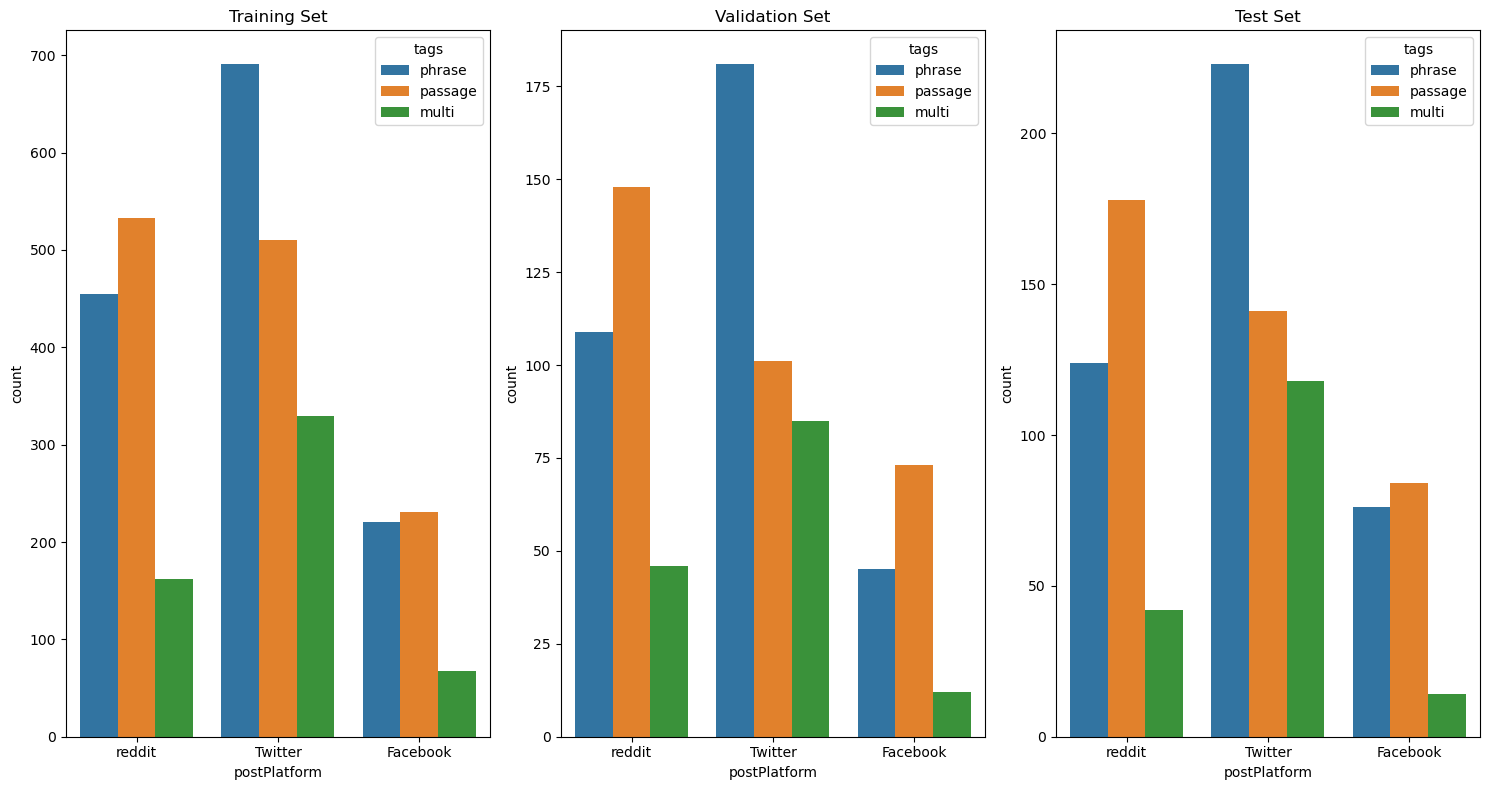

In [22]:
#Visualisation of the type of spoilers by platform
category_order = ['reddit', 'Twitter', 'Facebook']
hue_order = ['phrase', 'passage', 'multi']


fig, ax = plt.subplots(1,3, figsize=(15, 8))

sns.countplot(x='postPlatform', data=Train_df, hue='tags', order=category_order, hue_order=hue_order, ax=ax[0])
ax[0].set_title('Training Set')

sns.countplot(x='postPlatform', data=Val_df, hue='tags', order=category_order, hue_order=hue_order, ax=ax[1])
ax[1].set_title('Validation Set')

sns.countplot(x='postPlatform', data=Test_df, hue='tags', order=category_order, hue_order=hue_order, ax=ax[2])
ax[2].set_title('Test Set')

fig.tight_layout()
plt.show()

In [23]:
#Checking sum of null values in each Training columns
Train_df.isnull().sum()

postText               0
postPlatform           0
targetParagraphs       0
targetTitle            0
targetDescription    267
tags                   0
dtype: int64

In [24]:
#Dropping null values in the 'targetDescription' column
Train_df = Train_df.dropna(subset=['targetDescription'])

In [25]:
#Confirming no null values in the Training Dataset
Train_df.isnull().sum()

postText             0
postPlatform         0
targetParagraphs     0
targetTitle          0
targetDescription    0
tags                 0
dtype: int64

In [26]:
#Checking the unique values in each column
Train_df.nunique()

postText             2919
postPlatform            3
targetParagraphs     2918
targetTitle          2903
targetDescription    2813
tags                    3
dtype: int64

In [27]:
#Checking sum of null values in each Validation columns
Val_df.isnull().sum()

postText              0
postPlatform          0
targetParagraphs      0
targetTitle           0
targetDescription    70
tags                  0
dtype: int64

In [28]:
#Dropping null values in the validation set
Val_df = Val_df.dropna(subset=['targetDescription'])

In [29]:
#Confirming no null values in the Validation Dataset
Val_df.isnull().sum()

postText             0
postPlatform         0
targetParagraphs     0
targetTitle          0
targetDescription    0
tags                 0
dtype: int64

In [30]:
#Checking the unique values in each column of validation set
Val_df.nunique()

postText             729
postPlatform           3
targetParagraphs     730
targetTitle          728
targetDescription    719
tags                   3
dtype: int64

In [31]:
#Checking sum of null values in each Test columns
Test_df.isnull().sum()

postText              0
postPlatform          0
targetParagraphs      0
targetTitle           0
targetDescription    83
tags                  0
dtype: int64

In [32]:
#Dropping null values in the test set
Test_df = Test_df.dropna(subset=['targetDescription'])

In [33]:
#Confirming no null values in the Test Dataset
Test_df.isnull().sum()

postText             0
postPlatform         0
targetParagraphs     0
targetTitle          0
targetDescription    0
tags                 0
dtype: int64

In [34]:
#Checking the unique values in each column of Test set
Test_df.nunique()

postText             917
postPlatform           3
targetParagraphs     916
targetTitle          913
targetDescription    887
tags                   3
dtype: int64

# **PREPROCESSING**

In [35]:
#Removing special characters and changing the Training dataset to lower case
Train2 = Train_df.copy()
clean_train = clean_data(Train2)
clean_train.head(3)

postText postPlatform  \
0  wes welker wanted dinner with tom brady but pa...       reddit   
1     nasa sets date for full recovery of ozone hole      twitter   
2  this is what makes employees happy and it s no...      twitter   

                                    targetParagraphs  \
0  it ll be just like old times this weekend for ...   
1  2070 is shaping up to be a great year for moth...   
2  despite common belief money isn t the key to e...   

                                         targetTitle  \
0  wes welker wanted dinner with tom brady but pa...   
1  hole in ozone layer expected to make full reco...   
2  intellectual stimulation trumps money for empl...   

                                   targetDescription     tags  
0  it ll be just like old times this weekend for ...  passage  
1  2070 is shaping up to be a great year for moth...   phrase  
2  by chad brooks published 09 18 2013 06 40 am e...   phrase

In [36]:
#Create sentence tokenization of the Training dataset
sent_tokenize_data(clean_train)
clean_train.head(3)

postText postPlatform  \
0  [wes welker wanted dinner with tom brady but p...     [reddit]   
1   [nasa sets date for full recovery of ozone hole]    [twitter]   
2  [this is what makes employees happy and it s n...    [twitter]   

                                    targetParagraphs  \
0  [it ll be just like old times this weekend for...   
1  [2070 is shaping up to be a great year for mot...   
2  [despite common belief money isn t the key to ...   

                                         targetTitle  \
0  [wes welker wanted dinner with tom brady but p...   
1  [hole in ozone layer expected to make full rec...   
2  [intellectual stimulation trumps money for emp...   

                                   targetDescription       tags  
0  [it ll be just like old times this weekend for...  [passage]  
1  [2070 is shaping up to be a great year for mot...   [phrase]  
2  [by chad brooks published 09 18 2013 06 40 am ...   [phrase]

In [37]:
#Tokenize each word in for each tokenized Training sentence
word_tokenize_data(clean_train)
clean_train.head(3)

postText postPlatform  \
0  [[wes, welker, wanted, dinner, with, tom, brad...   [[reddit]]   
1  [[nasa, sets, date, for, full, recovery, of, o...  [[twitter]]   
2  [[this, is, what, makes, employees, happy, and...  [[twitter]]   

                                    targetParagraphs  \
0  [[it, ll, be, just, like, old, times, this, we...   
1  [[2070, is, shaping, up, to, be, a, great, yea...   
2  [[despite, common, belief, money, isn, t, the,...   

                                         targetTitle  \
0  [[wes, welker, wanted, dinner, with, tom, brad...   
1  [[hole, in, ozone, layer, expected, to, make, ...   
2  [[intellectual, stimulation, trumps, money, fo...   

                                   targetDescription         tags  
0  [[it, ll, be, just, like, old, times, this, we...  [[passage]]  
1  [[2070, is, shaping, up, to, be, a, great, yea...   [[phrase]]  
2  [[by, chad, brooks, published, 09, 18, 2013, 0...   [[phrase]]

In [38]:
#Remove stopwords from the Training dataset
remove_stopwords(clean_train)
clean_train.head(3)

postText postPlatform  \
0  [[wes, welker, wanted, dinner, tom, brady, pat...   [[reddit]]   
1  [[nasa, sets, date, full, recovery, ozone, hole]]  [[twitter]]   
2              [[makes, employees, happy, paycheck]]  [[twitter]]   

                                    targetParagraphs  \
0  [[like, old, times, weekend, tom, brady, wes, ...   
1  [[2070, shaping, great, year, mother, earth, n...   
2  [[despite, common, belief, money, key, employe...   

                                         targetTitle  \
0  [[wes, welker, wanted, dinner, tom, brady, pat...   
1  [[hole, ozone, layer, expected, make, full, re...   
2  [[intellectual, stimulation, trumps, money, em...   

                                   targetDescription         tags  
0  [[like, old, times, weekend, tom, brady, wes, ...  [[passage]]  
1  [[2070, shaping, great, year, mother, earth, n...   [[phrase]]  
2  [[chad, brooks, published, 09, 18, 2013, 06, 4...   [[phrase]]

In [39]:
#Removing special characters and changing the Validation dataset to lower case
Val2 = Val_df.copy()
clean_val = clean_data(Val2)
clean_val.head(3)

postText postPlatform  \
0  five nights at freddy s sequel delayed for wei...     facebook   
1  why arizona sheriff joe arpaio s fate could ha...       reddit   
2  here s how much you should be tipping your hai...      twitter   

                                    targetParagraphs  \
0  five nights at freddy s creator scott cawthon ...   
1   reuters laura segall maricopa county sheriff ...   
2  here s how much you should be tipping your hai...   

                                         targetTitle  \
0  five nights at freddy s sequel delayed for wei...   
1  why arizona sheriff joe arpaio s fate could ha...   
2  here s how much you should be tipping your hai...   

                                   targetDescription     tags  
0  five nights at freddy s creator scott cawthon ...  passage  
1   p a single word intentionally could transform...    multi  
2  remembering how much you re supposed to tip an...   phrase

In [40]:
#Create sentence tokenization of the validation dataset
sent_tokenize_data(clean_val)
clean_val.head(3)

postText postPlatform  \
0  [five nights at freddy s sequel delayed for we...   [facebook]   
1  [why arizona sheriff joe arpaio s fate could h...     [reddit]   
2  [here s how much you should be tipping your ha...    [twitter]   

                                    targetParagraphs  \
0  [five nights at freddy s creator scott cawthon...   
1  [ reuters laura segall maricopa county sheriff...   
2  [here s how much you should be tipping your ha...   

                                         targetTitle  \
0  [five nights at freddy s sequel delayed for we...   
1  [why arizona sheriff joe arpaio s fate could h...   
2  [here s how much you should be tipping your ha...   

                                   targetDescription       tags  
0  [five nights at freddy s creator scott cawthon...  [passage]  
1  [ p a single word intentionally could transfor...    [multi]  
2  [remembering how much you re supposed to tip a...   [phrase]

In [41]:
#Tokenize each word in for each tokenized validation sentences
word_tokenize_data(clean_val)
clean_val.head(3)

postText  postPlatform  \
0  [[five, nights, at, freddy, s, sequel, delayed...  [[facebook]]   
1  [[why, arizona, sheriff, joe, arpaio, s, fate,...    [[reddit]]   
2  [[here, s, how, much, you, should, be, tipping...   [[twitter]]   

                                    targetParagraphs  \
0  [[five, nights, at, freddy, s, creator, scott,...   
1  [[reuters, laura, segall, maricopa, county, sh...   
2  [[here, s, how, much, you, should, be, tipping...   

                                         targetTitle  \
0  [[five, nights, at, freddy, s, sequel, delayed...   
1  [[why, arizona, sheriff, joe, arpaio, s, fate,...   
2  [[here, s, how, much, you, should, be, tipping...   

                                   targetDescription         tags  
0  [[five, nights, at, freddy, s, creator, scott,...  [[passage]]  
1  [[p, a, single, word, intentionally, could, tr...    [[multi]]  
2  [[remembering, how, much, you, re, supposed, t...   [[phrase]]

In [42]:
#Remove stopwords from the validation dataset
remove_stopwords(clean_val)
clean_val.head(3)

postText  postPlatform  \
0  [[five, nights, freddy, sequel, delayed, weird...  [[facebook]]   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...    [[reddit]]   
2                     [[much, tipping, hairdresser]]   [[twitter]]   

                                    targetParagraphs  \
0  [[five, nights, freddy, creator, scott, cawtho...   
1  [[reuters, laura, segall, maricopa, county, sh...   
2  [[much, tipping, hairdressermoreremembering, m...   

                                         targetTitle  \
0  [[five, nights, freddy, sequel, delayed, weird...   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...   
2                     [[much, tipping, hairdresser]]   

                                   targetDescription         tags  
0  [[five, nights, freddy, creator, scott, cawtho...  [[passage]]  
1  [[p, single, word, intentionally, could, trans...    [[multi]]  
2  [[remembering, much, supposed, tip, anywhere, ...   [[phrase]]

In [43]:
#Removing special characters and changing the Test dataset to lower case
Test2 = Test_df.copy()
clean_test = clean_data(Test2)
clean_test.head(3)

postText postPlatform  \
0             this simple household item saves lives      twitter   
1  you ll never believe who robert downey jr s fr...       reddit   
2  the newest theory on hiddleswift s romance is ...       reddit   

                                    targetParagraphs  \
0  erin zaikis often used to think about how she ...   
1  we weren t expecting this one on wednesday rob...   
2  this whole taylor swift tom hiddleston thing j...   

                                         targetTitle  \
0  the simple household item this 24 year old is ...   
1  you ll never believe who robert downey jr s fr...   
2  the newest theory on hiddleswift s romance is ...   

                                   targetDescription     tags  
0  erin zaikis often used to think about how she ...   phrase  
1  it s not uncommon for couples to have free pas...   phrase  
2  we ve done some serious investigative journali...  passage

In [44]:
#Create sentence tokenization of the Test dataset
sent_tokenize_data(clean_test)
clean_test.head(3)

postText postPlatform  \
0           [this simple household item saves lives]    [twitter]   
1  [you ll never believe who robert downey jr s f...     [reddit]   
2  [the newest theory on hiddleswift s romance is...     [reddit]   

                                    targetParagraphs  \
0  [erin zaikis often used to think about how she...   
1  [we weren t expecting this one on wednesday ro...   
2  [this whole taylor swift tom hiddleston thing ...   

                                         targetTitle  \
0  [the simple household item this 24 year old is...   
1  [you ll never believe who robert downey jr s f...   
2  [the newest theory on hiddleswift s romance is...   

                                   targetDescription       tags  
0  [erin zaikis often used to think about how she...   [phrase]  
1  [it s not uncommon for couples to have free pa...   [phrase]  
2  [we ve done some serious investigative journal...  [passage]

In [45]:
#Tokenize each word in for each tokenized test sentences
word_tokenize_data(clean_test)
clean_test.head(3)

postText postPlatform  \
0    [[this, simple, household, item, saves, lives]]  [[twitter]]   
1  [[you, ll, never, believe, who, robert, downey...   [[reddit]]   
2  [[the, newest, theory, on, hiddleswift, s, rom...   [[reddit]]   

                                    targetParagraphs  \
0  [[erin, zaikis, often, used, to, think, about,...   
1  [[we, weren, t, expecting, this, one, on, wedn...   
2  [[this, whole, taylor, swift, tom, hiddleston,...   

                                         targetTitle  \
0  [[the, simple, household, item, this, 24, year...   
1  [[you, ll, never, believe, who, robert, downey...   
2  [[the, newest, theory, on, hiddleswift, s, rom...   

                                   targetDescription         tags  
0  [[erin, zaikis, often, used, to, think, about,...   [[phrase]]  
1  [[it, s, not, uncommon, for, couples, to, have...   [[phrase]]  
2  [[we, ve, done, some, serious, investigative, ...  [[passage]]

In [46]:
#Remove stopwords from the Test dataset
remove_stopwords(clean_test)
clean_test.head(3)

postText postPlatform  \
0          [[simple, household, item, saves, lives]]  [[twitter]]   
1  [[never, believe, robert, downey, jr, free, pa...   [[reddit]]   
2  [[newest, theory, hiddleswift, romance, bizarr...   [[reddit]]   

                                    targetParagraphs  \
0  [[erin, zaikis, often, used, think, could, hel...   
1  [[expecting, one, wednesday, robert, downey, j...   
2  [[whole, taylor, swift, tom, hiddleston, thing...   

                                         targetTitle  \
0  [[simple, household, item, 24, year, old, usin...   
1  [[never, believe, robert, downey, jr, free, pa...   
2  [[newest, theory, hiddleswift, romance, bizarr...   

                                   targetDescription         tags  
0  [[erin, zaikis, often, used, think, could, hel...   [[phrase]]  
1                [[uncommon, couples, free, passes]]   [[phrase]]  
2  [[done, serious, investigative, journalism, co...  [[passage]]

# **Stemming**

### **Training Dataset**

In [47]:
#Make a copy of the cleaned training dataset for stemming
train_stem = clean_train.copy()
train_stem.head(3)

postText postPlatform  \
0  [[wes, welker, wanted, dinner, tom, brady, pat...   [[reddit]]   
1  [[nasa, sets, date, full, recovery, ozone, hole]]  [[twitter]]   
2              [[makes, employees, happy, paycheck]]  [[twitter]]   

                                    targetParagraphs  \
0  [[like, old, times, weekend, tom, brady, wes, ...   
1  [[2070, shaping, great, year, mother, earth, n...   
2  [[despite, common, belief, money, key, employe...   

                                         targetTitle  \
0  [[wes, welker, wanted, dinner, tom, brady, pat...   
1  [[hole, ozone, layer, expected, make, full, re...   
2  [[intellectual, stimulation, trumps, money, em...   

                                   targetDescription         tags  
0  [[like, old, times, weekend, tom, brady, wes, ...  [[passage]]  
1  [[2070, shaping, great, year, mother, earth, n...   [[phrase]]  
2  [[chad, brooks, published, 09, 18, 2013, 06, 4...   [[phrase]]

In [48]:
#Perform Potter Stemming on the Training Dataset
stem_data(train_stem)
train_stem.head(3)

postText postPlatform  \
0  [[we, welker, want, dinner, tom, bradi, patrio...   [[reddit]]   
1    [[nasa, set, date, full, recoveri, ozon, hole]]  [[twitter]]   
2                 [[make, employe, happi, paycheck]]  [[twitter]]   

                                    targetParagraphs  \
0  [[like, old, time, weekend, tom, bradi, we, we...   
1  [[2070, shape, great, year, mother, earth, nas...   
2  [[despit, common, belief, money, key, employe,...   

                                         targetTitle  \
0  [[we, welker, want, dinner, tom, bradi, patrio...   
1  [[hole, ozon, layer, expect, make, full, recov...   
2  [[intellectu, stimul, trump, money, employe, h...   

                                   targetDescription        tags  
0  [[like, old, time, weekend, tom, bradi, we, we...  [[passag]]  
1  [[2070, shape, great, year, mother, earth, nas...  [[phrase]]  
2  [[chad, brook, publish, 09, 18, 2013, 06, 40, ...  [[phrase]]

In [49]:
#removing the listings from the dataset
train_stem = remove_listing(train_stem)
train_stem.head(3)

postText postPlatform  \
0  we welker want dinner tom bradi patriot qb bet...       reddit   
1              nasa set date full recoveri ozon hole      twitter   
2                        make employe happi paycheck      twitter   

                                    targetParagraphs  \
0  like old time weekend tom bradi we welker welk...   
1  2070 shape great year mother earth nasa scient...   
2  despit common belief money key employe happi n...   

                                         targetTitle  \
0  we welker want dinner tom bradi patriot qb bet...   
1  hole ozon layer expect make full recoveri 2070...   
2  intellectu stimul trump money employe happi su...   

                                   targetDescription    tags  
0  like old time weekend tom bradi we welker welk...  passag  
1  2070 shape great year mother earth nasa scient...  phrase  
2  chad brook publish 09 18 2013 06 40 edt busine...  phrase

In [50]:
#Combining all features into one text
train_stem = combine_text(train_stem)
train_stem.head()

postText postPlatform  \
0  we welker want dinner tom bradi patriot qb bet...       reddit   
1              nasa set date full recoveri ozon hole      twitter   
2                        make employe happi paycheck      twitter   
3            passion overr 7 work habit need instead      twitter   
4  perfect way cook rice perfectli fluffi never s...      twitter   

                                    targetParagraphs  \
0  like old time weekend tom bradi we welker welk...   
1  2070 shape great year mother earth nasa scient...   
2  despit common belief money key employe happi n...   
3  common wisdom near gospel realli among young p...   
4  boil rice may seem simpl fine line cook crunch...   

                                         targetTitle  \
0  we welker want dinner tom bradi patriot qb bet...   
1  hole ozon layer expect make full recoveri 2070...   
2  intellectu stimul trump money employe happi su...   
3          follow passion wrong 7 habit need instead   
4  reveal perfect way cook rice perfectli fluffi ...   

                                   targetDescription    tags  \
0  like old time weekend tom bradi we welker welk...  passag   
1  2070 shape great year mother earth nasa scient...  phrase   
2  chad brook publish 09 18 2013 06 40 edt busine...  phrase   
3                                  lot work love job   multi   
4  question one cook rice properli post websit qu...  phrase   

                                       combined_text  
0  we welker want dinner tom bradi patriot qb bet...  
1  nasa set date full recoveri ozon hole twitter ...  
2  make employe happi paycheck twitter despit com...  
3  passion overr 7 work habit need instead twitte...  
4  perfect way cook rice perfectli fluffi never s...

In [51]:
#Extracting the trainning target feature
stem_traintags = train_stem['tags']
y_stemtrain = label_encoder.fit_transform(stem_traintags)

In [52]:
#Extract training set combined text feature
train_stem_combined = train_stem['combined_text']
train_stem_combined.head()

0    we welker want dinner tom bradi patriot qb bet...
1    nasa set date full recoveri ozon hole twitter ...
2    make employe happi paycheck twitter despit com...
3    passion overr 7 work habit need instead twitte...
4    perfect way cook rice perfectli fluffi never s...
Name: combined_text, dtype: object

### **Validation Dataset**

In [53]:
#Make a copy of the cleaned validation dataset for stemming
val_stem = clean_val.copy()
val_stem.head(3)

postText  postPlatform  \
0  [[five, nights, freddy, sequel, delayed, weird...  [[facebook]]   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...    [[reddit]]   
2                     [[much, tipping, hairdresser]]   [[twitter]]   

                                    targetParagraphs  \
0  [[five, nights, freddy, creator, scott, cawtho...   
1  [[reuters, laura, segall, maricopa, county, sh...   
2  [[much, tipping, hairdressermoreremembering, m...   

                                         targetTitle  \
0  [[five, nights, freddy, sequel, delayed, weird...   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...   
2                     [[much, tipping, hairdresser]]   

                                   targetDescription         tags  
0  [[five, nights, freddy, creator, scott, cawtho...  [[passage]]  
1  [[p, single, word, intentionally, could, trans...    [[multi]]  
2  [[remembering, much, supposed, tip, anywhere, ...   [[phrase]]

In [54]:
#Perform Potter Stemming on the validation dataset
stem_data(val_stem)
val_stem.head(3)

postText  postPlatform  \
0  [[five, night, freddi, sequel, delay, weird, r...  [[facebook]]   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...    [[reddit]]   
2                           [[much, tip, hairdress]]   [[twitter]]   

                                    targetParagraphs  \
0  [[five, night, freddi, creator, scott, cawthon...   
1  [[reuter, laura, segal, maricopa, counti, sher...   
2  [[much, tip, hairdressermorerememb, much, supp...   

                                         targetTitle  \
0  [[five, night, freddi, sequel, delay, weird, r...   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...   
2                           [[much, tip, hairdress]]   

                                   targetDescription        tags  
0  [[five, night, freddi, creator, scott, cawthon...  [[passag]]  
1  [[p, singl, word, intent, could, transform, co...   [[multi]]  
2  [[rememb, much, suppos, tip, anywher, hard, cu...  [[phrase]]

In [55]:
#removing the listings from the validation dataset
val_stem = remove_listing(val_stem)
val_stem.head(3)

postText postPlatform  \
0        five night freddi sequel delay weird reason     facebook   
1  arizona sheriff joe arpaio fate could hang sin...       reddit   
2                                 much tip hairdress      twitter   

                                    targetParagraphs  \
0  five night freddi creator scott cawthon take s...   
1  reuter laura segal maricopa counti sheriff joe...   
2  much tip hairdressermorerememb much suppos tip...   

                                         targetTitle  \
0        five night freddi sequel delay weird reason   
1  arizona sheriff joe arpaio fate could hang sin...   
2                                 much tip hairdress   

                                   targetDescription    tags  
0  five night freddi creator scott cawthon take s...  passag  
1  p singl word intent could transform court case...   multi  
2  rememb much suppos tip anywher hard current tr...  phrase

In [56]:
#Combining all features into one text for validation set
val_stem = combine_text(val_stem)
val_stem.head()

postText postPlatform  \
0        five night freddi sequel delay weird reason     facebook   
1  arizona sheriff joe arpaio fate could hang sin...       reddit   
2                                 much tip hairdress      twitter   
3                  harri potter alum reunit new movi      twitter   
4        man swallow microsd card believ happen next      twitter   

                                    targetParagraphs  \
0  five night freddi creator scott cawthon take s...   
1  reuter laura segal maricopa counti sheriff joe...   
2  much tip hairdressermorerememb much suppos tip...   
3  mytholog punk music evolut trace back less one...   
4  petapixel one favorit blog writer passion know...   

                                         targetTitle  \
0        five night freddi sequel delay weird reason   
1  arizona sheriff joe arpaio fate could hang sin...   
2                                 much tip hairdress   
3  alan rickman rupert grint cbgb reunit post pot...   
4        man swallow microsd card believ happen next   

                                   targetDescription    tags  \
0  five night freddi creator scott cawthon take s...  passag   
1  p singl word intent could transform court case...   multi   
2  rememb much suppos tip anywher hard current tr...  phrase   
3  mytholog punk music evolut trace back less one...   multi   
4  petapixel one favorit blog writer passion know...  passag   

                                       combined_text  
0  five night freddi sequel delay weird reason fa...  
1  arizona sheriff joe arpaio fate could hang sin...  
2  much tip hairdress twitter much tip hairdresse...  
3  harri potter alum reunit new movi twitter myth...  
4  man swallow microsd card believ happen next tw...

In [57]:
#Extracting the validation target feature
stem_valtags = val_stem['tags']
y_stemval = label_encoder.transform(stem_valtags)

In [58]:
#Extract the validation set combined text feature
val_stem_combined = val_stem['combined_text']
val_stem_combined.head()

0    five night freddi sequel delay weird reason fa...
1    arizona sheriff joe arpaio fate could hang sin...
2    much tip hairdress twitter much tip hairdresse...
3    harri potter alum reunit new movi twitter myth...
4    man swallow microsd card believ happen next tw...
Name: combined_text, dtype: object

### **Test Dataset**

In [59]:
#Make a copy of the cleaned validation dataset for stemming
test_stem = clean_test.copy()
test_stem.head(3)

postText postPlatform  \
0          [[simple, household, item, saves, lives]]  [[twitter]]   
1  [[never, believe, robert, downey, jr, free, pa...   [[reddit]]   
2  [[newest, theory, hiddleswift, romance, bizarr...   [[reddit]]   

                                    targetParagraphs  \
0  [[erin, zaikis, often, used, think, could, hel...   
1  [[expecting, one, wednesday, robert, downey, j...   
2  [[whole, taylor, swift, tom, hiddleston, thing...   

                                         targetTitle  \
0  [[simple, household, item, 24, year, old, usin...   
1  [[never, believe, robert, downey, jr, free, pa...   
2  [[newest, theory, hiddleswift, romance, bizarr...   

                                   targetDescription         tags  
0  [[erin, zaikis, often, used, think, could, hel...   [[phrase]]  
1                [[uncommon, couples, free, passes]]   [[phrase]]  
2  [[done, serious, investigative, journalism, co...  [[passage]]

In [60]:
#Perform Potter Stemming on the test dataset
stem_data(test_stem)
test_stem.head(3)

postText postPlatform  \
0             [[simpl, household, item, save, live]]  [[twitter]]   
1  [[never, believ, robert, downey, jr, free, pass]]   [[reddit]]   
2  [[newest, theori, hiddleswift, romanc, bizarr,...   [[reddit]]   

                                    targetParagraphs  \
0  [[erin, zaiki, often, use, think, could, help,...   
1  [[expect, one, wednesday, robert, downey, jr, ...   
2  [[whole, taylor, swift, tom, hiddleston, thing...   

                                         targetTitle  \
0  [[simpl, household, item, 24, year, old, use, ...   
1  [[never, believ, robert, downey, jr, free, pass]]   
2  [[newest, theori, hiddleswift, romanc, bizarr,...   

                                   targetDescription        tags  
0  [[erin, zaiki, often, use, think, could, help,...  [[phrase]]  
1                    [[uncommon, coupl, free, pass]]  [[phrase]]  
2          [[done, seriou, investig, journal, come]]  [[passag]]

In [61]:
#removing the listings from the test dataset
test_stem = remove_listing(test_stem)
test_stem.head(3)

postText postPlatform  \
0                     simpl household item save live      twitter   
1            never believ robert downey jr free pass       reddit   
2  newest theori hiddleswift romanc bizarr strang...       reddit   

                                    targetParagraphs  \
0  erin zaiki often use think could help chang wo...   
1  expect one wednesday robert downey jr visit ho...   
2  whole taylor swift tom hiddleston thing add us...   

                                         targetTitle  \
0   simpl household item 24 year old use chang world   
1            never believ robert downey jr free pass   
2  newest theori hiddleswift romanc bizarr strang...   

                                   targetDescription    tags  
0  erin zaiki often use think could help chang wo...  phrase  
1                           uncommon coupl free pass  phrase  
2                  done seriou investig journal come  passag

In [62]:
#Combining all features into one text for test set
test_stem = combine_text(test_stem)
test_stem.head()

postText postPlatform  \
0                     simpl household item save live      twitter   
1            never believ robert downey jr free pass       reddit   
2  newest theori hiddleswift romanc bizarr strang...       reddit   
3   nba star surpris inner citi youth basketbal team      twitter   
4            littl girl titan grown still crazi ador      twitter   

                                    targetParagraphs  \
0  erin zaiki often use think could help chang wo...   
1  expect one wednesday robert downey jr visit ho...   
2  whole taylor swift tom hiddleston thing add us...   
3  spend summer lo angel denver nugget center jav...   
4  believ cute go 1 rememb titan rose kate winsle...   

                                         targetTitle  \
0   simpl household item 24 year old use chang world   
1            never believ robert downey jr free pass   
2  newest theori hiddleswift romanc bizarr strang...   
3  nba player javal mcgee give pep talk boy baske...   
4            littl girl titan grown still crazi ador   

                                   targetDescription    tags  \
0  erin zaiki often use think could help chang wo...  phrase   
1                           uncommon coupl free pass  phrase   
2                  done seriou investig journal come  passag   
3         spend summer lo angel denver nugget center   multi   
4                                                     phrase   

                                       combined_text  
0  simpl household item save live twitter erin za...  
1  never believ robert downey jr free pass reddit...  
2  newest theori hiddleswift romanc bizarr strang...  
3  nba star surpris inner citi youth basketbal te...  
4  littl girl titan grown still crazi ador twitte...

In [63]:
#Extracting the test target feature
stem_testtags = test_stem['tags']
y_stemtest = label_encoder.transform(stem_testtags)

In [64]:
#Extract the test set combined text feature
test_stem_combined = test_stem['combined_text']
test_stem_combined.head()

0    simpl household item save live twitter erin za...
1    never believ robert downey jr free pass reddit...
2    newest theori hiddleswift romanc bizarr strang...
3    nba star surpris inner citi youth basketbal te...
4    littl girl titan grown still crazi ador twitte...
Name: combined_text, dtype: object

## Vectorization for Stemmed Datasets

### **Bag of Words - Stemming**

In [65]:
#Bag Of Words for training set

vectorizer_stembow, X_stem_bowtrain = bow_vectorizer_train(train_stem_combined)
print("X_stem_bowtrain shape:", X_stem_bowtrain.shape)

X_stem_bowtrain shape: (2933, 10000)


In [66]:
X_stem_bowtrain.head()

0       we welker want dinner tom bradi patriot qb bet...\n1       nasa set date full recoveri ozon hole twitter ...\n2       make employe happi paycheck twitter despit com...\n3       passion overr 7 work habit need instead twitte...\n4       perfect way cook rice perfectli fluffi never s...\n                              ...                        \n3194    see purpl butterfli sticker hospit mean facebo...\n3195    facebook video explos complet shaken ad market...\n3197    5 popular myth visibl sign age bogu twitter ob...\n3198    need see twitter account predict beyonc pregna...\n3199    gop congressman come gay marriag twitter rep c...\nName: combined_text, Length: 2933, dtype: object_00  \
0                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
3                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
4                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                

In [67]:
X_stem_bowtrain = X_stem_bowtrain.values

In [68]:
X_stem_bowtrain.shape

(2933, 10000)

In [69]:
#Bag Of Words for validation set

X_stem_bowval = bow_vectorizer(vectorizer_stembow, val_stem_combined)
print("X_stem_bowval shape:", X_stem_bowval.shape)

X_stem_bowval shape: (730, 10000)


In [70]:
X_stem_bowval.head()

0      five night freddi sequel delay weird reason fa...\n1      arizona sheriff joe arpaio fate could hang sin...\n2      much tip hairdress twitter much tip hairdresse...\n3      harri potter alum reunit new movi twitter myth...\n4      man swallow microsd card believ happen next tw...\n                             ...                        \n795    happen leav hotel cleaner 500 tip twitter inst...\n796    texa gop elector announc vote trump twitter re...\n797    beauti queen cure acn one diet chang twitter i...\n798    wikileak julian assang report dead twitter 16 ...\n799    origin law amp order svu cast member leav show...\nName: combined_text, Length: 730, dtype: object_00  \
0                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [71]:
X_stem_bowval = X_stem_bowval.values

In [72]:
X_stem_bowval.shape

(730, 10000)

In [73]:
#Bag Of Words for test set

X_stem_bowtest = bow_vectorizer(vectorizer_stembow, test_stem_combined)
print("X_stem_bowtest shape:", X_stem_bowtest.shape)

X_stem_bowtest shape: (917, 10000)


In [74]:
X_stem_bowtest.head()

0      simpl household item save live twitter erin za...\n1      never believ robert downey jr free pass reddit...\n2      newest theori hiddleswift romanc bizarr strang...\n3      nba star surpris inner citi youth basketbal te...\n4      littl girl titan grown still crazi ador twitte...\n                             ...                        \n994    dad son second assassin isi quiet click half m...\n996    shave ball sinc appar googl twitter look googl...\n997    blood moon come oct 8 see twitter feel strong ...\n998    pippi longstock star arrest twitter former pip...\n999    never guess rob low weird favorit smell twitte...\nName: combined_text, Length: 917, dtype: object_00  \
0                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [75]:
X_stem_bowtest = X_stem_bowtest.values

In [76]:
X_stem_bowtest.shape

(917, 10000)

In [77]:
#Stemming Bag of words features
X_stem_bowtrain
X_stem_bowval
X_stem_bowtest

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [78]:
# Normalize Stem BOW features

scaler = MinMaxScaler()

X_stem_bowtrain = scaler.fit_transform(X_stem_bowtrain)
X_stem_bowval = scaler.transform(X_stem_bowval)
X_stem_bowtest = scaler.transform(X_stem_bowtest)


### **TFIDF - Stemming**

In [79]:
#Tfdif Vectorization for Train dataset

vectorizer_stemtfdif, X_stem_tfidftrain = tfidf_vectorizer_train(train_stem_combined)
print("X_stem_tfidftrain shape:", X_stem_tfidftrain.shape)

X_stem_tfidftrain shape: (2933, 10000)


In [80]:
X_stem_tfidftrain.head()

0       we welker want dinner tom bradi patriot qb bet...\n1       nasa set date full recoveri ozon hole twitter ...\n2       make employe happi paycheck twitter despit com...\n3       passion overr 7 work habit need instead twitte...\n4       perfect way cook rice perfectli fluffi never s...\n                              ...                        \n3194    see purpl butterfli sticker hospit mean facebo...\n3195    facebook video explos complet shaken ad market...\n3197    5 popular myth visibl sign age bogu twitter ob...\n3198    need see twitter account predict beyonc pregna...\n3199    gop congressman come gay marriag twitter rep c...\nName: combined_text, Length: 2933, dtype: object_00  \
0                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
3                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
4                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                

In [81]:
X_stem_tfidftrain = X_stem_tfidftrain.values

In [82]:
X_stem_tfidftrain.shape

(2933, 10000)

In [83]:
#Tfdif Vectorization for validation dataset

X_stem_tfidfval = tfidf_vectorizer(vectorizer_stemtfdif, val_stem_combined)
print("X_stem_tfidfval shape:", X_stem_tfidfval.shape)

X_stem_tfidfval shape: (730, 10000)


In [84]:
X_stem_tfidfval.head()

0      five night freddi sequel delay weird reason fa...\n1      arizona sheriff joe arpaio fate could hang sin...\n2      much tip hairdress twitter much tip hairdresse...\n3      harri potter alum reunit new movi twitter myth...\n4      man swallow microsd card believ happen next tw...\n                             ...                        \n795    happen leav hotel cleaner 500 tip twitter inst...\n796    texa gop elector announc vote trump twitter re...\n797    beauti queen cure acn one diet chang twitter i...\n798    wikileak julian assang report dead twitter 16 ...\n799    origin law amp order svu cast member leav show...\nName: combined_text, Length: 730, dtype: object_00  \
0                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [85]:
X_stem_tfidfval = X_stem_tfidfval.values

In [86]:
X_stem_tfidfval.shape

(730, 10000)

In [87]:
#Tfdif Vectorization for test dataset

X_stem_tfidftest = tfidf_vectorizer(vectorizer_stemtfdif, test_stem_combined)
print("X_stem_tfidftest shape:", X_stem_tfidftest.shape)

X_stem_tfidftest shape: (917, 10000)


In [88]:
X_stem_tfidftest.head()

0      simpl household item save live twitter erin za...\n1      never believ robert downey jr free pass reddit...\n2      newest theori hiddleswift romanc bizarr strang...\n3      nba star surpris inner citi youth basketbal te...\n4      littl girl titan grown still crazi ador twitte...\n                             ...                        \n994    dad son second assassin isi quiet click half m...\n996    shave ball sinc appar googl twitter look googl...\n997    blood moon come oct 8 see twitter feel strong ...\n998    pippi longstock star arrest twitter former pip...\n999    never guess rob low weird favorit smell twitte...\nName: combined_text, Length: 917, dtype: object_00  \
0                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [89]:
X_stem_tfidftest = X_stem_tfidftest.values

In [90]:
X_stem_tfidftest.shape

(917, 10000)

In [91]:
#Stemming TFIDF features
X_stem_tfidftrain
X_stem_tfidfval
X_stem_tfidftest

array([[0.        , 0.01716666, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06664244, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [92]:
# Normalize Stem TFIDF features

X_stem_tfidftrain = scaler.fit_transform(X_stem_tfidftrain)
X_stem_tfidfval = scaler.transform(X_stem_tfidfval)
X_stem_tfidftest = scaler.transform(X_stem_tfidftest)

### **Word2Vec - Stemming**

In [93]:
#Word2Vec for trainning dataset
w2vtrain_stem_combined = train_stem[['combined_text']].copy()

In [94]:
w2vtrain_stem_combined.head()

combined_text
0  we welker want dinner tom bradi patriot qb bet...
1  nasa set date full recoveri ozon hole twitter ...
2  make employe happi paycheck twitter despit com...
3  passion overr 7 work habit need instead twitte...
4  perfect way cook rice perfectli fluffi never s...

In [95]:
word2vec_vectorizer(w2vtrain_stem_combined)

combined_text  \
0     we welker want dinner tom bradi patriot qb bet...   
1     nasa set date full recoveri ozon hole twitter ...   
2     make employe happi paycheck twitter despit com...   
3     passion overr 7 work habit need instead twitte...   
4     perfect way cook rice perfectli fluffi never s...   
...                                                 ...   
3194  see purpl butterfli sticker hospit mean facebo...   
3195  facebook video explos complet shaken ad market...   
3197  5 popular myth visibl sign age bogu twitter ob...   
3198  need see twitter account predict beyonc pregna...   
3199  gop congressman come gay marriag twitter rep c...   

                                                 tokens  \
0     [we, welker, want, dinner, tom, bradi, patriot...   
1     [nasa, set, date, full, recoveri, ozon, hole, ...   
2     [make, employe, happi, paycheck, twitter, desp...   
3     [passion, overr, 7, work, habit, need, instead...   
4     [perfect, way, cook, rice, perfectli, fluffi, ...   
...                                                 ...   
3194  [see, purpl, butterfli, sticker, hospit, mean,...   
3195  [facebook, video, explos, complet, shaken, ad,...   
3197  [5, popular, myth, visibl, sign, age, bogu, tw...   
3198  [need, see, twitter, account, predict, beyonc,...   
3199  [gop, congressman, come, gay, marriag, twitter...   

                                         sentene_vector  
0     [-0.10332722, 0.11871732, 0.17879237, -0.20003...  
1     [-0.17914687, 0.056317113, 0.21395056, -0.1374...  
2     [-0.2169074, 0.122930214, 0.30512258, -0.24069...  
3     [-0.15872417, 0.17108473, 0.22217172, -0.23864...  
4     [-0.17991434, 0.114695884, 0.24410814, -0.2411...  
...                                                 ...  
3194  [-0.14929162, 0.1446694, 0.19567977, -0.156318...  
3195  [-0.25861394, 0.119483106, 0.19223632, -0.1915...  
3197  [-0.22851221, 0.11179411, 0.23993216, -0.16355...  
3198  [-0.10440323, 0.15008041, 0.15067852, -0.23943...  
3199  [-0.07357927, 0.07104052, 0.11403632, -0.13706...  

[2933 rows x 3 columns]

In [96]:
print("W2Vtrain_stem_combined shape:", w2vtrain_stem_combined.shape)
print(w2vtrain_stem_combined.head())

W2Vtrain_stem_combined shape: (2933, 3)
                                       combined_text  \
0  we welker want dinner tom bradi patriot qb bet...   
1  nasa set date full recoveri ozon hole twitter ...   
2  make employe happi paycheck twitter despit com...   
3  passion overr 7 work habit need instead twitte...   
4  perfect way cook rice perfectli fluffi never s...   

                                              tokens  \
0  [we, welker, want, dinner, tom, bradi, patriot...   
1  [nasa, set, date, full, recoveri, ozon, hole, ...   
2  [make, employe, happi, paycheck, twitter, desp...   
3  [passion, overr, 7, work, habit, need, instead...   
4  [perfect, way, cook, rice, perfectli, fluffi, ...   

                                      sentene_vector  
0  [-0.10332722, 0.11871732, 0.17879237, -0.20003...  
1  [-0.17914687, 0.056317113, 0.21395056, -0.1374...  
2  [-0.2169074, 0.122930214, 0.30512258, -0.24069...  
3  [-0.15872417, 0.17108473, 0.22217172, -0.23864...  
4  [-0.1799

In [97]:
X_stem_w2vtrain = np.array(w2vtrain_stem_combined['sentene_vector'].tolist())
X_stem_w2vtrain.shape

(2933, 300)

In [98]:
#Word2Vec for validation dataset
w2vval_stem_combined = val_stem[['combined_text']].copy()

In [99]:
w2vval_stem_combined.head()

combined_text
0  five night freddi sequel delay weird reason fa...
1  arizona sheriff joe arpaio fate could hang sin...
2  much tip hairdress twitter much tip hairdresse...
3  harri potter alum reunit new movi twitter myth...
4  man swallow microsd card believ happen next tw...

In [100]:
word2vec_vectorizer(w2vval_stem_combined)

combined_text  \
0    five night freddi sequel delay weird reason fa...   
1    arizona sheriff joe arpaio fate could hang sin...   
2    much tip hairdress twitter much tip hairdresse...   
3    harri potter alum reunit new movi twitter myth...   
4    man swallow microsd card believ happen next tw...   
..                                                 ...   
795  happen leav hotel cleaner 500 tip twitter inst...   
796  texa gop elector announc vote trump twitter re...   
797  beauti queen cure acn one diet chang twitter i...   
798  wikileak julian assang report dead twitter 16 ...   
799  origin law amp order svu cast member leav show...   

                                                tokens  \
0    [five, night, freddi, sequel, delay, weird, re...   
1    [arizona, sheriff, joe, arpaio, fate, could, h...   
2    [much, tip, hairdress, twitter, much, tip, hai...   
3    [harri, potter, alum, reunit, new, movi, twitt...   
4    [man, swallow, microsd, card, believ, happen, ...   
..                                                 ...   
795  [happen, leav, hotel, cleaner, 500, tip, twitt...   
796  [texa, gop, elector, announc, vote, trump, twi...   
797  [beauti, queen, cure, acn, one, diet, chang, t...   
798  [wikileak, julian, assang, report, dead, twitt...   
799  [origin, law, amp, order, svu, cast, member, l...   

                                        sentene_vector  
0    [-0.07301716, 0.3042928, 0.015883422, 0.236831...  
1    [-0.06601323, 0.26617518, 0.015393474, 0.20734...  
2    [-0.07345957, 0.3071196, 0.021770813, 0.240701...  
3    [-0.073350035, 0.31188917, 0.02452403, 0.24556...  
4    [-0.061684594, 0.26022992, 0.01904354, 0.20452...  
..                                                 ...  
795  [-0.06486737, 0.26240343, 0.015513077, 0.20427...  
796  [-0.08051575, 0.29263908, 0.026777996, 0.22912...  
797  [-0.07567577, 0.31917208, 0.02207254, 0.250877...  
798  [-0.06766661, 0.27033803, 0.017208384, 0.21073...  
799  [-0.06912904, 0.279669, 0.01668996, 0.21812847...  

[730 rows x 3 columns]

In [101]:
print("W2Vval_stem_combined shape:", w2vval_stem_combined.shape)
print(w2vval_stem_combined.head())

W2Vval_stem_combined shape: (730, 3)
                                       combined_text  \
0  five night freddi sequel delay weird reason fa...   
1  arizona sheriff joe arpaio fate could hang sin...   
2  much tip hairdress twitter much tip hairdresse...   
3  harri potter alum reunit new movi twitter myth...   
4  man swallow microsd card believ happen next tw...   

                                              tokens  \
0  [five, night, freddi, sequel, delay, weird, re...   
1  [arizona, sheriff, joe, arpaio, fate, could, h...   
2  [much, tip, hairdress, twitter, much, tip, hai...   
3  [harri, potter, alum, reunit, new, movi, twitt...   
4  [man, swallow, microsd, card, believ, happen, ...   

                                      sentene_vector  
0  [-0.07301716, 0.3042928, 0.015883422, 0.236831...  
1  [-0.06601323, 0.26617518, 0.015393474, 0.20734...  
2  [-0.07345957, 0.3071196, 0.021770813, 0.240701...  
3  [-0.073350035, 0.31188917, 0.02452403, 0.24556...  
4  [-0.0616845

In [102]:
X_stem_w2vval = np.array(w2vval_stem_combined['sentene_vector'].tolist())
X_stem_w2vval.shape

(730, 300)

In [103]:
#Word2Vec for test dataset
w2vtest_stem_combined = test_stem[['combined_text']].copy()

In [104]:
w2vtest_stem_combined.head()

combined_text
0  simpl household item save live twitter erin za...
1  never believ robert downey jr free pass reddit...
2  newest theori hiddleswift romanc bizarr strang...
3  nba star surpris inner citi youth basketbal te...
4  littl girl titan grown still crazi ador twitte...

In [105]:
word2vec_vectorizer(w2vtest_stem_combined)

combined_text  \
0    simpl household item save live twitter erin za...   
1    never believ robert downey jr free pass reddit...   
2    newest theori hiddleswift romanc bizarr strang...   
3    nba star surpris inner citi youth basketbal te...   
4    littl girl titan grown still crazi ador twitte...   
..                                                 ...   
994  dad son second assassin isi quiet click half m...   
996  shave ball sinc appar googl twitter look googl...   
997  blood moon come oct 8 see twitter feel strong ...   
998  pippi longstock star arrest twitter former pip...   
999  never guess rob low weird favorit smell twitte...   

                                                tokens  \
0    [simpl, household, item, save, live, twitter, ...   
1    [never, believ, robert, downey, jr, free, pass...   
2    [newest, theori, hiddleswift, romanc, bizarr, ...   
3    [nba, star, surpris, inner, citi, youth, baske...   
4    [littl, girl, titan, grown, still, crazi, ador...   
..                                                 ...   
994  [dad, son, second, assassin, isi, quiet, click...   
996  [shave, ball, sinc, appar, googl, twitter, loo...   
997  [blood, moon, come, oct, 8, see, twitter, feel...   
998  [pippi, longstock, star, arrest, twitter, form...   
999  [never, guess, rob, low, weird, favorit, smell...   

                                        sentene_vector  
0    [0.08875764, 0.38679445, -0.06064755, 0.156772...  
1    [0.08966239, 0.37331364, -0.054927535, 0.15777...  
2    [0.09553208, 0.3999379, -0.061628107, 0.165442...  
3    [0.0880171, 0.36507982, -0.055015434, 0.153203...  
4    [0.08500277, 0.36000198, -0.050490692, 0.15318...  
..                                                 ...  
994  [0.08703681, 0.35968307, -0.045196086, 0.15842...  
996  [0.09588653, 0.42674813, -0.07489194, 0.163073...  
997  [0.08545516, 0.35739103, -0.03894408, 0.162679...  
998  [0.08775272, 0.3645152, -0.044294547, 0.162506...  
999  [0.09348378, 0.4225151, -0.08299476, 0.1519394...  

[917 rows x 3 columns]

In [106]:
print("W2Vtest_stem_combined shape:", w2vtest_stem_combined.shape)
print(w2vtest_stem_combined.head())

W2Vtest_stem_combined shape: (917, 3)
                                       combined_text  \
0  simpl household item save live twitter erin za...   
1  never believ robert downey jr free pass reddit...   
2  newest theori hiddleswift romanc bizarr strang...   
3  nba star surpris inner citi youth basketbal te...   
4  littl girl titan grown still crazi ador twitte...   

                                              tokens  \
0  [simpl, household, item, save, live, twitter, ...   
1  [never, believ, robert, downey, jr, free, pass...   
2  [newest, theori, hiddleswift, romanc, bizarr, ...   
3  [nba, star, surpris, inner, citi, youth, baske...   
4  [littl, girl, titan, grown, still, crazi, ador...   

                                      sentene_vector  
0  [0.08875764, 0.38679445, -0.06064755, 0.156772...  
1  [0.08966239, 0.37331364, -0.054927535, 0.15777...  
2  [0.09553208, 0.3999379, -0.061628107, 0.165442...  
3  [0.0880171, 0.36507982, -0.055015434, 0.153203...  
4  [0.0850027

In [107]:
X_stem_w2vtest = np.array(w2vtest_stem_combined['sentene_vector'].tolist())
X_stem_w2vtest.shape

(917, 300)

In [108]:
#Stemming word2vec features
X_stem_w2vtrain
X_stem_w2vval
X_stem_w2vtest

array([[ 0.08875764,  0.38679445, -0.06064755, ..., -0.1293167 ,
         0.24533527, -0.03104093],
       [ 0.08966239,  0.37331364, -0.05492754, ..., -0.12034044,
         0.23686744, -0.02446175],
       [ 0.09553208,  0.3999379 , -0.06162811, ..., -0.13073583,
         0.253185  , -0.03092248],
       ...,
       [ 0.08545516,  0.35739103, -0.03894408, ..., -0.11035718,
         0.22744846, -0.00680159],
       [ 0.08775272,  0.3645152 , -0.04429455, ..., -0.11442889,
         0.2317419 , -0.01204169],
       [ 0.09348378,  0.4225151 , -0.08299476, ..., -0.14833826,
         0.26844886, -0.05587602]], dtype=float32)

In [109]:
# Normalize Stem W2V features

X_stem_w2vtrain = scaler.fit_transform(X_stem_w2vtrain)
X_stem_w2vval = scaler.transform(X_stem_w2vval)
X_stem_w2vtest = scaler.transform(X_stem_w2vtest)

# **Lemmatization**

### Training Dataset

In [110]:
#Make of copy of clean training data for lemmatization
train_lemma = clean_train.copy()
train_lemma.head(3)

postText postPlatform  \
0  [[wes, welker, wanted, dinner, tom, brady, pat...   [[reddit]]   
1  [[nasa, sets, date, full, recovery, ozone, hole]]  [[twitter]]   
2              [[makes, employees, happy, paycheck]]  [[twitter]]   

                                    targetParagraphs  \
0  [[like, old, times, weekend, tom, brady, wes, ...   
1  [[2070, shaping, great, year, mother, earth, n...   
2  [[despite, common, belief, money, key, employe...   

                                         targetTitle  \
0  [[wes, welker, wanted, dinner, tom, brady, pat...   
1  [[hole, ozone, layer, expected, make, full, re...   
2  [[intellectual, stimulation, trumps, money, em...   

                                   targetDescription         tags  
0  [[like, old, times, weekend, tom, brady, wes, ...  [[passage]]  
1  [[2070, shaping, great, year, mother, earth, n...   [[phrase]]  
2  [[chad, brooks, published, 09, 18, 2013, 06, 4...   [[phrase]]

In [111]:
#Lemmatize the training datasets
lemmatize_data(train_lemma)
train_lemma.head(3)

postText postPlatform  \
0  [[wes, welker, want, dinner, tom, brady, patri...   [[reddit]]   
1   [[nasa, set, date, full, recovery, ozone, hole]]  [[twitter]]   
2                [[make, employee, happy, paycheck]]  [[twitter]]   

                                    targetParagraphs  \
0  [[like, old, time, weekend, tom, brady, wes, w...   
1  [[2070, shape, great, year, mother, earth, nas...   
2  [[despite, common, belief, money, key, employe...   

                                         targetTitle  \
0  [[wes, welker, want, dinner, tom, brady, patri...   
1  [[hole, ozone, layer, expect, make, full, reco...   
2  [[intellectual, stimulation, trump, money, emp...   

                                   targetDescription         tags  
0  [[like, old, time, weekend, tom, brady, wes, w...  [[passage]]  
1  [[2070, shape, great, year, mother, earth, nas...   [[phrase]]  
2  [[chad, brook, publish, 09, 18, 2013, 06, 40, ...   [[phrase]]

In [112]:
#removing the listings from the training dataset
train_lemma = remove_listing(train_lemma)
train_lemma.head(3)

postText postPlatform  \
0  wes welker want dinner tom brady patriot qb go...       reddit   
1             nasa set date full recovery ozone hole      twitter   
2                       make employee happy paycheck      twitter   

                                    targetParagraphs  \
0  like old time weekend tom brady wes welker wel...   
1  2070 shape great year mother earth nasa scient...   
2  despite common belief money key employee happi...   

                                         targetTitle  \
0  wes welker want dinner tom brady patriot qb go...   
1  hole ozone layer expect make full recovery 207...   
2  intellectual stimulation trump money employee ...   

                                   targetDescription     tags  
0  like old time weekend tom brady wes welker wel...  passage  
1  2070 shape great year mother earth nasa scient...   phrase  
2  chad brook publish 09 18 2013 06 40 edt busine...   phrase

In [113]:
#Combining all features of training set into one text
train_lemma = combine_text(train_lemma)
train_lemma.head()

postText postPlatform  \
0  wes welker want dinner tom brady patriot qb go...       reddit   
1             nasa set date full recovery ozone hole      twitter   
2                       make employee happy paycheck      twitter   
3         passion overrate 7 work habit need instead      twitter   
4  perfect way cook rice perfectly fluffy never s...      twitter   

                                    targetParagraphs  \
0  like old time weekend tom brady wes welker wel...   
1  2070 shape great year mother earth nasa scient...   
2  despite common belief money key employee happi...   
3  common wisdom near gospel really among young p...   
4  boil rice may seem simple fine line cook crunc...   

                                         targetTitle  \
0  wes welker want dinner tom brady patriot qb go...   
1  hole ozone layer expect make full recovery 207...   
2  intellectual stimulation trump money employee ...   
3          follow passion wrong 7 habit need instead   
4  reveal perfect way cook rice perfectly fluffy ...   

                                   targetDescription     tags  \
0  like old time weekend tom brady wes welker wel...  passage   
1  2070 shape great year mother earth nasa scient...   phrase   
2  chad brook publish 09 18 2013 06 40 edt busine...   phrase   
3                                  lot work love job    multi   
4  question one cook rice properly post website q...   phrase   

                                       combined_text  
0  wes welker want dinner tom brady patriot qb go...  
1  nasa set date full recovery ozone hole twitter...  
2  make employee happy paycheck twitter despite c...  
3  passion overrate 7 work habit need instead twi...  
4  perfect way cook rice perfectly fluffy never s...

In [114]:
#Separating the target feature
lemma_traintags = train_lemma['tags']
y_lemmatrain = label_encoder.fit_transform(lemma_traintags)

In [115]:
#Extract the training set combined text feature
train_lemma_combined = train_lemma['combined_text']
train_lemma_combined.head()

0    wes welker want dinner tom brady patriot qb go...
1    nasa set date full recovery ozone hole twitter...
2    make employee happy paycheck twitter despite c...
3    passion overrate 7 work habit need instead twi...
4    perfect way cook rice perfectly fluffy never s...
Name: combined_text, dtype: object

### Validation Dataset

In [116]:
#Make of copy of clean validation data for lemmatization
val_lemma = clean_val.copy()
val_lemma.head(3)

postText  postPlatform  \
0  [[five, nights, freddy, sequel, delayed, weird...  [[facebook]]   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...    [[reddit]]   
2                     [[much, tipping, hairdresser]]   [[twitter]]   

                                    targetParagraphs  \
0  [[five, nights, freddy, creator, scott, cawtho...   
1  [[reuters, laura, segall, maricopa, county, sh...   
2  [[much, tipping, hairdressermoreremembering, m...   

                                         targetTitle  \
0  [[five, nights, freddy, sequel, delayed, weird...   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...   
2                     [[much, tipping, hairdresser]]   

                                   targetDescription         tags  
0  [[five, nights, freddy, creator, scott, cawtho...  [[passage]]  
1  [[p, single, word, intentionally, could, trans...    [[multi]]  
2  [[remembering, much, supposed, tip, anywhere, ...   [[phrase]]

In [117]:
#Lemmatize the validation dataset
lemmatize_data(val_lemma)
val_lemma.head(3)

postText  postPlatform  \
0  [[five, night, freddy, sequel, delay, weird, r...  [[facebook]]   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...    [[reddit]]   
2                     [[much, tipping, hairdresser]]   [[twitter]]   

                                    targetParagraphs  \
0  [[five, night, freddy, creator, scott, cawthon...   
1  [[reuters, laura, segall, maricopa, county, sh...   
2  [[much, tip, hairdressermoreremembering, much,...   

                                         targetTitle  \
0  [[five, night, freddy, sequel, delay, weird, r...   
1  [[arizona, sheriff, joe, arpaio, fate, could, ...   
2                     [[much, tipping, hairdresser]]   

                                   targetDescription         tags  
0  [[five, night, freddy, creator, scott, cawthon...  [[passage]]  
1  [[p, single, word, intentionally, could, trans...    [[multi]]  
2  [[remember, much, suppose, tip, anywhere, hard...   [[phrase]]

In [118]:
#removing the listings from the validation dataset
val_lemma = remove_listing(val_lemma)
val_lemma.head(3)

postText postPlatform  \
0        five night freddy sequel delay weird reason     facebook   
1  arizona sheriff joe arpaio fate could hang sin...       reddit   
2                           much tipping hairdresser      twitter   

                                    targetParagraphs  \
0  five night freddy creator scott cawthon take s...   
1  reuters laura segall maricopa county sheriff j...   
2  much tip hairdressermoreremembering much suppo...   

                                         targetTitle  \
0        five night freddy sequel delay weird reason   
1  arizona sheriff joe arpaio fate could hang sin...   
2                           much tipping hairdresser   

                                   targetDescription     tags  
0  five night freddy creator scott cawthon take s...  passage  
1  p single word intentionally could transform co...    multi  
2  remember much suppose tip anywhere hard curren...   phrase

In [119]:
#Combining all features of the validation set into one text
val_lemma = combine_text(val_lemma)
val_lemma.head()

postText postPlatform  \
0        five night freddy sequel delay weird reason     facebook   
1  arizona sheriff joe arpaio fate could hang sin...       reddit   
2                           much tipping hairdresser      twitter   
3                harry potter alum reunite new movie      twitter   
4       man swallow microsd card believe happen next      twitter   

                                    targetParagraphs  \
0  five night freddy creator scott cawthon take s...   
1  reuters laura segall maricopa county sheriff j...   
2  much tip hairdressermoreremembering much suppo...   
3  mythology punk music evolution trace back less...   
4  petapixel one favorite blog writer passionate ...   

                                         targetTitle  \
0        five night freddy sequel delay weird reason   
1  arizona sheriff joe arpaio fate could hang sin...   
2                           much tipping hairdresser   
3  alan rickman rupert grint cbgb reunite post po...   
4       man swallow microsd card believe happen next   

                                   targetDescription     tags  \
0  five night freddy creator scott cawthon take s...  passage   
1  p single word intentionally could transform co...    multi   
2  remember much suppose tip anywhere hard curren...   phrase   
3  mythology punk music evolution trace back less...    multi   
4  petapixel one favorite blog writer passionate ...  passage   

                                       combined_text  
0  five night freddy sequel delay weird reason fa...  
1  arizona sheriff joe arpaio fate could hang sin...  
2  much tipping hairdresser twitter much tip hair...  
3  harry potter alum reunite new movie twitter my...  
4  man swallow microsd card believe happen next t...

In [120]:
#Separating the validation target feature
lemma_valtags = val_lemma['tags']
y_lemmaval = label_encoder.transform(lemma_valtags)

In [121]:
#Extract the validation set combined text feature
val_lemma_combined = val_lemma['combined_text']
val_lemma_combined.head()

0    five night freddy sequel delay weird reason fa...
1    arizona sheriff joe arpaio fate could hang sin...
2    much tipping hairdresser twitter much tip hair...
3    harry potter alum reunite new movie twitter my...
4    man swallow microsd card believe happen next t...
Name: combined_text, dtype: object

### Test Dataset

In [122]:
#Make of copy of clean test data for lemmatization
test_lemma = clean_test.copy()
test_lemma.head(3)

postText postPlatform  \
0          [[simple, household, item, saves, lives]]  [[twitter]]   
1  [[never, believe, robert, downey, jr, free, pa...   [[reddit]]   
2  [[newest, theory, hiddleswift, romance, bizarr...   [[reddit]]   

                                    targetParagraphs  \
0  [[erin, zaikis, often, used, think, could, hel...   
1  [[expecting, one, wednesday, robert, downey, j...   
2  [[whole, taylor, swift, tom, hiddleston, thing...   

                                         targetTitle  \
0  [[simple, household, item, 24, year, old, usin...   
1  [[never, believe, robert, downey, jr, free, pa...   
2  [[newest, theory, hiddleswift, romance, bizarr...   

                                   targetDescription         tags  
0  [[erin, zaikis, often, used, think, could, hel...   [[phrase]]  
1                [[uncommon, couples, free, passes]]   [[phrase]]  
2  [[done, serious, investigative, journalism, co...  [[passage]]

In [123]:
#Lemmatize the test dataset
lemmatize_data(test_lemma)
test_lemma.head(3)

postText postPlatform  \
0            [[simple, household, item, save, life]]  [[twitter]]   
1  [[never, believe, robert, downey, jr, free, pas]]   [[reddit]]   
2  [[new, theory, hiddleswift, romance, bizarre, ...   [[reddit]]   

                                    targetParagraphs  \
0  [[erin, zaikis, often, use, think, could, help...   
1  [[expect, one, wednesday, robert, downey, jr, ...   
2  [[whole, taylor, swift, tom, hiddleston, thing...   

                                         targetTitle  \
0  [[simple, household, item, 24, year, old, use,...   
1  [[never, believe, robert, downey, jr, free, pas]]   
2  [[new, theory, hiddleswift, romance, bizarre, ...   

                                   targetDescription         tags  
0  [[erin, zaikis, often, use, think, could, help...   [[phrase]]  
1                   [[uncommon, couple, free, pass]]   [[phrase]]  
2   [[do, serious, investigative, journalism, come]]  [[passage]]

In [124]:
#removing the listings from the test dataset
test_lemma = remove_listing(test_lemma)
test_lemma.head(3)

postText postPlatform  \
0                    simple household item save life      twitter   
1            never believe robert downey jr free pas       reddit   
2  new theory hiddleswift romance bizarre strange...       reddit   

                                    targetParagraphs  \
0  erin zaikis often use think could help change ...   
1  expect one wednesday robert downey jr visit ho...   
2  whole taylor swift tom hiddleston thing add us...   

                                         targetTitle  \
0  simple household item 24 year old use change w...   
1            never believe robert downey jr free pas   
2  new theory hiddleswift romance bizarre strange...   

                                   targetDescription     tags  
0  erin zaikis often use think could help change ...   phrase  
1                          uncommon couple free pass   phrase  
2           do serious investigative journalism come  passage

In [125]:
#Combining all features of the test set into one text
test_lemma = combine_text(test_lemma)
test_lemma.head()

postText postPlatform  \
0                    simple household item save life      twitter   
1            never believe robert downey jr free pas       reddit   
2  new theory hiddleswift romance bizarre strange...       reddit   
3  nba star surprise inner city youth basketball ...      twitter   
4     little girl titanic grown still crazy adorable      twitter   

                                    targetParagraphs  \
0  erin zaikis often use think could help change ...   
1  expect one wednesday robert downey jr visit ho...   
2  whole taylor swift tom hiddleston thing add us...   
3  spending summer los angeles denver nugget cent...   
4  believe cute go 1 remember titanic rise kate w...   

                                         targetTitle  \
0  simple household item 24 year old use change w...   
1            never believe robert downey jr free pas   
2  new theory hiddleswift romance bizarre strange...   
3  nba player javale mcgee give pep talk boys bas...   
4     little girl titanic grown still crazy adorable   

                                   targetDescription     tags  \
0  erin zaikis often use think could help change ...   phrase   
1                          uncommon couple free pass   phrase   
2           do serious investigative journalism come  passage   
3   spending summer los angeles denver nugget center    multi   
4                                                      phrase   

                                       combined_text  
0  simple household item save life twitter erin z...  
1  never believe robert downey jr free pas reddit...  
2  new theory hiddleswift romance bizarre strange...  
3  nba star surprise inner city youth basketball ...  
4  little girl titanic grown still crazy adorable...

In [126]:
#Separating the test target feature
lemma_testtags = test_lemma['tags']
y_lemmatest = label_encoder.transform(lemma_testtags)

In [127]:
#Extract the test set combined text feature
test_lemma_combined = test_lemma['combined_text']
test_lemma_combined.head()

0    simple household item save life twitter erin z...
1    never believe robert downey jr free pas reddit...
2    new theory hiddleswift romance bizarre strange...
3    nba star surprise inner city youth basketball ...
4    little girl titanic grown still crazy adorable...
Name: combined_text, dtype: object

## **Vectorization for Lemmatized Datasets**

### Bag of Words - Lemmatization

In [128]:
#BOW vectorizaztion for training dataset

vectorizer_lemmabow, X_lemma_bowtrain = bow_vectorizer_train(train_lemma_combined)
print("X_lemma_bowtrain shape:", X_lemma_bowtrain.shape)

X_lemma_bowtrain shape: (2933, 10000)


In [129]:
X_lemma_bowtrain.head()

0       wes welker want dinner tom brady patriot qb go...\n1       nasa set date full recovery ozone hole twitter...\n2       make employee happy paycheck twitter despite c...\n3       passion overrate 7 work habit need instead twi...\n4       perfect way cook rice perfectly fluffy never s...\n                              ...                        \n3194    see purple butterfly sticker hospital mean fac...\n3195    facebook video explosion completely shaken ad ...\n3197    5 popular myth visible sign age bogus twitter ...\n3198    need see twitter account predict beyonc pregna...\n3199    gop congressman come gay marriage twitter rep ...\nName: combined_text, Length: 2933, dtype: object_00  \
0                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
3                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
4                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                

In [130]:
X_lemma_bowtrain = X_lemma_bowtrain.values
X_lemma_bowtrain.shape

(2933, 10000)

In [131]:
#BOW vectorizaztion for validation dataset

X_lemma_bowval = bow_vectorizer(vectorizer_lemmabow, val_lemma_combined)
print("X_lemma_bowval shape:", X_lemma_bowval.shape)

X_lemma_bowval shape: (730, 10000)


In [132]:
X_lemma_bowval.head()

0      five night freddy sequel delay weird reason fa...\n1      arizona sheriff joe arpaio fate could hang sin...\n2      much tipping hairdresser twitter much tip hair...\n3      harry potter alum reunite new movie twitter my...\n4      man swallow microsd card believe happen next t...\n                             ...                        \n795    happens leave hotel cleaner 500 tip twitter in...\n796    texas gop elector announces vote trump twitter...\n797    beauty queen cure acne one diet change twitter...\n798    wikileaks julian assange report dead twitter 1...\n799    original law amp order svu cast member leave s...\nName: combined_text, Length: 730, dtype: object_00  \
0                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [133]:
X_lemma_bowval = X_lemma_bowval.values
X_lemma_bowval.shape

(730, 10000)

In [134]:
#BOW vectorizaztion for test dataset

X_lemma_bowtest = bow_vectorizer(vectorizer_lemmabow, test_lemma_combined)
print("X_lemma_bowtest shape:", X_lemma_bowtest.shape)

X_lemma_bowtest shape: (917, 10000)


In [135]:
X_lemma_bowtest.head()

0      simple household item save life twitter erin z...\n1      never believe robert downey jr free pas reddit...\n2      new theory hiddleswift romance bizarre strange...\n3      nba star surprise inner city youth basketball ...\n4      little girl titanic grown still crazy adorable...\n                             ...                        \n994    dad son second assassination isi quiet click h...\n996    shave ball since apparently google twitter loo...\n997    blood moon come oct 8 see twitter feel strong ...\n998    pippi longstocking star arrest twitter former ...\n999    never guess rob lowe weird favorite smell twit...\nName: combined_text, Length: 917, dtype: object_00  \
0                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                  0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [136]:
X_lemma_bowtest = X_lemma_bowtest.values
X_lemma_bowtest.shape

(917, 10000)

In [137]:
#Lemmatization Bag of Words features
X_lemma_bowtrain
X_lemma_bowval
X_lemma_bowtest

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [138]:
# Normalize Lemma BOW features

X_lemma_bowtrain = scaler.fit_transform(X_lemma_bowtrain)
X_lemma_bowval = scaler.transform(X_lemma_bowval)
X_lemma_bowtest = scaler.transform(X_lemma_bowtest)

### TFIDF - Lemmatization

In [139]:
#Tfdif Vectorization

vectorizer_lemmatfdif, X_lemma_tfidftrain = tfidf_vectorizer_train(train_lemma_combined)
print("X_lemma_tfidftrain shape:", X_lemma_tfidftrain.shape)

X_lemma_tfidftrain shape: (2933, 10000)


In [140]:
X_lemma_tfidftrain.head()

0       wes welker want dinner tom brady patriot qb go...\n1       nasa set date full recovery ozone hole twitter...\n2       make employee happy paycheck twitter despite c...\n3       passion overrate 7 work habit need instead twi...\n4       perfect way cook rice perfectly fluffy never s...\n                              ...                        \n3194    see purple butterfly sticker hospital mean fac...\n3195    facebook video explosion completely shaken ad ...\n3197    5 popular myth visible sign age bogus twitter ...\n3198    need see twitter account predict beyonc pregna...\n3199    gop congressman come gay marriage twitter rep ...\nName: combined_text, Length: 2933, dtype: object_00  \
0                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
3                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
4                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                

In [141]:
X_lemma_tfidftrain = X_lemma_tfidftrain.values
X_lemma_tfidftrain.shape

(2933, 10000)

In [142]:
#Tfdif Vectorization for validation dataset

X_lemma_tfidfval = tfidf_vectorizer(vectorizer_lemmatfdif, val_lemma_combined)
print("X_lemma_tfidfval shape:", X_lemma_tfidfval.shape)

X_lemma_tfidfval shape: (730, 10000)


In [143]:
X_lemma_tfidfval.head()

0      five night freddy sequel delay weird reason fa...\n1      arizona sheriff joe arpaio fate could hang sin...\n2      much tipping hairdresser twitter much tip hair...\n3      harry potter alum reunite new movie twitter my...\n4      man swallow microsd card believe happen next t...\n                             ...                        \n795    happens leave hotel cleaner 500 tip twitter in...\n796    texas gop elector announces vote trump twitter...\n797    beauty queen cure acne one diet change twitter...\n798    wikileaks julian assange report dead twitter 1...\n799    original law amp order svu cast member leave s...\nName: combined_text, Length: 730, dtype: object_00  \
0                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [144]:
X_lemma_tfidfval = X_lemma_tfidfval.values
X_lemma_tfidfval.shape

(730, 10000)

In [145]:
#Tfdif Vectorization for test dataset

X_lemma_tfidftest = tfidf_vectorizer(vectorizer_lemmatfdif, test_lemma_combined)
print("X_lemma_tfidftest shape:", X_lemma_tfidftest.shape)

X_lemma_tfidftest shape: (917, 10000)


In [146]:
X_lemma_tfidftest.head()

0      simple household item save life twitter erin z...\n1      never believe robert downey jr free pas reddit...\n2      new theory hiddleswift romance bizarre strange...\n3      nba star surprise inner city youth basketball ...\n4      little girl titanic grown still crazy adorable...\n                             ...                        \n994    dad son second assassination isi quiet click h...\n996    shave ball since apparently google twitter loo...\n997    blood moon come oct 8 see twitter feel strong ...\n998    pippi longstocking star arrest twitter former ...\n999    never guess rob lowe weird favorite smell twit...\nName: combined_text, Length: 917, dtype: object_00  \
0                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
1                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
2                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
3                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
4                                                0.0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [147]:
X_lemma_tfidftest = X_lemma_tfidftest.values
X_lemma_tfidftest.shape

(917, 10000)

In [148]:
#Lemmatization for TFDIF features
X_lemma_tfidftrain
X_lemma_tfidfval
X_lemma_tfidftest

array([[0.        , 0.01778242, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.06572393, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [149]:
# Normalize Lemma TFIDF features

X_lemma_tfidftrain = scaler.fit_transform(X_lemma_tfidftrain)
X_lemma_tfidfval = scaler.transform(X_lemma_tfidfval)
X_lemma_tfidftest = scaler.transform(X_lemma_tfidftest)

### Word2Vec - Lemmatization

In [150]:
#Word to Vec Vectorization for trainning dataset
w2vtrain_lemma_combined = train_lemma[['combined_text']].copy()
w2vtrain_lemma_combined.head()

combined_text
0  wes welker want dinner tom brady patriot qb go...
1  nasa set date full recovery ozone hole twitter...
2  make employee happy paycheck twitter despite c...
3  passion overrate 7 work habit need instead twi...
4  perfect way cook rice perfectly fluffy never s...

In [151]:
word2vec_vectorizer(w2vtrain_lemma_combined)

combined_text  \
0     wes welker want dinner tom brady patriot qb go...   
1     nasa set date full recovery ozone hole twitter...   
2     make employee happy paycheck twitter despite c...   
3     passion overrate 7 work habit need instead twi...   
4     perfect way cook rice perfectly fluffy never s...   
...                                                 ...   
3194  see purple butterfly sticker hospital mean fac...   
3195  facebook video explosion completely shaken ad ...   
3197  5 popular myth visible sign age bogus twitter ...   
3198  need see twitter account predict beyonc pregna...   
3199  gop congressman come gay marriage twitter rep ...   

                                                 tokens  \
0     [wes, welker, want, dinner, tom, brady, patrio...   
1     [nasa, set, date, full, recovery, ozone, hole,...   
2     [make, employee, happy, paycheck, twitter, des...   
3     [passion, overrate, 7, work, habit, need, inst...   
4     [perfect, way, cook, rice, perfectly, fluffy, ...   
...                                                 ...   
3194  [see, purple, butterfly, sticker, hospital, me...   
3195  [facebook, video, explosion, completely, shake...   
3197  [5, popular, myth, visible, sign, age, bogus, ...   
3198  [need, see, twitter, account, predict, beyonc,...   
3199  [gop, congressman, come, gay, marriage, twitte...   

                                         sentene_vector  
0     [-0.1340075, 0.29374737, 0.19953102, 0.1248903...  
1     [-0.035251465, 0.19633837, 0.047484394, 0.1545...  
2     [0.03045774, 0.21327052, -0.054005504, 0.13514...  
3     [-0.08949068, 0.2636398, 0.042497825, 0.082395...  
4     [-0.039745163, 0.1933372, 0.042089924, 0.20359...  
...                                                 ...  
3194  [-0.07660757, 0.28387862, -0.003420131, 0.0445...  
3195  [-0.075777546, 0.2807596, 0.19837819, 0.175040...  
3197  [-0.029082157, 0.23367356, -0.014432226, 0.122...  
3198  [-0.082833946, 0.2388691, 0.19536011, 0.097100...  
3199  [-0.089314885, 0.23393272, 0.14985645, 0.10050...  

[2933 rows x 3 columns]

In [152]:

print("W2Vtrain_lemma_combined shape:", w2vtrain_lemma_combined.shape)
print(w2vtrain_lemma_combined.head())

W2Vtrain_lemma_combined shape: (2933, 3)
                                       combined_text  \
0  wes welker want dinner tom brady patriot qb go...   
1  nasa set date full recovery ozone hole twitter...   
2  make employee happy paycheck twitter despite c...   
3  passion overrate 7 work habit need instead twi...   
4  perfect way cook rice perfectly fluffy never s...   

                                              tokens  \
0  [wes, welker, want, dinner, tom, brady, patrio...   
1  [nasa, set, date, full, recovery, ozone, hole,...   
2  [make, employee, happy, paycheck, twitter, des...   
3  [passion, overrate, 7, work, habit, need, inst...   
4  [perfect, way, cook, rice, perfectly, fluffy, ...   

                                      sentene_vector  
0  [-0.1340075, 0.29374737, 0.19953102, 0.1248903...  
1  [-0.035251465, 0.19633837, 0.047484394, 0.1545...  
2  [0.03045774, 0.21327052, -0.054005504, 0.13514...  
3  [-0.08949068, 0.2636398, 0.042497825, 0.082395...  
4  [-0.039

In [153]:
X_lemma_w2vtrain = np.array(w2vtrain_lemma_combined['sentene_vector'].tolist())
X_lemma_w2vtrain.shape

(2933, 300)

In [154]:
#Word to Vec Vectorization for validation dataset
w2vval_lemma_combined = val_lemma[['combined_text']].copy()
w2vval_lemma_combined.head()

combined_text
0  five night freddy sequel delay weird reason fa...
1  arizona sheriff joe arpaio fate could hang sin...
2  much tipping hairdresser twitter much tip hair...
3  harry potter alum reunite new movie twitter my...
4  man swallow microsd card believe happen next t...

In [155]:
word2vec_vectorizer(w2vval_lemma_combined)

combined_text  \
0    five night freddy sequel delay weird reason fa...   
1    arizona sheriff joe arpaio fate could hang sin...   
2    much tipping hairdresser twitter much tip hair...   
3    harry potter alum reunite new movie twitter my...   
4    man swallow microsd card believe happen next t...   
..                                                 ...   
795  happens leave hotel cleaner 500 tip twitter in...   
796  texas gop elector announces vote trump twitter...   
797  beauty queen cure acne one diet change twitter...   
798  wikileaks julian assange report dead twitter 1...   
799  original law amp order svu cast member leave s...   

                                                tokens  \
0    [five, night, freddy, sequel, delay, weird, re...   
1    [arizona, sheriff, joe, arpaio, fate, could, h...   
2    [much, tipping, hairdresser, twitter, much, ti...   
3    [harry, potter, alum, reunite, new, movie, twi...   
4    [man, swallow, microsd, card, believe, happen,...   
..                                                 ...   
795  [happens, leave, hotel, cleaner, 500, tip, twi...   
796  [texas, gop, elector, announces, vote, trump, ...   
797  [beauty, queen, cure, acne, one, diet, change,...   
798  [wikileaks, julian, assange, report, dead, twi...   
799  [original, law, amp, order, svu, cast, member,...   

                                        sentene_vector  
0    [0.05171668, 0.1780632, -0.00036644147, 0.1582...  
1    [0.04483317, 0.14879191, 0.00040385005, 0.1330...  
2    [0.05038929, 0.17423365, -0.00026011156, 0.152...  
3    [0.05083926, 0.18012944, -0.001799603, 0.15559...  
4    [0.042826176, 0.14880136, -0.0010566714, 0.128...  
..                                                 ...  
795  [0.044371452, 0.14577787, 0.00046764678, 0.128...  
796  [0.04482429, 0.15798385, 0.005701432, 0.138387...  
797  [0.051008802, 0.18300301, -0.0010851693, 0.161...  
798  [0.04556101, 0.14890525, 0.0005086817, 0.13184...  
799  [0.049552858, 0.1648738, 0.00026687863, 0.1456...  

[730 rows x 3 columns]

In [156]:
print("W2Vval_lemma_combined shape:", w2vval_lemma_combined.shape)
print(w2vval_lemma_combined.head())

W2Vval_lemma_combined shape: (730, 3)
                                       combined_text  \
0  five night freddy sequel delay weird reason fa...   
1  arizona sheriff joe arpaio fate could hang sin...   
2  much tipping hairdresser twitter much tip hair...   
3  harry potter alum reunite new movie twitter my...   
4  man swallow microsd card believe happen next t...   

                                              tokens  \
0  [five, night, freddy, sequel, delay, weird, re...   
1  [arizona, sheriff, joe, arpaio, fate, could, h...   
2  [much, tipping, hairdresser, twitter, much, ti...   
3  [harry, potter, alum, reunite, new, movie, twi...   
4  [man, swallow, microsd, card, believe, happen,...   

                                      sentene_vector  
0  [0.05171668, 0.1780632, -0.00036644147, 0.1582...  
1  [0.04483317, 0.14879191, 0.00040385005, 0.1330...  
2  [0.05038929, 0.17423365, -0.00026011156, 0.152...  
3  [0.05083926, 0.18012944, -0.001799603, 0.15559...  
4  [0.0428261

In [157]:
X_lemma_w2vval = np.array(w2vval_lemma_combined['sentene_vector'].tolist())
X_lemma_w2vval.shape

(730, 300)

In [158]:
#Word to Vec Vectorization for validation dataset
w2vtest_lemma_combined = test_lemma[['combined_text']].copy()
w2vtest_lemma_combined.head()

combined_text
0  simple household item save life twitter erin z...
1  never believe robert downey jr free pas reddit...
2  new theory hiddleswift romance bizarre strange...
3  nba star surprise inner city youth basketball ...
4  little girl titanic grown still crazy adorable...

In [159]:
word2vec_vectorizer(w2vtest_lemma_combined)

combined_text  \
0    simple household item save life twitter erin z...   
1    never believe robert downey jr free pas reddit...   
2    new theory hiddleswift romance bizarre strange...   
3    nba star surprise inner city youth basketball ...   
4    little girl titanic grown still crazy adorable...   
..                                                 ...   
994  dad son second assassination isi quiet click h...   
996  shave ball since apparently google twitter loo...   
997  blood moon come oct 8 see twitter feel strong ...   
998  pippi longstocking star arrest twitter former ...   
999  never guess rob lowe weird favorite smell twit...   

                                                tokens  \
0    [simple, household, item, save, life, twitter,...   
1    [never, believe, robert, downey, jr, free, pas...   
2    [new, theory, hiddleswift, romance, bizarre, s...   
3    [nba, star, surprise, inner, city, youth, bask...   
4    [little, girl, titanic, grown, still, crazy, a...   
..                                                 ...   
994  [dad, son, second, assassination, isi, quiet, ...   
996  [shave, ball, since, apparently, google, twitt...   
997  [blood, moon, come, oct, 8, see, twitter, feel...   
998  [pippi, longstocking, star, arrest, twitter, f...   
999  [never, guess, rob, lowe, weird, favorite, sme...   

                                        sentene_vector  
0    [0.04084643, 0.27727923, -0.03466607, 0.102823...  
1    [0.04277678, 0.2729332, -0.034237992, 0.105329...  
2    [0.04631374, 0.29523546, -0.03975433, 0.112271...  
3    [0.041563757, 0.26047915, -0.033907466, 0.1011...  
4    [0.04489721, 0.27493292, -0.03396457, 0.107829...  
..                                                 ...  
994  [0.04519869, 0.27713767, -0.03259776, 0.112865...  
996  [0.041081753, 0.29917994, -0.038043417, 0.1038...  
997  [0.0513777, 0.28783563, -0.032110628, 0.120933...  
998  [0.04828087, 0.28863126, -0.035838995, 0.11680...  
999  [0.035005454, 0.28084844, -0.03783353, 0.08995...  

[917 rows x 3 columns]

In [160]:
print("W2Vtest_lemma_combined shape:", w2vtest_lemma_combined.shape)
print(w2vtest_lemma_combined.head())

W2Vtest_lemma_combined shape: (917, 3)
                                       combined_text  \
0  simple household item save life twitter erin z...   
1  never believe robert downey jr free pas reddit...   
2  new theory hiddleswift romance bizarre strange...   
3  nba star surprise inner city youth basketball ...   
4  little girl titanic grown still crazy adorable...   

                                              tokens  \
0  [simple, household, item, save, life, twitter,...   
1  [never, believe, robert, downey, jr, free, pas...   
2  [new, theory, hiddleswift, romance, bizarre, s...   
3  [nba, star, surprise, inner, city, youth, bask...   
4  [little, girl, titanic, grown, still, crazy, a...   

                                      sentene_vector  
0  [0.04084643, 0.27727923, -0.03466607, 0.102823...  
1  [0.04277678, 0.2729332, -0.034237992, 0.105329...  
2  [0.04631374, 0.29523546, -0.03975433, 0.112271...  
3  [0.041563757, 0.26047915, -0.033907466, 0.1011...  
4  [0.044897

In [161]:
X_lemma_w2vtest = np.array(w2vtest_lemma_combined['sentene_vector'].tolist())
X_lemma_w2vtest.shape

(917, 300)

In [162]:
#Lemmatization for Word2Vec features
X_lemma_w2vtrain
X_lemma_w2vval
X_lemma_w2vtest

array([[ 0.04084643,  0.27727923, -0.03466607, ..., -0.22199798,
         0.18183906, -0.06983224],
       [ 0.04277678,  0.2729332 , -0.03423799, ..., -0.22248091,
         0.17347965, -0.05990835],
       [ 0.04631374,  0.29523546, -0.03975433, ..., -0.23992327,
         0.18793496, -0.06735757],
       ...,
       [ 0.0513777 ,  0.28783563, -0.03211063, ..., -0.24253902,
         0.16352983, -0.03367403],
       [ 0.04828087,  0.28863126, -0.035839  , ..., -0.23853312,
         0.1749349 , -0.05026285],
       [ 0.03500545,  0.28084844, -0.03783353, ..., -0.21570799,
         0.20211606, -0.10286438]], dtype=float32)

In [163]:
# Normalize Lemma W2V features

X_lemma_w2vtrain = scaler.fit_transform(X_lemma_w2vtrain)
X_lemma_w2vval = scaler.transform(X_lemma_w2vval)
X_lemma_w2vtest = scaler.transform(X_lemma_w2vtest)

### PCA FOR LEMMATIZED WORD2VEC

In [164]:
#Functions for PCA 
def fit_pca(X_train):
  pca = PCA(n_components=0.95)
  X_pca = pca.fit_transform(X_train)
  return pca, X_pca

def transform_pca(pca, X):
  X_pca = pca.transform(X)
  return X_pca

In [165]:
#Train set PCA Transform
lemma_w2vpca, X_lemma_w2vpcatrain = fit_pca(X_lemma_w2vtrain)
X_lemma_w2vpcatrain.shape

(2933, 10)

In [166]:
#Validation set PCA Transform
X_lemma_w2vpcaval = transform_pca(lemma_w2vpca, X_lemma_w2vval)
X_lemma_w2vpcaval.shape

(730, 10)

In [167]:
#Test set PCA Transform
X_lemma_w2vpcatest = transform_pca(lemma_w2vpca, X_lemma_w2vtest)
X_lemma_w2vpcatest.shape

(917, 10)

# **CLASSIFICATION MODELS**

In [168]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                            roc_curve, auc, precision_recall_curve, roc_auc_score)
from scipy.sparse import csr_matrix, issparse
import joblib

## LOGISTIC REGRESSION

In [171]:
#Class for Logistic Regression
class LogisticRegressionClassifier:
    def __init__(self):
        """
        Initialize the Logistic Regression model with OneVsRestClassifier.
        """
        self.model = OneVsRestClassifier(LogisticRegression(max_iter=5000, class_weight='balanced'))
        self.best_model = None  # stores the trained model after training

    #Method for trainning    
    def train_model(self, X_train, y_train):
        """
        Train Logistic Regression using GridSearchCV.
        """
        # Ensuring data is in sparse format
        if not issparse(X_train):
            X_train = csr_matrix(X_train)

        # Define parameter grid
        param_grid = {'estimator__C': [0.01, 0.1, 1, 10, 100], 'estimator__penalty': ['l2'], 
                      'estimator__solver': ['lbfgs', 'liblinear', 'saga']}

        # Perform Grid Search
        grid_search = GridSearchCV(self.model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Save best model
        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)

    #Method for evaluation    
    def evaluate_model(self, X_val, y_val, X_test, y_test):
        """
        Evaluate the trained model on validation and test sets.
        """
        if self.best_model is None:
            raise ValueError("Model is not trained. Call train_model() first.")

        # Ensuring data is in sparse format 
        if not issparse(X_val):
            X_val = csr_matrix(X_val)
        if not issparse(X_test):
            X_test = csr_matrix(X_test)

        # Predictions for validation sets
        y_val_pred = self.best_model.predict(X_val)
        y_val_prob = self.best_model.predict_proba(X_val)

        # Predictions for test sets
        y_test_pred = self.best_model.predict(X_test)
        y_test_prob = self.best_model.predict_proba(X_test)

        # Compute ROC-AUC Score
        y_val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
        y_test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

        
        # Print reports
        #Validation sets
        print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
        print(f"Validation ROC AUC: {y_val_auc:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(y_val, y_val_pred, zero_division=0))

        #Tests sets
        print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
        print(f"Test ROC AUC: {y_test_auc:.4f}")
        print("\nTest Classification Report:")
        print(classification_report(y_test, y_test_pred, zero_division=0))

        
    #Method for plotting Confusion Matrix    
    def plot_confusion_matrix(self, X, y, title="Confusion Matrix"):
        """
        Plot confusion matrix.
        """
        y_pred = self.best_model.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y), yticklabels=set(y))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)
        plt.show()


    #Method for plotting learnning curve    
    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test, title="Learning Curve"):
        """
        Plot Learning Curve for Training, Validation, and Test Sets.
        """
        train_sizes, train_scores, val_scores = learning_curve(self.best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        _, _, test_scores = learning_curve(self.best_model, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training Score")
        plt.plot(train_sizes, val_mean, 'o-', color='red', label="Validation Score")
        plt.plot(train_sizes, test_mean, 'o-', color='green', label="Test Score")
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.show()

### LOGISTIC REGRESSION: BAG OF WORDS

In [172]:
# Initialize the Stemmed BOW Model
bowstemlr_model = LogisticRegressionClassifier()

In [173]:
# Train Stemmed BOw Model
bowstemlr_model.train_model(X_stem_bowtrain, y_stemtrain)

Best Parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [174]:
# Evaluate the Stemmed BOW Model
bowstemlr_model.evaluate_model(X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest)

Validation Accuracy: 0.5068493150684932
Validation ROC AUC: 0.6576

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.38      0.40       138
           1       0.51      0.51      0.51       288
           2       0.53      0.56      0.54       304

    accuracy                           0.51       730
   macro avg       0.49      0.48      0.49       730
weighted avg       0.50      0.51      0.51       730

Test Accuracy: 0.5408942202835333
Test ROC AUC: 0.6873

Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.37      0.40       163
           1       0.56      0.50      0.53       363
           2       0.56      0.65      0.60       391

    accuracy                           0.54       917
   macro avg       0.52      0.51      0.51       917
weighted avg       0.54      0.54      0.54       917



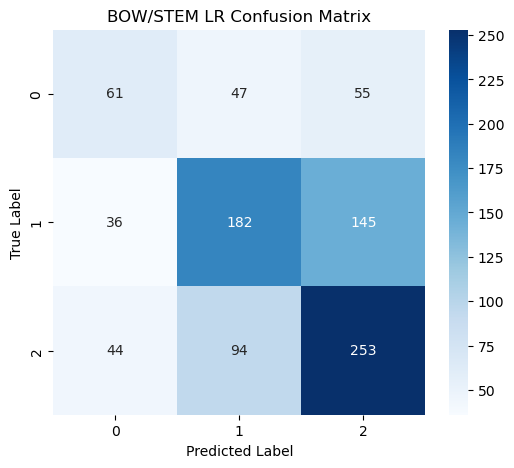

In [175]:
# Plot BOW Stem Confusion Matrix
bowstemlr_model.plot_confusion_matrix(X_stem_bowtest, y_stemtest, title="BOW/STEM LR Confusion Matrix")

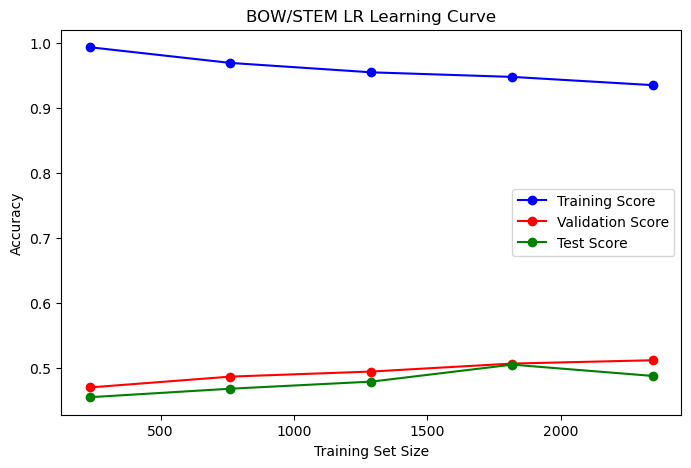

In [176]:
# Plot Learning Curve
bowstemlr_model.plot_learning_curve(X_stem_bowtrain, y_stemtrain, X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest, title="BOW/STEM LR Learning Curve")

In [177]:
# Initialize the Lemma BOW Model
bowlemmalr_model = LogisticRegressionClassifier()

In [178]:
# Train Lemma BOW Model
bowlemmalr_model.train_model(X_lemma_bowtrain, y_lemmatrain)

Best Parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


In [179]:
# Evaluate the Lemma BOW Model
bowlemmalr_model.evaluate_model(X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest)

Validation Accuracy: 0.4904109589041096
Validation ROC AUC: 0.6486

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.33      0.37       138
           1       0.49      0.45      0.47       288
           2       0.52      0.60      0.55       304

    accuracy                           0.49       730
   macro avg       0.47      0.46      0.46       730
weighted avg       0.49      0.49      0.49       730

Test Accuracy: 0.5474372955288986
Test ROC AUC: 0.6863

Test Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.42      0.43       163
           1       0.58      0.50      0.54       363
           2       0.56      0.64      0.60       391

    accuracy                           0.55       917
   macro avg       0.53      0.52      0.52       917
weighted avg       0.55      0.55      0.55       917



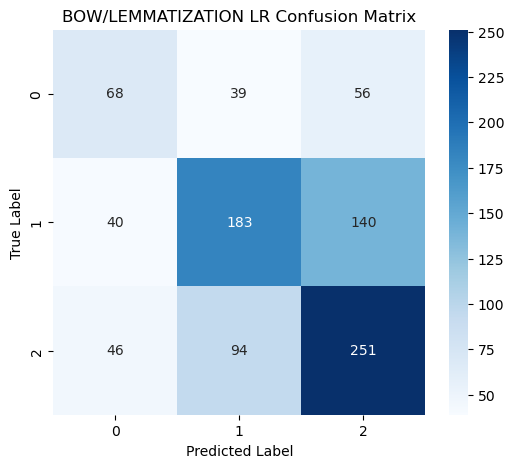

In [180]:
# Plot BOW Lemma Confusion Matrix
bowlemmalr_model.plot_confusion_matrix(X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION LR Confusion Matrix")

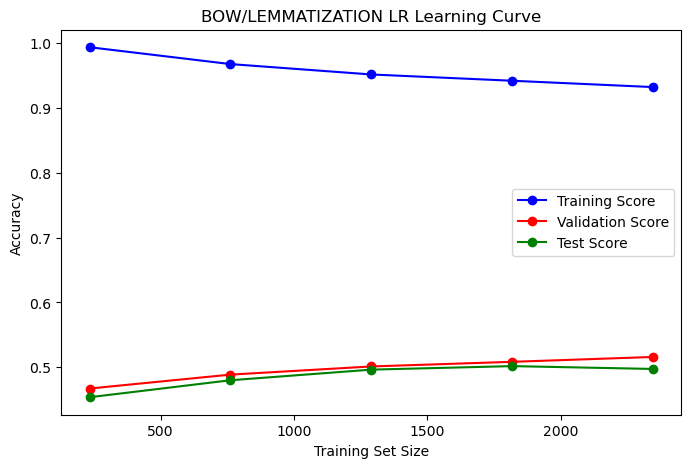

In [181]:
# Plot BOW Lemma Learning Curve
bowlemmalr_model.plot_learning_curve(X_lemma_bowtrain, y_lemmatrain, X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION LR Learning Curve")

### LOGISTIC REGRESSION: TFIDF

In [182]:
# Initialize the Stemmed TFIDF Model
tfidfstemlr_model = LogisticRegressionClassifier()

In [183]:
# Train Stemmed TFIDF Model
tfidfstemlr_model.train_model(X_stem_tfidftrain, y_stemtrain)

Best Parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}


In [184]:
# Evaluate the Stemmed TFIDF Model
tfidfstemlr_model.evaluate_model(X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest)

Validation Accuracy: 0.5
Validation ROC AUC: 0.6711

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.52      0.46       138
           1       0.49      0.51      0.50       288
           2       0.57      0.48      0.52       304

    accuracy                           0.50       730
   macro avg       0.49      0.50      0.49       730
weighted avg       0.51      0.50      0.50       730

Test Accuracy: 0.5234460196292258
Test ROC AUC: 0.6906

Test Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.47      0.41       163
           1       0.57      0.53      0.55       363
           2       0.57      0.54      0.56       391

    accuracy                           0.52       917
   macro avg       0.50      0.51      0.50       917
weighted avg       0.53      0.52      0.53       917



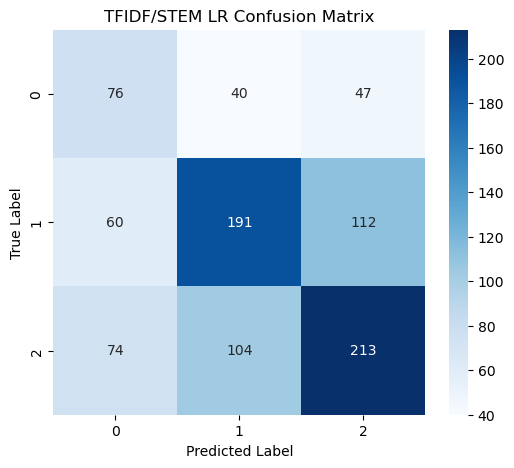

In [185]:
# Plot TFIDF Stem Logistic Regression Confusion Matrix
tfidfstemlr_model.plot_confusion_matrix(X_stem_tfidftest, y_stemtest, title="TFIDF/STEM LR Confusion Matrix")

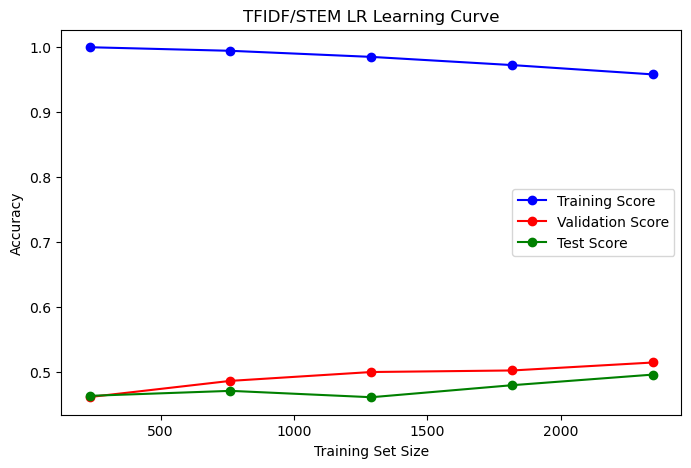

In [186]:
# Plot Learning Curve for TFIDF Stem Logistic regression
tfidfstemlr_model.plot_learning_curve(X_stem_tfidftrain, y_stemtrain, X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest, title="TFIDF/STEM LR Learning Curve")

In [187]:
# Initialize the Lemma TFIDF Model
tfidflemmalr_model = LogisticRegressionClassifier()

In [188]:
# Train Lemma TFIDF Model
tfidflemmalr_model.train_model(X_lemma_tfidftrain, y_lemmatrain)

Best Parameters: {'estimator__C': 0.1, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


In [189]:
# Evaluate the Lemma TFIDF Model
tfidflemmalr_model.evaluate_model(X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest)

Validation Accuracy: 0.5
Validation ROC AUC: 0.6598

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.47      0.44       138
           1       0.49      0.50      0.49       288
           2       0.56      0.52      0.54       304

    accuracy                           0.50       730
   macro avg       0.49      0.49      0.49       730
weighted avg       0.50      0.50      0.50       730

Test Accuracy: 0.5169029443838604
Test ROC AUC: 0.6862

Test Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.47      0.40       163
           1       0.59      0.53      0.55       363
           2       0.56      0.53      0.54       391

    accuracy                           0.52       917
   macro avg       0.50      0.51      0.50       917
weighted avg       0.53      0.52      0.52       917



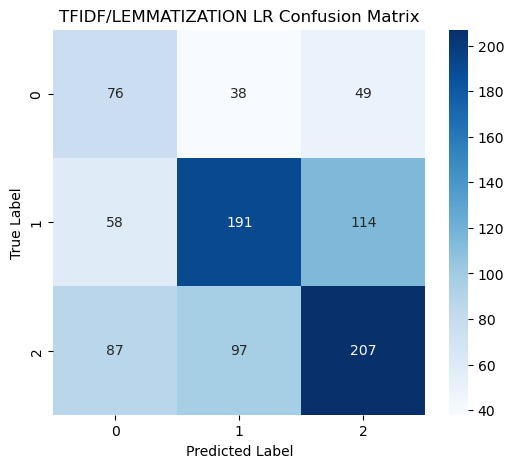

In [190]:
# Plot TFIDF Lemma Confusion Matrix
tfidflemmalr_model.plot_confusion_matrix(X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION LR Confusion Matrix")

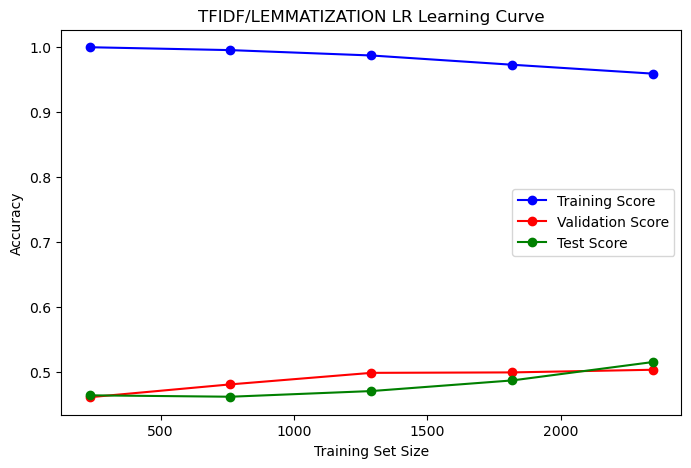

In [191]:
# Plot TFIDF Lemma Learning Curve
tfidflemmalr_model.plot_learning_curve(X_lemma_tfidftrain, y_lemmatrain, X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION LR Learning Curve")

### LOGISTIC REGRESSION WORD2VEC

In [192]:
# Initialize the Stemmed W2V Model
w2vstemlr_model = LogisticRegressionClassifier()

In [193]:
# Train Stemmed W2V Model
w2vstemlr_model.train_model(X_stem_w2vtrain, y_stemtrain)

C:\Users\eniha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\eniha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'estimator__C': 100, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}


In [194]:
# Evaluate the Stemmed W2V Model
w2vstemlr_model.evaluate_model(X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest)

Validation Accuracy: 0.18904109589041096
Validation ROC AUC: 0.4447

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.19      1.00      0.32       138
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00       304

    accuracy                           0.19       730
   macro avg       0.06      0.33      0.11       730
weighted avg       0.04      0.19      0.06       730

Test Accuracy: 0.1777535441657579
Test ROC AUC: 0.4487

Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       163
           1       0.00      0.00      0.00       363
           2       0.00      0.00      0.00       391

    accuracy                           0.18       917
   macro avg       0.06      0.33      0.10       917
weighted avg       0.03      0.18      0.05       917



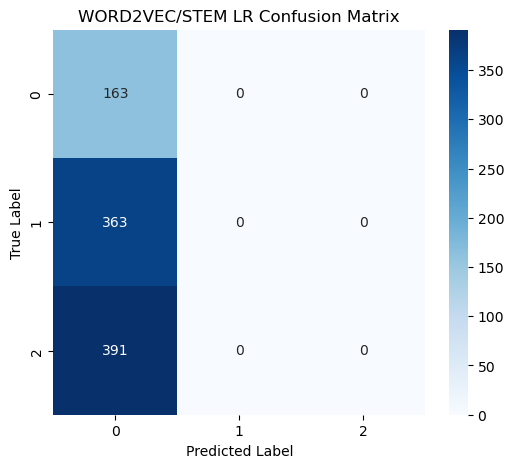

In [195]:
# Plot W2V Stem Logistic Regression Confusion Matrix
w2vstemlr_model.plot_confusion_matrix(X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM LR Confusion Matrix")

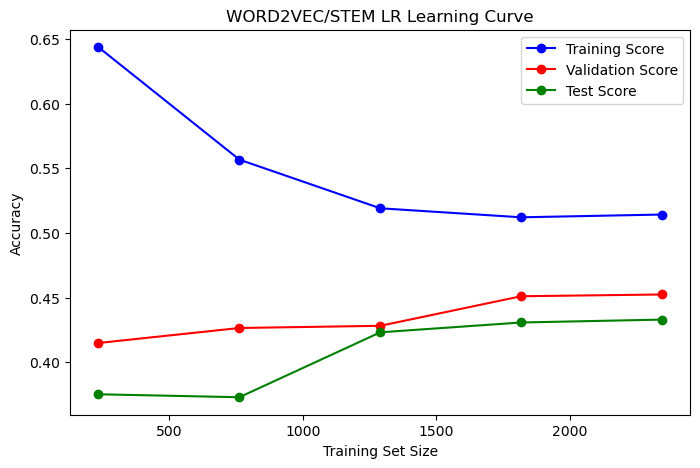

In [196]:
# Plot Learning Curve for W2V Stem Logistic regression
w2vstemlr_model.plot_learning_curve(X_stem_w2vtrain, y_stemtrain, X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM LR Learning Curve")

In [197]:
# Initialize the Lemma W2V LR Model
w2vlemmalr_model = LogisticRegressionClassifier()

In [198]:
# Train Lemma W2V LR Model
w2vlemmalr_model.train_model(X_lemma_w2vtrain, y_lemmatrain)

C:\Users\eniha\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Best Parameters: {'estimator__C': 100, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}


In [199]:
# Evaluate the Lemma W2V LR Model
w2vlemmalr_model.evaluate_model(X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest)

Validation Accuracy: 0.18904109589041096
Validation ROC AUC: 0.4627

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.19      1.00      0.32       138
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00       304

    accuracy                           0.19       730
   macro avg       0.06      0.33      0.11       730
weighted avg       0.04      0.19      0.06       730

Test Accuracy: 0.1777535441657579
Test ROC AUC: 0.5212

Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       163
           1       0.00      0.00      0.00       363
           2       0.00      0.00      0.00       391

    accuracy                           0.18       917
   macro avg       0.06      0.33      0.10       917
weighted avg       0.03      0.18      0.05       917



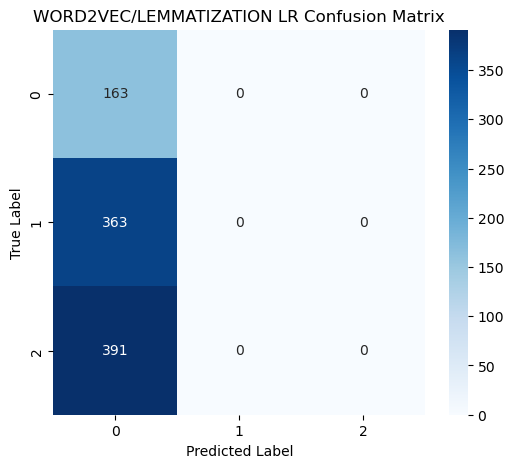

In [200]:
# Plot W2V Lemma LR Confusion Matrix
w2vlemmalr_model.plot_confusion_matrix(X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION LR Confusion Matrix")

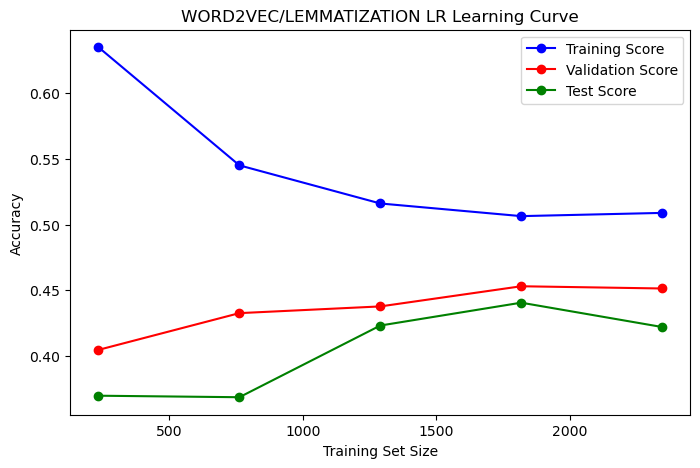

In [201]:
# Plot W2V Lemma LR Learning Curve
w2vlemmalr_model.plot_learning_curve(X_lemma_w2vtrain, y_lemmatrain, X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION LR Learning Curve")

**LOGISTIC REGRESSION: Lemma Word2Vec with PCA** 

In [202]:
# Initialize the Lemma W2V LR Model
w2vlemmapcalr_model = LogisticRegressionClassifier()

In [203]:
# Train Lemma W2V LR Model
w2vlemmapcalr_model.train_model(X_lemma_w2vpcatrain, y_lemmatrain)

Best Parameters: {'estimator__C': 10, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}


In [204]:
# Evaluate the Lemma W2V LR Model
w2vlemmapcalr_model.evaluate_model(X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest)

Validation Accuracy: 0.18904109589041096
Validation ROC AUC: 0.5350

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.19      1.00      0.32       138
           1       0.00      0.00      0.00       288
           2       0.00      0.00      0.00       304

    accuracy                           0.19       730
   macro avg       0.06      0.33      0.11       730
weighted avg       0.04      0.19      0.06       730

Test Accuracy: 0.1777535441657579
Test ROC AUC: 0.5370

Test Classification Report:
              precision    recall  f1-score   support

           0       0.18      1.00      0.30       163
           1       0.00      0.00      0.00       363
           2       0.00      0.00      0.00       391

    accuracy                           0.18       917
   macro avg       0.06      0.33      0.10       917
weighted avg       0.03      0.18      0.05       917



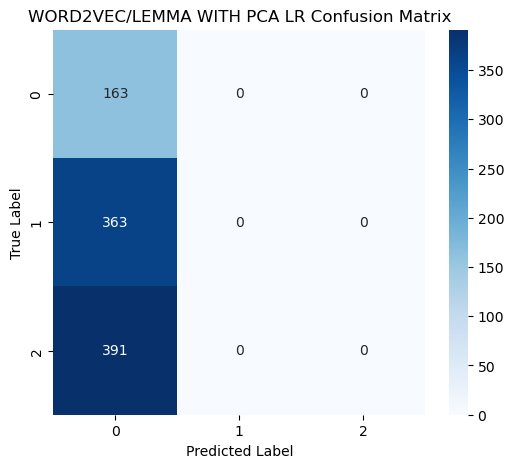

In [205]:
# Plot W2V Lemma LR Confusion Matrix
w2vlemmapcalr_model.plot_confusion_matrix(X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA LR Confusion Matrix")

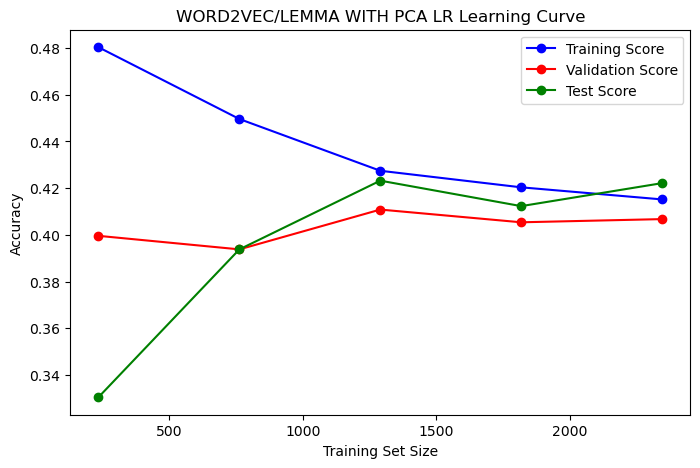

In [206]:
# Plot W2V Lemma LR Learning Curve
w2vlemmapcalr_model.plot_learning_curve(X_lemma_w2vpcatrain, y_lemmatrain, X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA LR Learning Curve")

## SUPPORT VECTOR MACHINE(SVM)

In [207]:
#Class for Support Vector Machine (SVM)
class SVMClassifier:
    def __init__(self):
        """
        Initialize the Support Vector Machine (SVM) model.
        """
        self.model = SVC(probability=True, class_weight='balanced', random_state=25)
        self.best_model = None  # stores the trained model after training
        
    #Method for training
    def train_model(self, X_train, y_train):
        """
        Train SVM using GridSearchCV and SMOTE for class balancing.
        """
        # Ensuring data is sparse format
        if not issparse(X_train):
            X_train = csr_matrix(X_train)

        # Applying SMOTE for balancing
        smote = SMOTE(random_state=25)
        X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

        # Define parameter grid
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 
                      'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}

        # Grid Search for Best Parameters
        grid_search = GridSearchCV(self.model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train_balanced, y_train_balanced)

        # Save best model
        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        
    #Method for evauating the validation and tests sets
    def evaluate_model(self, X_val, y_val, X_test, y_test):
        """
        Evaluate the trained model on validation and test sets.
        """
        if self.best_model is None:
            raise ValueError("Model is not trained. Call train_model() first.")

        # Ensuring data is in sparse format
        if not issparse(X_val):
            X_val = csr_matrix(X_val)
        if not issparse(X_test):
            X_test = csr_matrix(X_test)

        # Validation Predictions 
        y_val_pred = self.best_model.predict(X_val)
        y_val_prob = self.best_model.predict_proba(X_val)

        #Test predictions
        y_test_pred = self.best_model.predict(X_test)
        y_test_prob = self.best_model.predict_proba(X_test)

         # Compute ROC-AUC Score
        y_val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
        y_test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
        
        # Print reports
        #Validation sets
        print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
        print(f"Validation ROC AUC: {y_val_auc:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(y_val, y_val_pred, zero_division=0))

        #Tests sets
        print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
        print(f"Test ROC AUC: {y_test_auc:.4f}")
        print("\nTest Classification Report:")
        print(classification_report(y_test, y_test_pred, zero_division=0))
        
    #Method to plot confusion matrix
    def plot_confusion_matrix(self, X, y, title="Confusion Matrix"):
        """
        Plot confusion matrix.
        """
        y_pred = self.best_model.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y), yticklabels=set(y))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)
        plt.show()


    #Method to plot the learning curve
    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test, title="Learning Curve"):
        """
        Plot Learning Curve for Training, Validation, and Test Sets.
        """
        train_sizes, train_scores, val_scores = learning_curve(self.best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        _, _, test_scores = learning_curve(self.best_model, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training Score")
        plt.plot(train_sizes, val_mean, 'o-', color='red', label="Validation Score")
        plt.plot(train_sizes, test_mean, 'o-', color='green', label="Test Score")
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.show()


### SVM: BAG OF WORDS

In [208]:
# Initialize SVM Stemmed BOW Model
bowstemsvm_model = SVMClassifier()

In [209]:
# Train Stemmed BOw Model
bowstemsvm_model.train_model(X_stem_bowtrain, y_stemtrain)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [210]:
# Evaluate the Stemmed BOW Model
bowstemsvm_model.evaluate_model(X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest)

Validation Accuracy: 0.46164383561643835
Validation ROC AUC: 0.6366

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.05      0.09       138
           1       0.42      0.60      0.50       288
           2       0.51      0.51      0.51       304

    accuracy                           0.46       730
   macro avg       0.48      0.39      0.37       730
weighted avg       0.47      0.46      0.43       730

Test Accuracy: 0.5256270447110142
Test ROC AUC: 0.6650

Test Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.04      0.08       163
           1       0.49      0.64      0.56       363
           2       0.56      0.62      0.59       391

    accuracy                           0.53       917
   macro avg       0.56      0.43      0.41       917
weighted avg       0.55      0.53      0.49       917



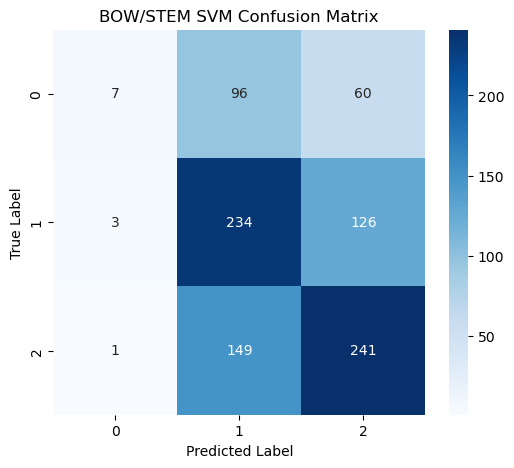

In [211]:
# Plot BOW Stem SVM Confusion Matrix
bowstemsvm_model.plot_confusion_matrix(X_stem_bowtest, y_stemtest, title="BOW/STEM SVM Confusion Matrix")

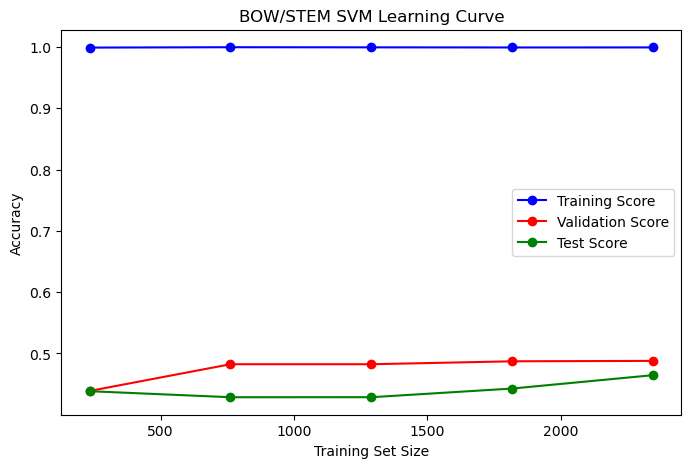

In [212]:
# Plot BOW Stem SVM Learning Curve
bowstemsvm_model.plot_learning_curve(X_stem_bowtrain, y_stemtrain, X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest, title="BOW/STEM SVM Learning Curve")

In [213]:
# Initialize SVM Lemma BOW Model
bowlemmasvm_model = SVMClassifier()

In [214]:
# Train Lemma BOW Model
bowlemmasvm_model.train_model(X_lemma_bowtrain, y_lemmatrain)

Best Parameters: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}


In [215]:
# Evaluate the Lemma BOW Model
bowlemmasvm_model.evaluate_model(X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest)

Validation Accuracy: 0.4575342465753425
Validation ROC AUC: 0.6261

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.03      0.06       138
           1       0.43      0.61      0.50       288
           2       0.50      0.51      0.50       304

    accuracy                           0.46       730
   macro avg       0.50      0.38      0.35       730
weighted avg       0.48      0.46      0.42       730

Test Accuracy: 0.5136314067611778
Test ROC AUC: 0.6567

Test Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.04      0.08       163
           1       0.48      0.64      0.55       363
           2       0.55      0.59      0.57       391

    accuracy                           0.51       917
   macro avg       0.52      0.43      0.40       917
weighted avg       0.52      0.51      0.47       917



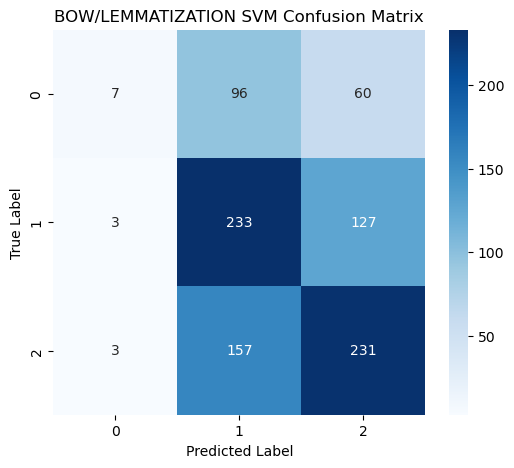

In [216]:
# Plot BOW Lemma SVM Confusion Matrix
bowlemmasvm_model.plot_confusion_matrix(X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION SVM Confusion Matrix")

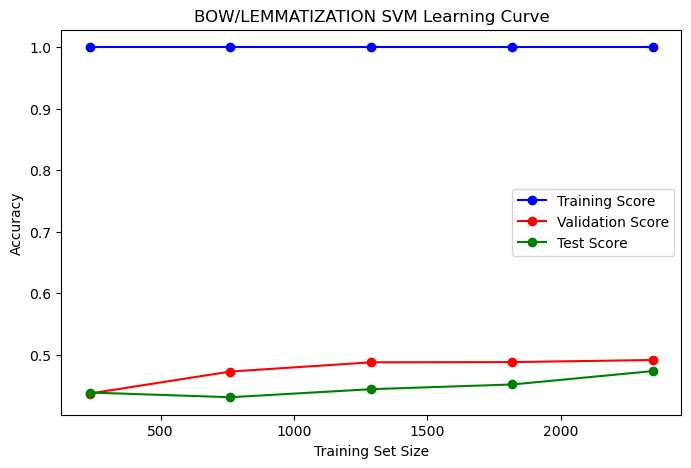

In [217]:
# Plot BOW Lemma SVM Learning Curve
bowlemmasvm_model.plot_learning_curve(X_lemma_bowtrain, y_lemmatrain, X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION SVM Learning Curve")

### SUPPORT VECTOR MACHINE: TFIDF

In [218]:
# Initialize the SVM Stemmed TFIDF Model
tfidfstemsvm_model = SVMClassifier()

In [219]:
# Train SVM Stemmed TFIDF Model
tfidfstemsvm_model.train_model(X_stem_tfidftrain, y_stemtrain)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [220]:
# Evaluate the SVM Stemmed TFIDF Model
tfidfstemsvm_model.evaluate_model(X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest)

Validation Accuracy: 0.4794520547945205
Validation ROC AUC: 0.6690

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.08      0.14       138
           1       0.48      0.43      0.45       288
           2       0.48      0.71      0.57       304

    accuracy                           0.48       730
   macro avg       0.49      0.41      0.39       730
weighted avg       0.49      0.48      0.44       730

Test Accuracy: 0.5441657579062159
Test ROC AUC: 0.6800

Test Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.19      0.30       163
           1       0.57      0.43      0.49       363
           2       0.52      0.80      0.63       391

    accuracy                           0.54       917
   macro avg       0.60      0.47      0.47       917
weighted avg       0.57      0.54      0.52       917



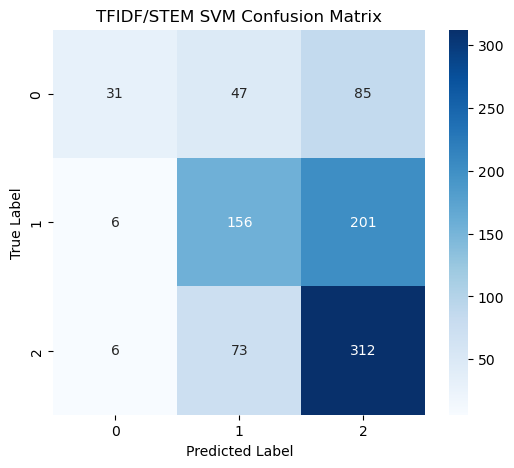

In [221]:
# Plot TFIDF Stem SVM Confusion Matrix
tfidfstemsvm_model.plot_confusion_matrix(X_stem_tfidftest, y_stemtest, title="TFIDF/STEM SVM Confusion Matrix")

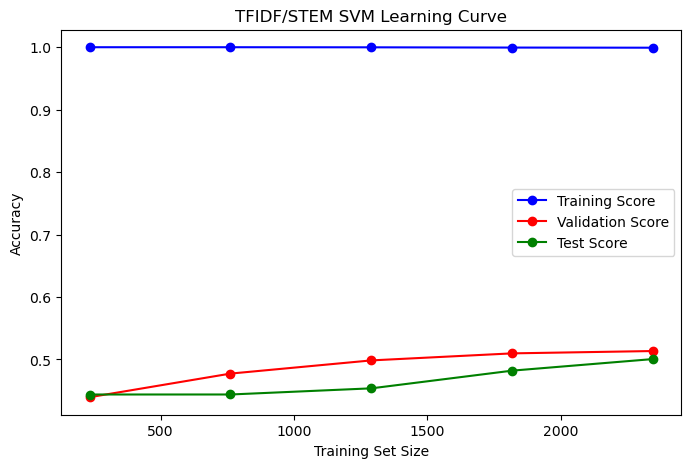

In [222]:
# Plot Learning Curve for TFIDF Stem SVM
tfidfstemsvm_model.plot_learning_curve(X_stem_tfidftrain, y_stemtrain, X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest, title="TFIDF/STEM SVM Learning Curve")

In [223]:
# Initialize the Lemma TFIDF SVM Model
tfidflemmasvm_model = SVMClassifier()

In [224]:
# Train Lemma TFIDF SVM Model
tfidflemmasvm_model.train_model(X_lemma_tfidftrain, y_lemmatrain)

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [225]:
# Evaluate the Lemma TFIDF SVM Model
tfidflemmasvm_model.evaluate_model(X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest)

Validation Accuracy: 0.473972602739726
Validation ROC AUC: 0.6583

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.09      0.16       138
           1       0.47      0.43      0.45       288
           2       0.47      0.69      0.56       304

    accuracy                           0.47       730
   macro avg       0.48      0.40      0.39       730
weighted avg       0.48      0.47      0.44       730

Test Accuracy: 0.5539803707742639
Test ROC AUC: 0.6780

Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.18      0.30       163
           1       0.60      0.46      0.52       363
           2       0.52      0.80      0.63       391

    accuracy                           0.55       917
   macro avg       0.62      0.48      0.48       917
weighted avg       0.59      0.55      0.53       917



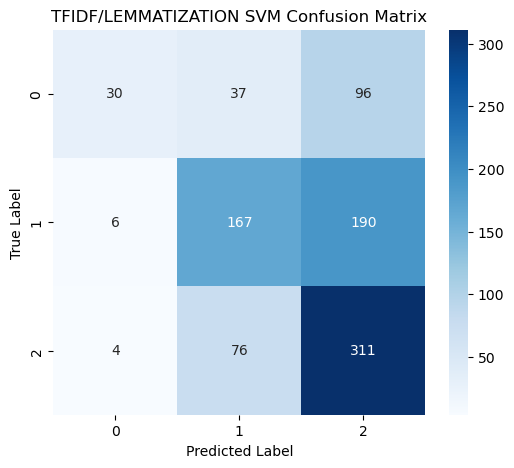

In [226]:
# Plot TFIDF Lemma SVM Confusion Matrix
tfidflemmasvm_model.plot_confusion_matrix(X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION SVM Confusion Matrix")

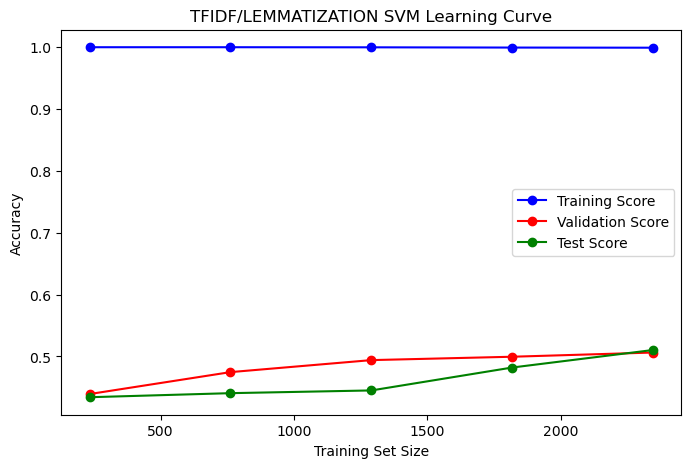

In [227]:
# Plot TFIDF Lemma SVM Learning Curve
tfidflemmasvm_model.plot_learning_curve(X_lemma_tfidftrain, y_lemmatrain, X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION SVM Learning Curve")

### SUPPORT VECTOR MACHINE: WORD2VEC

In [228]:
# Initialize the Stemmed W2V SVM Model
w2vstemsvm_model = SVMClassifier()

In [229]:
# Train Stemmed W2V SVM Model
w2vstemsvm_model.train_model(X_stem_w2vtrain, y_stemtrain)

Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [230]:
# Evaluate the Stemmed W2V SVM Model
w2vstemsvm_model.evaluate_model(X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest)

Validation Accuracy: 0.41643835616438357
Validation ROC AUC: 0.4960

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       288
           2       0.42      1.00      0.59       304

    accuracy                           0.42       730
   macro avg       0.14      0.33      0.20       730
weighted avg       0.17      0.42      0.24       730

Test Accuracy: 0.42639040348964014
Test ROC AUC: 0.4948

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



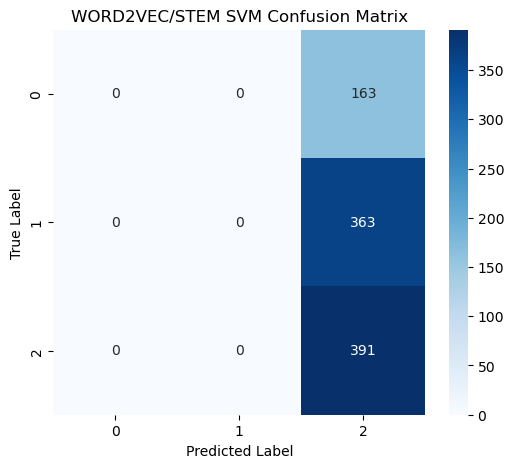

In [231]:
# Plot W2V Stem SVM Confusion Matrix
w2vstemsvm_model.plot_confusion_matrix(X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM SVM Confusion Matrix")

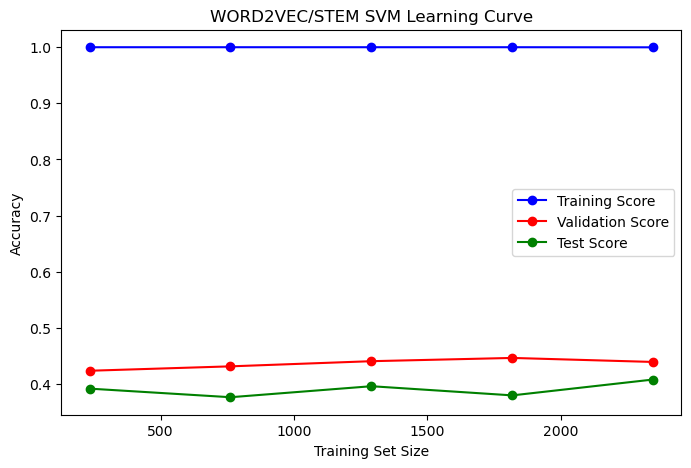

In [232]:
# Plot Learning Curve for W2V Stem SVM
w2vstemsvm_model.plot_learning_curve(X_stem_w2vtrain, y_stemtrain, X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM SVM Learning Curve")

In [233]:
# Initialize the Lemma W2V SVM Model
w2vlemmasvm_model = SVMClassifier()

In [234]:
# Train Lemma W2V SVM Model
w2vlemmasvm_model.train_model(X_lemma_w2vtrain, y_lemmatrain)

Best Parameters: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}


In [235]:
# Evaluate the Lemma W2V SVM Model
w2vlemmasvm_model.evaluate_model(X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest)

Validation Accuracy: 0.41643835616438357
Validation ROC AUC: 0.4993

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       288
           2       0.42      1.00      0.59       304

    accuracy                           0.42       730
   macro avg       0.14      0.33      0.20       730
weighted avg       0.17      0.42      0.24       730

Test Accuracy: 0.42639040348964014
Test ROC AUC: 0.5000

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



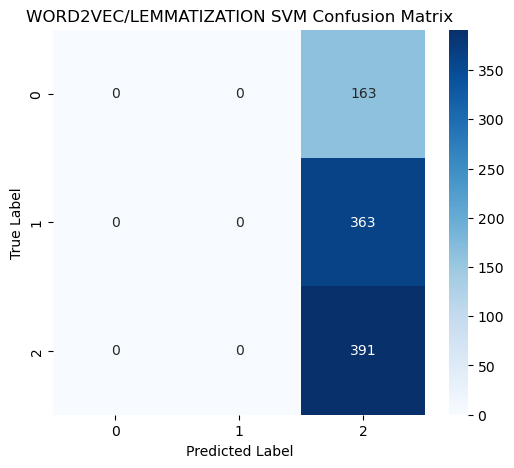

In [236]:
# Plot W2V Lemma SVM Confusion Matrix
w2vlemmasvm_model.plot_confusion_matrix(X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION SVM Confusion Matrix")

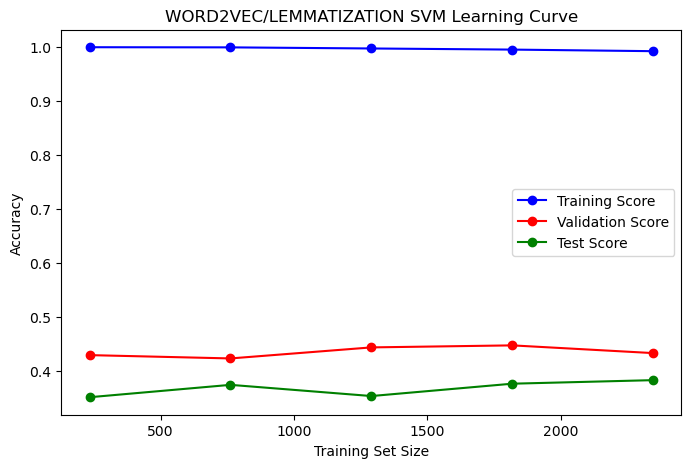

In [237]:
# Plot W2V Lemma SVM Learning Curve
w2vlemmasvm_model.plot_learning_curve(X_lemma_w2vtrain, y_lemmatrain, X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION SVM Learning Curve")

**SVM: Lemma Word2Vec with PCA**

In [238]:
# Initialize the Lemma W2V SVM Model
w2vlemmapcasvm_model = SVMClassifier()

In [239]:
# Train Lemma W2V SVM Model
w2vlemmapcasvm_model.train_model(X_lemma_w2vpcatrain, y_lemmatrain)

Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}


In [240]:
# Evaluate the Lemma W2V SVM Model
w2vlemmapcasvm_model.evaluate_model(X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest)

Validation Accuracy: 0.41643835616438357
Validation ROC AUC: 0.5190

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       288
           2       0.42      1.00      0.59       304

    accuracy                           0.42       730
   macro avg       0.14      0.33      0.20       730
weighted avg       0.17      0.42      0.24       730

Test Accuracy: 0.42639040348964014
Test ROC AUC: 0.4791

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



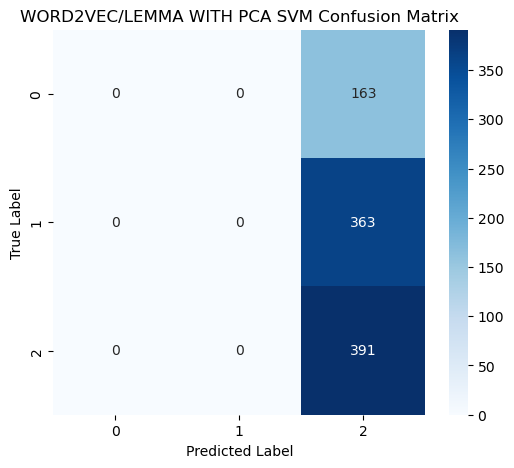

In [241]:
# Plot W2V Lemma SVM Confusion Matrix
w2vlemmapcasvm_model.plot_confusion_matrix(X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA SVM Confusion Matrix")

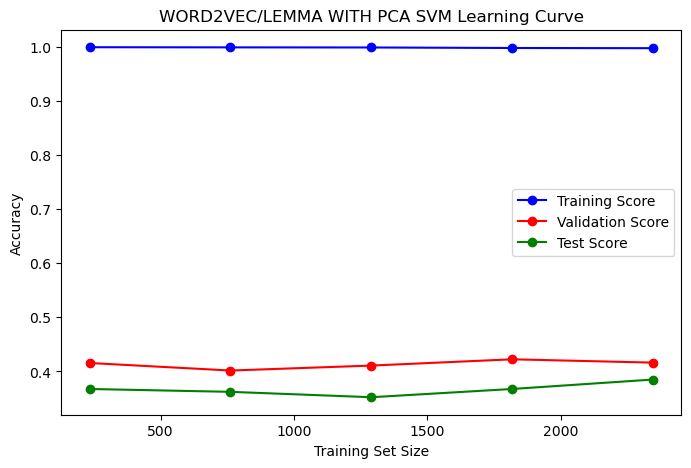

In [242]:
# Plot W2V Lemma SVM Learning Curve
w2vlemmapcasvm_model.plot_learning_curve(X_lemma_w2vpcatrain, y_lemmatrain, X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA SVM Learning Curve")

## RANDOM FOREST

In [243]:
#Class for Random Forest
class RandomForestClassifierModel:
    def __init__(self):
        """
        Initialize the Random Forest model.
        """
        self.model = RandomForestClassifier(class_weight='balanced', random_state=25)
        self.best_model = None  #stores the trained model after training

    #Method for trainning    
    def train_model(self, X_train, y_train):
        """
        Train Random Forest using GridSearchCV.
        """
        # Ensuring data is in sparse format
        if not issparse(X_train):
            X_train = csr_matrix(X_train)

        # Define parameter grid
        param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20],
                      'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]
                     }

        # Perform Grid Search
        grid_search = GridSearchCV(self.model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Save best model
        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)

        
    #Method for evaluation    
    def evaluate_model(self, X_val, y_val, X_test, y_test):
        """
        Evaluate the trained model on validation and test sets.
        """
        if self.best_model is None:
            raise ValueError("Model is not trained. Call train_model() first.")

        # Ensuring data is sparse format
        if not issparse(X_val):
            X_val = csr_matrix(X_val)
        if not issparse(X_test):
            X_test = csr_matrix(X_test)

        # Predictions
        y_val_pred = self.best_model.predict(X_val)
        y_val_prob = self.best_model.predict_proba(X_val)

        y_test_pred = self.best_model.predict(X_test)
        y_test_prob = self.best_model.predict_proba(X_test)

        
        # Compute ROC-AUC Score
        y_val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
        y_test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')
        
        
        # Print Reports
        #Validation sets
        print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
        print(f"Validation ROC AUC: {y_val_auc:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(y_val, y_val_pred, zero_division=0))

        #Tests sets
        print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
        print(f"Test ROC AUC: {y_test_auc:.4f}")
        print("\nTest Classification Report:")
        print(classification_report(y_test, y_test_pred, zero_division=0))
        
        
    #Method to plot Feature importance    
    def plot_feature_importance(self, feature_names, top_n=10):
        """
        Plot feature importance.
        """
        importances = self.best_model.feature_importances_
        indices = np.argsort(importances)[-top_n:]  # Get top N important features

        plt.figure(figsize=(8, 5))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Top Feature Importance')
        plt.show()

        
    #Method to plot the Confusion Matrix    
    def plot_confusion_matrix(self, X, y, title="Confusion Matrix"):
        """
        Plot confusion matrix.
        """
        y_pred = self.best_model.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y), yticklabels=set(y))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)
        plt.show()

    #Method to plot the learning curve
    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test, title="Learning Curve"):
        """
        Plot Learning Curve for Training, Validation, and Test Sets.
        """
        train_sizes, train_scores, val_scores = learning_curve(self.best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        _, _, test_scores = learning_curve(self.best_model, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training Score")
        plt.plot(train_sizes, val_mean, 'o-', color='red', label="Validation Score")
        plt.plot(train_sizes, test_mean, 'o-', color='green', label="Test Score")
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.show()


### RANDOM FOREST: BAG OF WORDS

In [244]:
# Initialize the Stemmed BOW RF Model
bowstemrf_model = RandomForestClassifierModel()

In [245]:
# Train Stemmed BOw RF Model
bowstemrf_model.train_model(X_stem_bowtrain, y_stemtrain)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


In [246]:
# Evaluate the Stemmed BOW RF Model
bowstemrf_model.evaluate_model(X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest)

Validation Accuracy: 0.4986301369863014
Validation ROC AUC: 0.6862

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.30      0.37       138
           1       0.48      0.49      0.48       288
           2       0.52      0.60      0.56       304

    accuracy                           0.50       730
   macro avg       0.49      0.46      0.47       730
weighted avg       0.50      0.50      0.49       730

Test Accuracy: 0.5463467829880043
Test ROC AUC: 0.6761

Test Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.29      0.38       163
           1       0.54      0.52      0.53       363
           2       0.55      0.67      0.61       391

    accuracy                           0.55       917
   macro avg       0.54      0.50      0.51       917
weighted avg       0.54      0.55      0.54       917



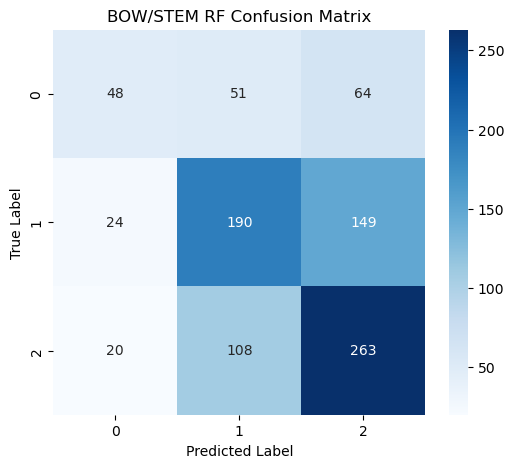

In [247]:
# Plot BOW Stem RF Confusion Matrix
bowstemrf_model.plot_confusion_matrix(X_stem_bowtest, y_stemtest, title="BOW/STEM RF Confusion Matrix")

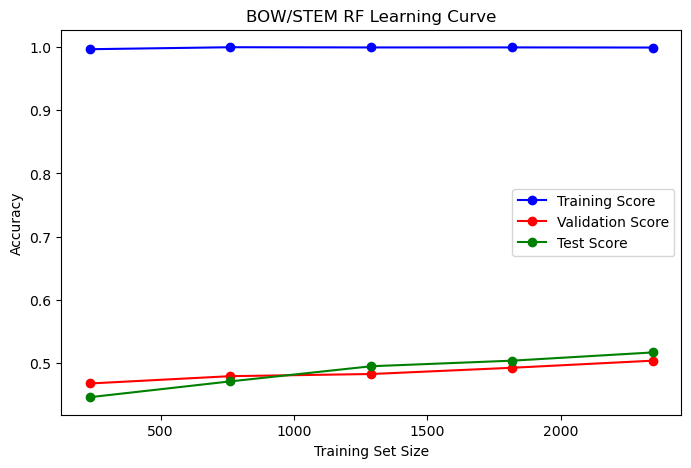

In [248]:
# Plot Stemmed BOW RF Learning Curve
bowstemrf_model.plot_learning_curve(X_stem_bowtrain, y_stemtrain, X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest, title="BOW/STEM RF Learning Curve")

In [249]:
# Initialize the Lemma BOW RF Model
bowlemmarf_model =  RandomForestClassifierModel()

In [250]:
# Train Lemma BOW RF Model
bowlemmarf_model.train_model(X_lemma_bowtrain, y_lemmatrain)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [251]:
# Evaluate the Lemma BOW RF Model
bowlemmarf_model.evaluate_model(X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest)

Validation Accuracy: 0.5013698630136987
Validation ROC AUC: 0.6838

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.41      0.43       138
           1       0.49      0.44      0.47       288
           2       0.53      0.60      0.56       304

    accuracy                           0.50       730
   macro avg       0.49      0.48      0.48       730
weighted avg       0.50      0.50      0.50       730

Test Accuracy: 0.5539803707742639
Test ROC AUC: 0.6850

Test Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.37      0.41       163
           1       0.57      0.52      0.54       363
           2       0.57      0.66      0.61       391

    accuracy                           0.55       917
   macro avg       0.53      0.52      0.52       917
weighted avg       0.55      0.55      0.55       917



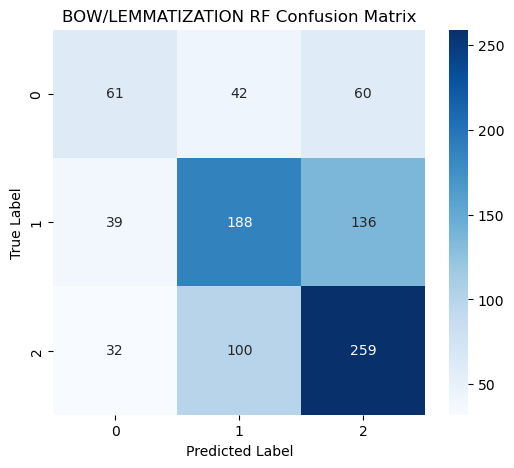

In [252]:
# Plot BOW Lemma RF Confusion Matrix
bowlemmarf_model.plot_confusion_matrix(X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION RF Confusion Matrix")

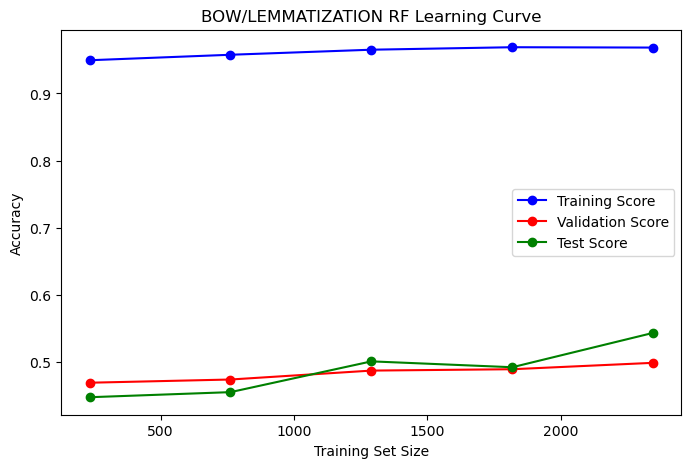

In [253]:
# Plot BOW Lemma RF Learning Curve
bowlemmarf_model.plot_learning_curve(X_lemma_bowtrain, y_lemmatrain, X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION RF Learning Curve")

### RANDOM FOREST: TFIDF

In [254]:
# Initialize the Stemmed TFIDF RF Model
tfidfstemrf_model =  RandomForestClassifierModel()

In [255]:
# Train Stemmed TFIDF RF Model
tfidfstemrf_model.train_model(X_stem_tfidftrain, y_stemtrain)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [256]:
# Evaluate the Stemmed TFIDF RF Model
tfidfstemrf_model.evaluate_model(X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest)

Validation Accuracy: 0.5260273972602739
Validation ROC AUC: 0.6973

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.33      0.40       138
           1       0.50      0.54      0.52       288
           2       0.55      0.61      0.58       304

    accuracy                           0.53       730
   macro avg       0.52      0.49      0.50       730
weighted avg       0.53      0.53      0.52       730

Test Accuracy: 0.5387131952017448
Test ROC AUC: 0.6931

Test Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.34      0.41       163
           1       0.53      0.53      0.53       363
           2       0.55      0.63      0.59       391

    accuracy                           0.54       917
   macro avg       0.54      0.50      0.51       917
weighted avg       0.54      0.54      0.53       917



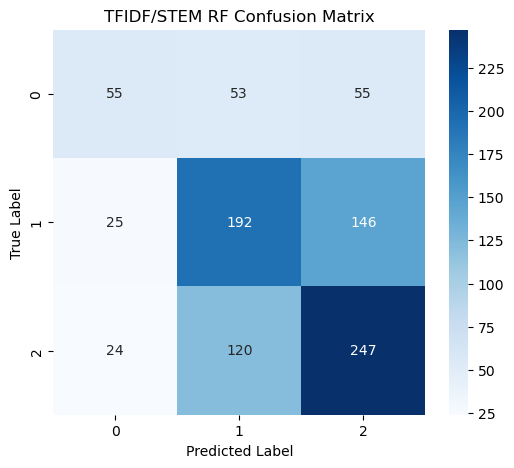

In [257]:
# Plot TFIDF Stem RF Matrix
tfidfstemrf_model.plot_confusion_matrix(X_stem_tfidftest, y_stemtest, title="TFIDF/STEM RF Confusion Matrix")

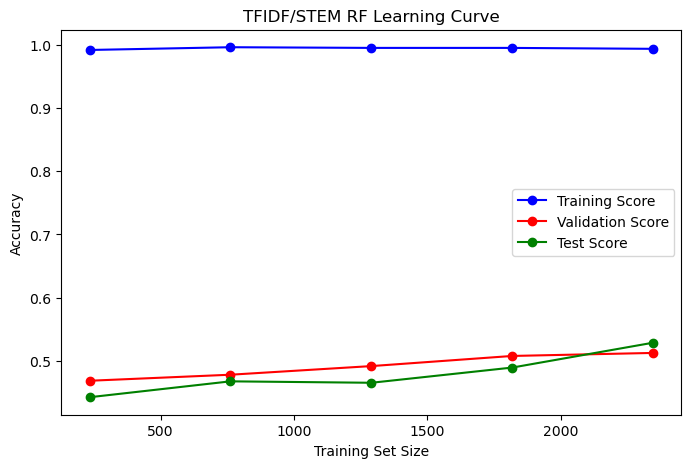

In [258]:
# Plot Learning Curve for TFIDF Stem RF
tfidfstemrf_model.plot_learning_curve(X_stem_tfidftrain, y_stemtrain, X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest, title="TFIDF/STEM RF Learning Curve")

In [259]:
# Initialize the Lemma TFIDF RF Model
tfidflemmarf_model = RandomForestClassifierModel()

In [260]:
# Train Lemma TFIDF RF Model
tfidflemmarf_model.train_model(X_lemma_tfidftrain, y_lemmatrain)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [261]:
# Evaluate the Lemma TFIDF RF Model
tfidflemmarf_model.evaluate_model(X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest)

Validation Accuracy: 0.5027397260273972
Validation ROC AUC: 0.6847

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.36      0.43       138
           1       0.48      0.48      0.48       288
           2       0.52      0.59      0.55       304

    accuracy                           0.50       730
   macro avg       0.50      0.48      0.49       730
weighted avg       0.50      0.50      0.50       730

Test Accuracy: 0.5463467829880043
Test ROC AUC: 0.6716

Test Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.33      0.39       163
           1       0.56      0.54      0.55       363
           2       0.55      0.64      0.59       391

    accuracy                           0.55       917
   macro avg       0.53      0.50      0.51       917
weighted avg       0.54      0.55      0.54       917



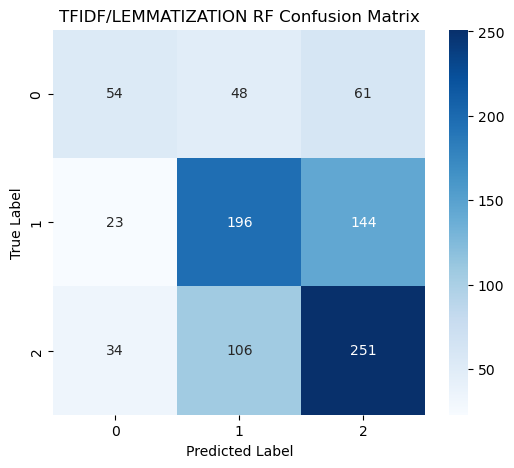

In [262]:
# Plot TFIDF Lemma RF Confusion Matrix
tfidflemmarf_model.plot_confusion_matrix(X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION RF Confusion Matrix")

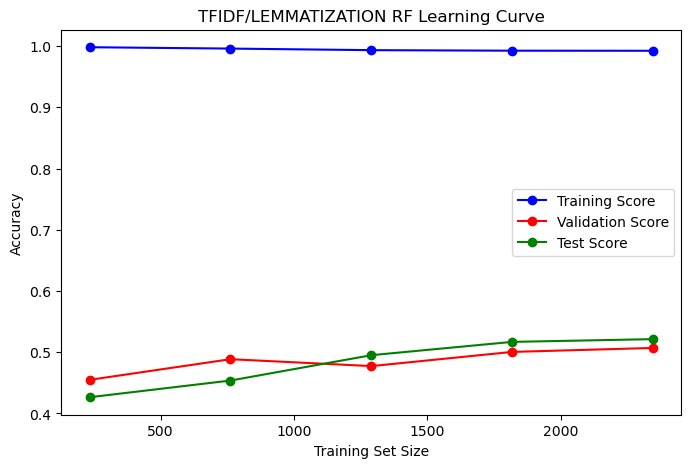

In [263]:
# Plot TFIDF Lemma RF Learning Curve
tfidflemmarf_model.plot_learning_curve(X_lemma_tfidftrain, y_lemmatrain, X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION RF Learning Curve")

### RANDOM FOREST: WORD2VEC

In [264]:
# Initialize the Stemmed W2V RF Model
w2vstemrf_model = RandomForestClassifierModel()

In [265]:
# Train Stemmed W2V RF Model
w2vstemrf_model.train_model(X_stem_w2vtrain, y_stemtrain)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


In [266]:
# Evaluate the Stemmed W2V RF Model
w2vstemrf_model.evaluate_model(X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest)

Validation Accuracy: 0.3835616438356164
Validation ROC AUC: 0.4680

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.37      0.25      0.30       288
           2       0.39      0.68      0.50       304

    accuracy                           0.38       730
   macro avg       0.25      0.31      0.26       730
weighted avg       0.31      0.38      0.32       730

Test Accuracy: 0.42311886586695746
Test ROC AUC: 0.5111

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.41      0.66      0.50       363
           2       0.45      0.38      0.41       391

    accuracy                           0.42       917
   macro avg       0.29      0.35      0.31       917
weighted avg       0.35      0.42      0.38       917



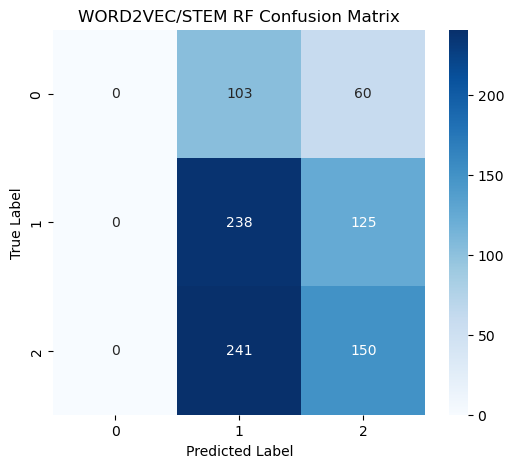

In [267]:
# Plot W2V Stem RF Confusion Matrix
w2vstemrf_model.plot_confusion_matrix(X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM RF Confusion Matrix")

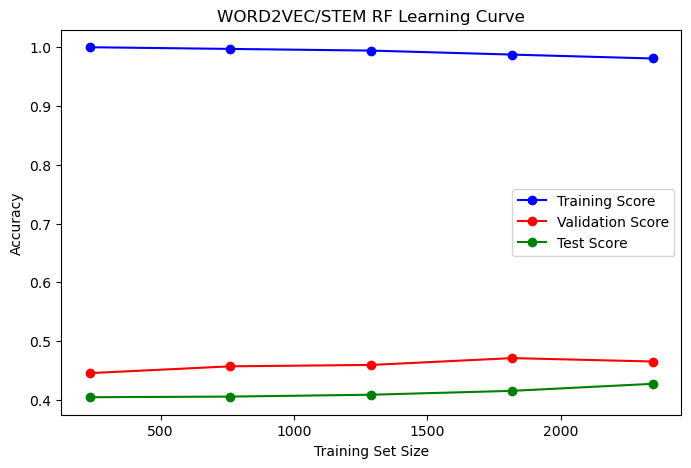

In [268]:
# Plot Learning Curve for W2V Stem RF
w2vstemrf_model.plot_learning_curve(X_stem_w2vtrain, y_stemtrain, X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM RF Learning Curve")

In [269]:
# Initialize the Lemma W2V RF Model
w2vlemmarf_model = RandomForestClassifierModel()

In [270]:
# Train Lemma W2V RF Model
w2vlemmarf_model.train_model(X_lemma_w2vtrain, y_lemmatrain)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [271]:
# Evaluate the Lemma W2V RF Model
w2vlemmarf_model.evaluate_model(X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest)

Validation Accuracy: 0.41643835616438357
Validation ROC AUC: 0.4882

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       288
           2       0.42      1.00      0.59       304

    accuracy                           0.42       730
   macro avg       0.14      0.33      0.20       730
weighted avg       0.17      0.42      0.25       730

Test Accuracy: 0.42639040348964014
Test ROC AUC: 0.5473

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



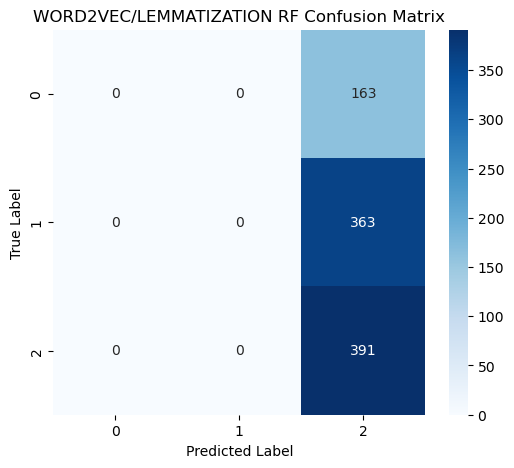

In [272]:
# Plot W2V Lemma RF Confusion Matrix
w2vlemmarf_model.plot_confusion_matrix(X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION RF Confusion Matrix")

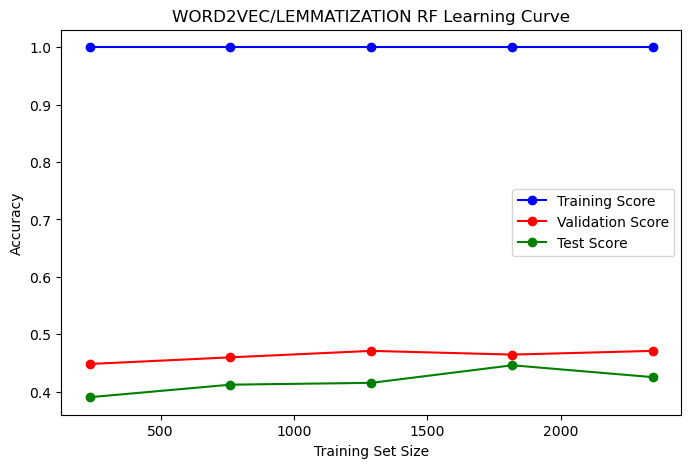

In [273]:
# Plot W2V Lemma RF Learning Curve
w2vlemmarf_model.plot_learning_curve(X_lemma_w2vtrain, y_lemmatrain, X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION RF Learning Curve")

**RANDOM FOREST: Lemma Word2Vec with PCA**

In [274]:
# Initialize the Lemma W2V RF Model
w2vlemmapcarf_model = RandomForestClassifierModel()

In [275]:
# Train Lemma W2V RF Model
w2vlemmapcarf_model.train_model(X_lemma_w2vpcatrain, y_lemmatrain)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [276]:
# Evaluate the Lemma W2V RF Model
w2vlemmapcarf_model.evaluate_model(X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest)

Validation Accuracy: 0.39452054794520547
Validation ROC AUC: 0.4777

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.39      1.00      0.57       288
           2       0.00      0.00      0.00       304

    accuracy                           0.39       730
   macro avg       0.13      0.33      0.19       730
weighted avg       0.16      0.39      0.22       730

Test Accuracy: 0.39585605234460197
Test ROC AUC: 0.5025

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.40      1.00      0.57       363
           2       0.00      0.00      0.00       391

    accuracy                           0.40       917
   macro avg       0.13      0.33      0.19       917
weighted avg       0.16      0.40      0.22       917



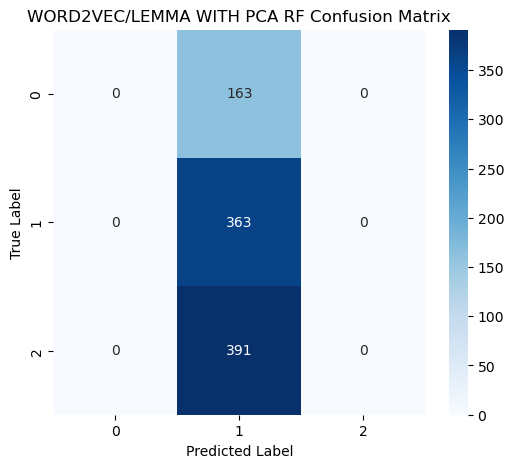

In [277]:
# Plot W2V Lemma RF Confusion Matrix
w2vlemmapcarf_model.plot_confusion_matrix(X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA RF Confusion Matrix")

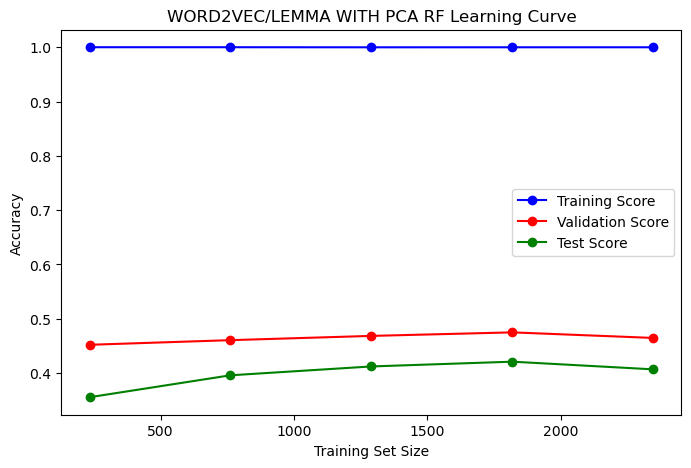

In [278]:
# Plot W2V Lemma RF Learning Curve
w2vlemmapcarf_model.plot_learning_curve(X_lemma_w2vpcatrain, y_lemmatrain, X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA RF Learning Curve")

## GRADIENT BOOST

In [279]:
#Class for Gradient Boost
class GradientBoostingClassifierModel:
    def __init__(self):
        """
        Initialize the XGBoost model.
        """
        self.model = XGBClassifier(objective='multi:softprob', use_label_encoder=False, 
                                   eval_metric='mlogloss', random_state=25)
        self.best_model = None  #stores the trained model after training

        
    #Method for trainning    
    def train_model(self, X_train, y_train):
        """
        Train Gradient Boosting (XGBoost) using GridSearchCV.
        """

        # Ensuring data is sparse format
        if not issparse(X_train):
            X_train = csr_matrix(X_train)

        param_grid = {
            'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2], 
            'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}

        grid_search = GridSearchCV(self.model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)

        
    #Method for evaluation    
    def evaluate_model(self, X_val, y_val, X_test, y_test):
        """
        Evaluate the trained model on validation and test sets.
        """
        if self.best_model is None:
            raise ValueError("Model is not trained. Call train_model() first.")

        if not issparse(X_val):
            X_val = csr_matrix(X_val)
        if not issparse(X_test):
            X_test = csr_matrix(X_test)

        #Predictions
        y_val_pred = self.best_model.predict(X_val)
        y_val_prob = self.best_model.predict_proba(X_val)

        y_test_pred = self.best_model.predict(X_test)
        y_test_prob = self.best_model.predict_proba(X_test)

       
        # Compute ROC-AUC Score
        y_val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
        y_test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

        
        # Print Reports
        #Validation sets
        print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
        print(f"Validation ROC AUC: {y_val_auc:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(y_val, y_val_pred, zero_division=0))

        #Tests sets
        print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
        print(f"Test ROC AUC: {y_test_auc:.4f}")
        print("\nTest Classification Report:")
        print(classification_report(y_test, y_test_pred, zero_division=0))
        
        
    #Method to plot Feature importance 
    def plot_feature_importance(self, feature_names, top_n=10):
        """
        Plot feature importance.
        """
        importances = self.best_model.feature_importances_
        indices = np.argsort(importances)[-top_n:]

        plt.figure(figsize=(8, 5))
        plt.barh(range(len(indices)), importances[indices], align='center')
        plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
        plt.xlabel('Feature Importance')
        plt.title('Top Feature Importance')
        plt.show()

        
    #Method to plot the Confusion Matrix 
    def plot_confusion_matrix(self, X, y, title="Confusion Matrix"):
        """
        Plot confusion matrix.
        """
        y_pred = self.best_model.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y), yticklabels=set(y))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)
        plt.show()
        
        
    #Method to plot the learning curve
    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test, title="Learning Curve"):
        """
        Plot Learning Curve for Training, Validation, and Test Sets.
        """
        train_sizes, train_scores, val_scores = learning_curve(self.best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        _, _, test_scores = learning_curve(self.best_model, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training Score")
        plt.plot(train_sizes, val_mean, 'o-', color='red', label="Validation Score")
        plt.plot(train_sizes, test_mean, 'o-', color='green', label="Test Score")
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.show()


### GRADIENT BOOST: BAG OF WORDS

In [280]:
# Initialize the Stemmed BOW GBoost Model
bowstemgboost_model = GradientBoostingClassifierModel()

In [281]:
# Train Stemmed BOW GBoost Model
bowstemgboost_model.train_model(X_stem_bowtrain, y_stemtrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:11:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}


In [282]:
# Evaluate the Stemmed BOW GBoost Model
bowstemgboost_model.evaluate_model(X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest)

Validation Accuracy: 0.5027397260273972
Validation ROC AUC: 0.6785

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.18      0.26       138
           1       0.50      0.56      0.53       288
           2       0.51      0.60      0.55       304

    accuracy                           0.50       730
   macro avg       0.49      0.45      0.45       730
weighted avg       0.50      0.50      0.49       730

Test Accuracy: 0.5398037077426391
Test ROC AUC: 0.6884

Test Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.26      0.36       163
           1       0.53      0.57      0.55       363
           2       0.55      0.63      0.58       391

    accuracy                           0.54       917
   macro avg       0.55      0.49      0.50       917
weighted avg       0.54      0.54      0.53       917



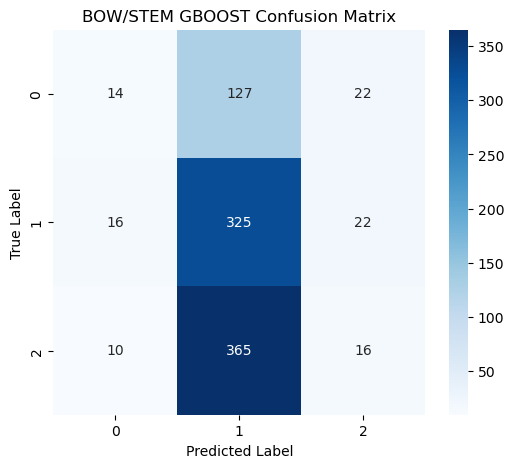

In [283]:
# Plot BOW Stem GBoost Confusion Matrix
bowstemgboost_model.plot_confusion_matrix(X_stem_bowtest, y_stemtest, title="BOW/STEM GBOOST Confusion Matrix")

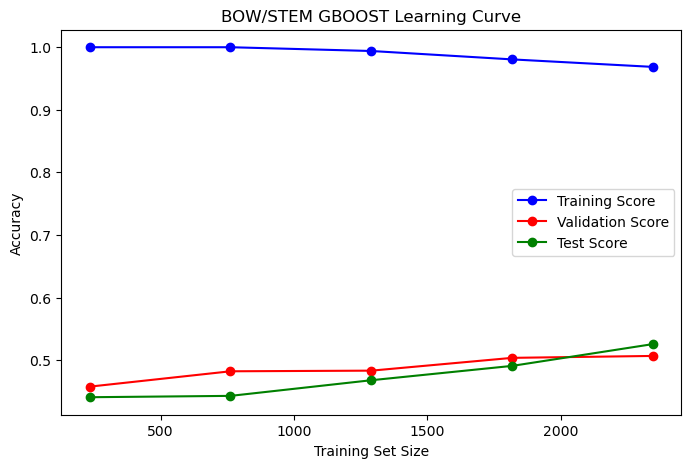

In [284]:
# Plot Stemmed BOW GBoost Learning Curve
bowstemgboost_model.plot_learning_curve(X_stem_bowtrain, y_stemtrain, X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest, title="BOW/STEM GBOOST Learning Curve")

In [285]:
# Initialize the Lemma BOW GBoost Model
bowlemmagboost_model = GradientBoostingClassifierModel()

In [286]:
# Train Lemma BOW GBoost Model
bowlemmagboost_model.train_model(X_lemma_bowtrain, y_lemmatrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:29:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


In [287]:
# Evaluate the Lemma BOW GBoost Model
bowlemmagboost_model.evaluate_model(X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest)

Validation Accuracy: 0.5
Validation ROC AUC: 0.6762

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.17      0.26       138
           1       0.49      0.55      0.51       288
           2       0.51      0.61      0.56       304

    accuracy                           0.50       730
   macro avg       0.50      0.44      0.44       730
weighted avg       0.50      0.50      0.48       730

Test Accuracy: 0.5441657579062159
Test ROC AUC: 0.6950

Test Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.25      0.35       163
           1       0.54      0.56      0.55       363
           2       0.54      0.65      0.59       391

    accuracy                           0.54       917
   macro avg       0.57      0.49      0.50       917
weighted avg       0.55      0.54      0.53       917



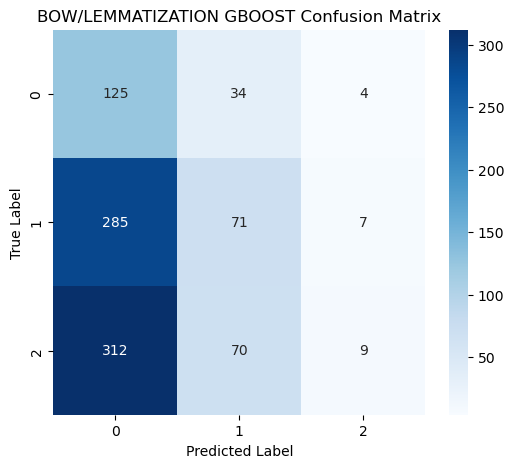

In [288]:
# Plot BOW Lemma GBoost Confusion Matrix
bowlemmagboost_model.plot_confusion_matrix(X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION GBOOST Confusion Matrix")

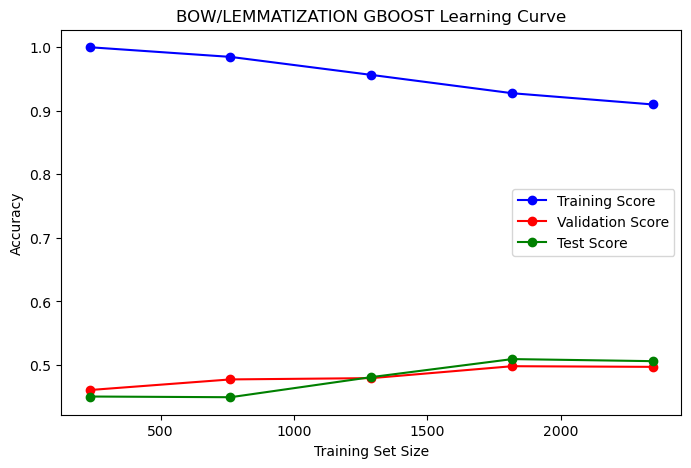

In [289]:
# Plot BOW Lemma GBoost Learning Curve
bowlemmagboost_model.plot_learning_curve(X_lemma_bowtrain, y_lemmatrain, X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION GBOOST Learning Curve")

### GRADIENT BOOST: TFIDF

In [290]:
# Initialize the Stem TFIDF GBoost Model
tfidfstemgboost_model = GradientBoostingClassifierModel()

In [291]:
# Train Stemmed TFIDF GBoost Model
tfidfstemgboost_model.train_model(X_stem_tfidftrain, y_stemtrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:42:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [292]:
# Evaluate the Stemmed TFIDF GBoost Model
tfidfstemgboost_model.evaluate_model(X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest)

Validation Accuracy: 0.5136986301369864
Validation ROC AUC: 0.6890

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.22      0.31       138
           1       0.51      0.55      0.53       288
           2       0.52      0.61      0.56       304

    accuracy                           0.51       730
   macro avg       0.51      0.46      0.47       730
weighted avg       0.51      0.51      0.50       730

Test Accuracy: 0.5332606324972737
Test ROC AUC: 0.6749

Test Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.26      0.36       163
           1       0.53      0.53      0.53       363
           2       0.53      0.65      0.58       391

    accuracy                           0.53       917
   macro avg       0.55      0.48      0.49       917
weighted avg       0.54      0.53      0.52       917



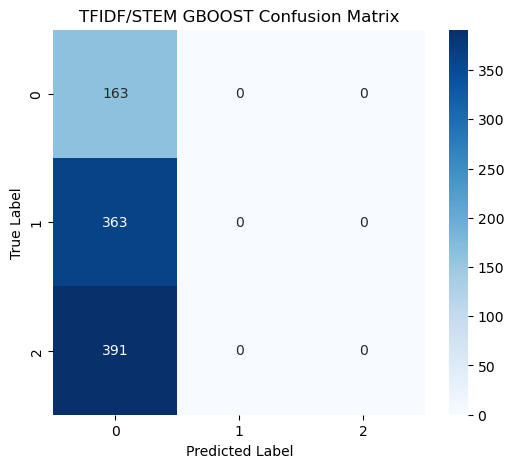

In [293]:
# Plot TFIDF Stem GBoost Confusion Matrix
tfidfstemgboost_model.plot_confusion_matrix(X_stem_tfidftest, y_stemtest, title="TFIDF/STEM GBOOST Confusion Matrix")

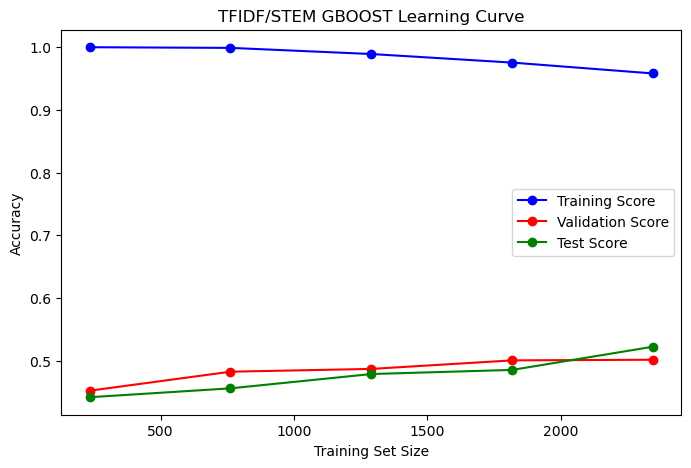

In [294]:
# Plot Learning Curve for TFIDF Stem GBoost
tfidfstemgboost_model.plot_learning_curve(X_stem_tfidftrain, y_stemtrain, X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest, title="TFIDF/STEM GBOOST Learning Curve")

In [295]:
# Initialize the Lemma TFIDF GBoost Model
tfidflemmagboost_model = GradientBoostingClassifierModel()

In [296]:
# Train Lemma TFIDF GBoost Model
tfidflemmagboost_model.train_model(X_lemma_tfidftrain, y_lemmatrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:56:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


In [412]:
# Evaluate the Lemma TFIDF GBoost Model
tfidflemmagboost_model.evaluate_model(X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest)

Validation Accuracy: 0.5123287671232877
Validation ROC AUC: 0.6879

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.19      0.28       138
           1       0.50      0.53      0.52       288
           2       0.52      0.64      0.57       304

    accuracy                           0.51       730
   macro avg       0.51      0.45      0.46       730
weighted avg       0.51      0.51      0.50       730

Test Accuracy: 0.5398037077426391
Test ROC AUC: 0.6880

Test Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.26      0.38       163
           1       0.53      0.53      0.53       363
           2       0.53      0.66      0.59       391

    accuracy                           0.54       917
   macro avg       0.58      0.49      0.50       917
weighted avg       0.56      0.54      0.53       917



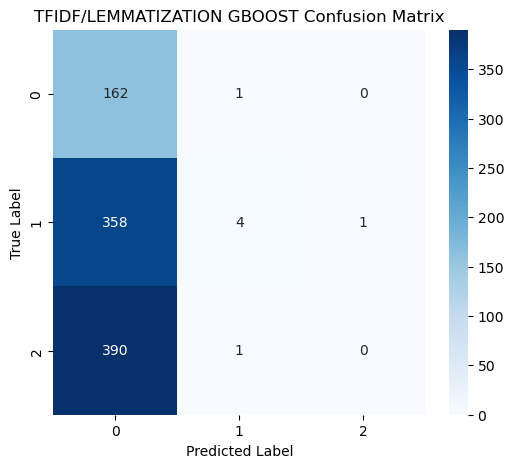

In [297]:
# Plot TFIDF Lemma GBoost Confusion Matrix
tfidflemmagboost_model.plot_confusion_matrix(X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION GBOOST Confusion Matrix")

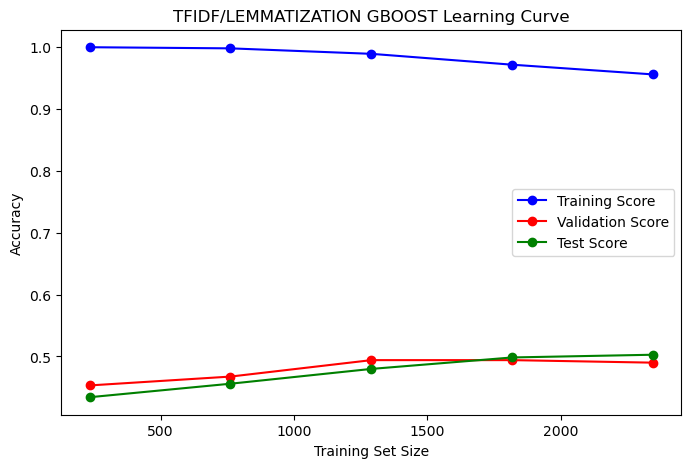

In [298]:
# Plot TFIDF Lemma GBoost Learning Curve
tfidflemmagboost_model.plot_learning_curve(X_lemma_tfidftrain, y_lemmatrain, X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION GBOOST Learning Curve")

### GRADIENT BOOST: WORD2VEC

In [299]:
# Initialize the Stemmed W2V GBoost Model
w2vstemgboost_model = GradientBoostingClassifierModel()

In [300]:
# Train Stemmed W2V GBoost Model
w2vstemgboost_model.train_model(X_stem_w2vtrain, y_stemtrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:24:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [301]:
# Evaluate the Stemmed W2V GBoost Model
w2vstemgboost_model.evaluate_model(X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest)

Validation Accuracy: 0.41643835616438357
Validation ROC AUC: 0.5456

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.00      0.00      0.00       288
           2       0.42      1.00      0.59       304

    accuracy                           0.42       730
   macro avg       0.14      0.33      0.20       730
weighted avg       0.17      0.42      0.24       730

Test Accuracy: 0.42639040348964014
Test ROC AUC: 0.4975

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



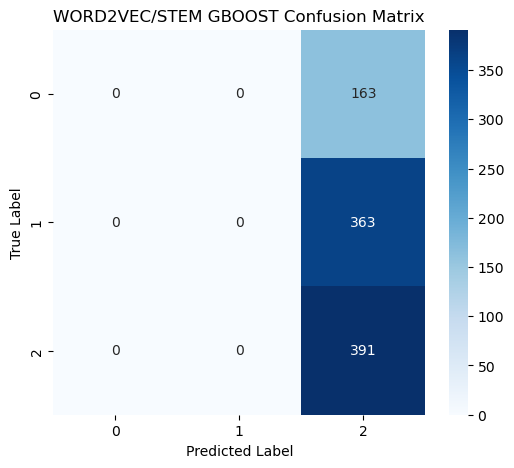

In [302]:
# Plot W2V Stem GBoost Confusion Matrix
w2vstemgboost_model.plot_confusion_matrix(X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM GBOOST Confusion Matrix")

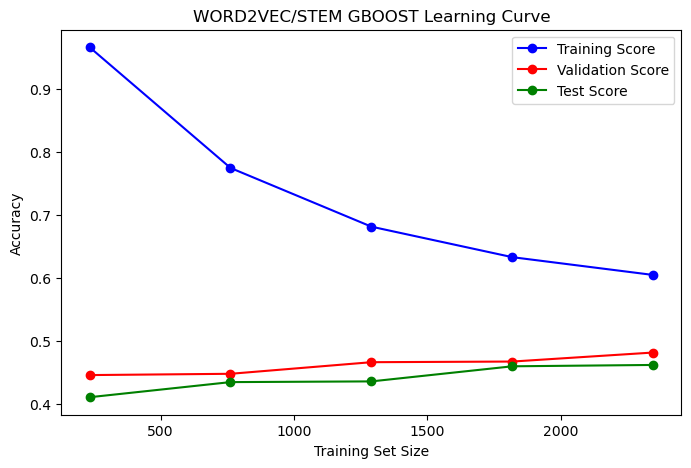

In [303]:
# Plot Learning Curve for W2V Stem GBoost
w2vstemgboost_model.plot_learning_curve(X_stem_w2vtrain, y_stemtrain, X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM GBOOST Learning Curve")

In [310]:
# Initialize the Lemma W2V LR Model
w2vlemmagboost_model = GradientBoostingClassifierModel()

In [311]:
# Train Lemma W2V GBoost Model
w2vlemmagboost_model.train_model(X_lemma_w2vtrain, y_lemmatrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:42:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [312]:
# Evaluate the Lemma W2V GBoost Model
w2vlemmagboost_model.evaluate_model(X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest)

Validation Accuracy: 0.4232876712328767
Validation ROC AUC: 0.5077

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.50      0.07      0.12       288
           2       0.42      0.95      0.58       304

    accuracy                           0.42       730
   macro avg       0.31      0.34      0.23       730
weighted avg       0.37      0.42      0.29       730

Test Accuracy: 0.42639040348964014
Test ROC AUC: 0.4831

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.00      0.00      0.00       363
           2       0.43      1.00      0.60       391

    accuracy                           0.43       917
   macro avg       0.14      0.33      0.20       917
weighted avg       0.18      0.43      0.25       917



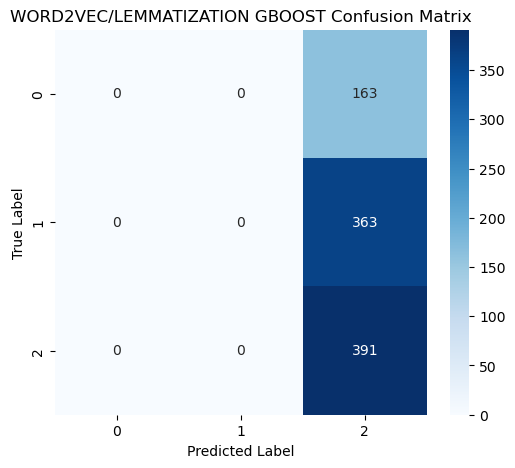

In [313]:
# Plot W2V Lemma GBoost Confusion Matrix
w2vlemmagboost_model.plot_confusion_matrix(X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION GBOOST Confusion Matrix")

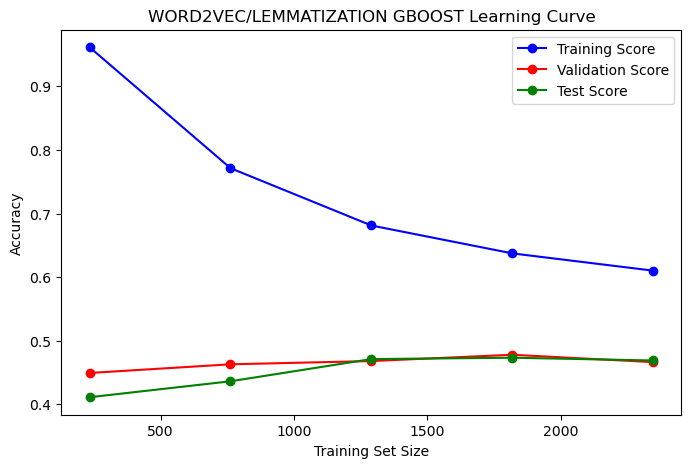

In [314]:
# Plot W2V Lemma GBoost Learning Curve
w2vlemmagboost_model.plot_learning_curve(X_lemma_w2vtrain, y_lemmatrain, X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION GBOOST Learning Curve")

**GRADIENT BOOST: Lemma Word2Vec with PCA**

In [315]:
# Initialize the Lemma W2V GBoost Model
w2vlemmapcagboost_model = GradientBoostingClassifierModel()

In [316]:
# Train Lemma W2V GBoost Model
w2vlemmapcagboost_model.train_model(X_lemma_w2vpcatrain, y_lemmatrain)

C:\Users\eniha\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:44:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.8}


In [317]:
# Evaluate the Lemma W2V GBoost Model
w2vlemmapcagboost_model.evaluate_model(X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest)

Validation Accuracy: 0.39452054794520547
Validation ROC AUC: 0.4931

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.39      1.00      0.57       288
           2       0.00      0.00      0.00       304

    accuracy                           0.39       730
   macro avg       0.13      0.33      0.19       730
weighted avg       0.16      0.39      0.22       730

Test Accuracy: 0.39585605234460197
Test ROC AUC: 0.4891

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.40      1.00      0.57       363
           2       0.00      0.00      0.00       391

    accuracy                           0.40       917
   macro avg       0.13      0.33      0.19       917
weighted avg       0.16      0.40      0.22       917



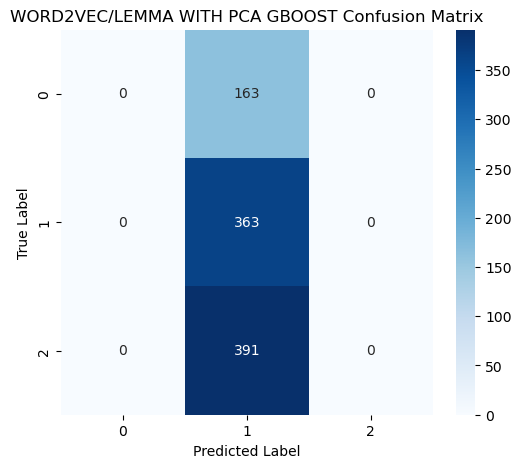

In [318]:
# Plot W2V Lemma GBoost Confusion Matrix
w2vlemmapcagboost_model.plot_confusion_matrix(X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA GBOOST Confusion Matrix")

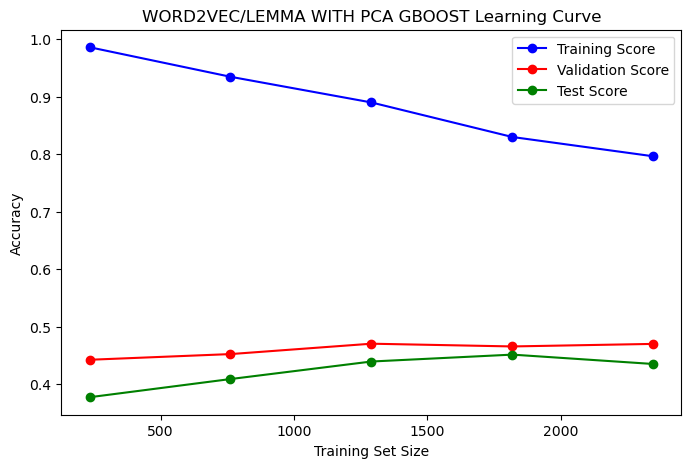

In [319]:
# Plot W2V Lemma GBoost Learning Curve
w2vlemmapcagboost_model.plot_learning_curve(X_lemma_w2vpcatrain, y_lemmatrain, X_lemma_w2vpcaval, y_lemmaval, X_lemma_w2vpcatest, y_lemmatest, title="WORD2VEC/LEMMA WITH PCA GBOOST Learning Curve")

## NAIVE BAYES

In [360]:
#Class for Naive Bayes
class NaiveBayesClassifierModel:
    def __init__(self):
        """
        Initialize the Naïve Bayes model.
        """
        self.model = MultinomialNB()
        self.best_model = None  #stores the trained model after training

        
    #Method for trainning   
    def train_model(self, X_train, y_train):
        """
        Train Naïve Bayes using GridSearchCV.
        """

        # Ensuring data is sparse format
        if not issparse(X_train):
            X_train = csr_matrix(X_train)

        param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0]}  

        grid_search = GridSearchCV(self.model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        self.best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
        
        
    #Method for evaluation
    def evaluate_model(self, X_val, y_val, X_test, y_test):
        """
        Evaluate the trained model on validation and test sets.
        """
        if self.best_model is None:
            raise ValueError("Model is not trained. Call train_model() first.")

        # Ensuring data is sparse format
        if not issparse(X_val):
            X_val = csr_matrix(X_val)
        if not issparse(X_test):
            X_test = csr_matrix(X_test)

        #Predictions
        y_val_pred = self.best_model.predict(X_val)
        y_val_prob = self.best_model.predict_proba(X_val)

        y_test_pred = self.best_model.predict(X_test)
        y_test_prob = self.best_model.predict_proba(X_test)



        # Compute ROC-AUC Score
        y_val_auc = roc_auc_score(y_val, y_val_prob, multi_class='ovr')
        y_test_auc = roc_auc_score(y_test, y_test_prob, multi_class='ovr')

        
        # Print Reports
        #Validation sets
        print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
        print(f"Validation ROC AUC: {y_val_auc:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(y_val, y_val_pred, zero_division=0))

        #Tests sets
        print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
        print(f"Test ROC AUC: {y_test_auc:.4f}")
        print("\nTest Classification Report:")
        print(classification_report(y_test, y_test_pred, zero_division=0))
        
        
        
    #Method to plot the Confusion Matrix 
    def plot_confusion_matrix(self, X, y, title="Confusion Matrix"):
        """
        Plot confusion matrix.
        """
        y_pred = self.best_model.predict(X)
        cm = confusion_matrix(y, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y), yticklabels=set(y))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(title)
        plt.show()


    #Method to plot the learning curve
    def plot_learning_curve(self, X_train, y_train, X_val, y_val, X_test, y_test, title="Learning Curve"):
        """
        Plot Learning Curve for Training, Validation, and Test Sets.
        """
        train_sizes, train_scores, val_scores = learning_curve(self.best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
        _, _, test_scores = learning_curve(self.best_model, X_test, y_test, cv=5, scoring='accuracy', n_jobs=-1)

        train_mean = np.mean(train_scores, axis=1)
        val_mean = np.mean(val_scores, axis=1)
        test_mean = np.mean(test_scores, axis=1)

        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_mean, 'o-', color='blue', label="Training Score")
        plt.plot(train_sizes, val_mean, 'o-', color='red', label="Validation Score")
        plt.plot(train_sizes, test_mean, 'o-', color='green', label="Test Score")
        plt.xlabel("Training Set Size")
        plt.ylabel("Accuracy")
        plt.title(title)
        plt.legend()
        plt.show()


### NAIVE BAYES: BAG OF WORDS

In [321]:
# Initialize the Stemmed BOW NaiveBayes Model
bowstemnbayes_model = NaiveBayesClassifierModel()

In [322]:
# Train Stemmed BOw NaiveBayes Model
bowstemnbayes_model.train_model(X_stem_bowtrain, y_stemtrain)

Best Parameters: {'alpha': 1.0}


In [323]:
# Evaluate the Stemmed BOW NaiveBayes Model
bowstemnbayes_model.evaluate_model(X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest)

Validation Accuracy: 0.4767123287671233
Validation ROC AUC: 0.6116

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.25      0.28       138
           1       0.48      0.52      0.50       288
           2       0.53      0.54      0.54       304

    accuracy                           0.48       730
   macro avg       0.44      0.44      0.44       730
weighted avg       0.47      0.48      0.47       730

Test Accuracy: 0.5136314067611778
Test ROC AUC: 0.6436

Test Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.28      0.31       163
           1       0.55      0.57      0.56       363
           2       0.53      0.56      0.54       391

    accuracy                           0.51       917
   macro avg       0.48      0.47      0.47       917
weighted avg       0.51      0.51      0.51       917



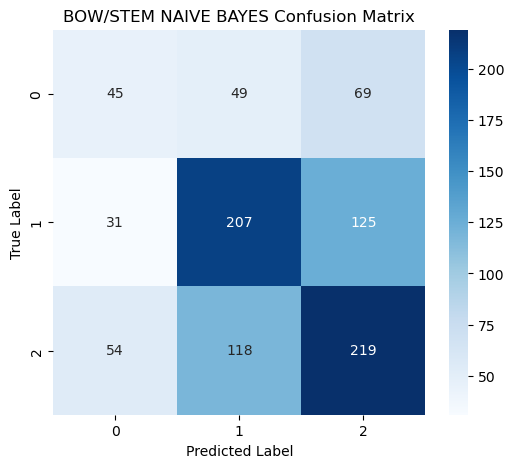

In [324]:
# Plot BOW Stem NaiveBayes Confusion Matrix
bowstemnbayes_model.plot_confusion_matrix(X_stem_bowtest, y_stemtest, title="BOW/STEM NAIVE BAYES Confusion Matrix")

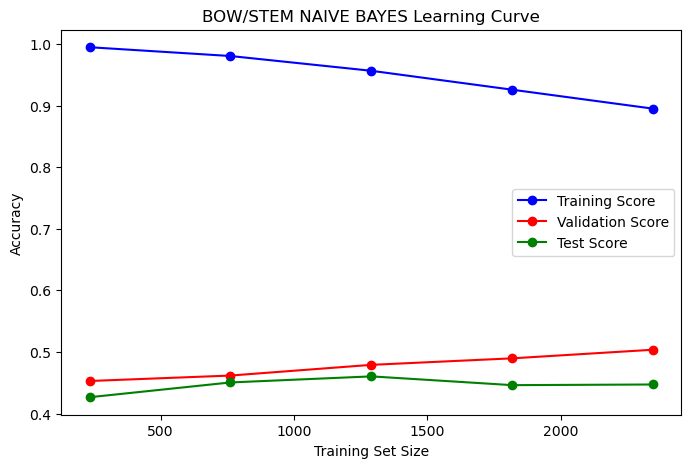

In [325]:
# Plot Stemmed BOW Naive Bayes Learning Curve
bowstemnbayes_model.plot_learning_curve(X_stem_bowtrain, y_stemtrain, X_stem_bowval, y_stemval, X_stem_bowtest, y_stemtest, title="BOW/STEM NAIVE BAYES Learning Curve")

In [326]:
# Initialize the Lemma BOW Naive Bayes Model
bowlemmanbayes_model = NaiveBayesClassifierModel()

In [327]:
# Train Lemma BOW Naive Bayes Model
bowlemmanbayes_model.train_model(X_lemma_bowtrain, y_lemmatrain)

Best Parameters: {'alpha': 1.0}


In [328]:
# Evaluate the Lemma BOW Naive Bayes Model
bowlemmanbayes_model.evaluate_model(X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest)

Validation Accuracy: 0.4821917808219178
Validation ROC AUC: 0.6069

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.26      0.31       138
           1       0.48      0.50      0.49       288
           2       0.52      0.57      0.54       304

    accuracy                           0.48       730
   macro avg       0.46      0.44      0.45       730
weighted avg       0.47      0.48      0.48       730

Test Accuracy: 0.5114503816793893
Test ROC AUC: 0.6431

Test Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.28      0.31       163
           1       0.54      0.56      0.55       363
           2       0.53      0.56      0.55       391

    accuracy                           0.51       917
   macro avg       0.48      0.47      0.47       917
weighted avg       0.50      0.51      0.51       917



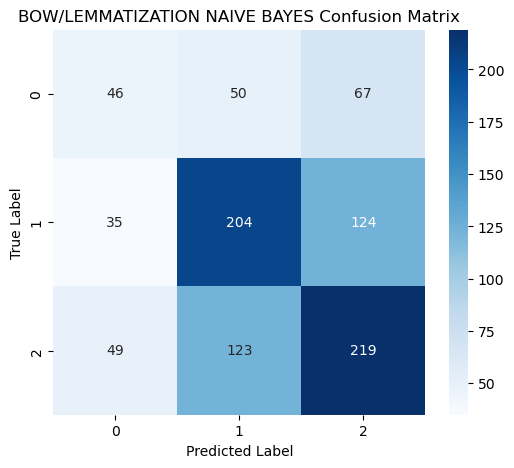

In [329]:
# Plot BOW Lemma Naive Bayes Confusion Matrix
bowlemmanbayes_model.plot_confusion_matrix(X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION NAIVE BAYES Confusion Matrix")

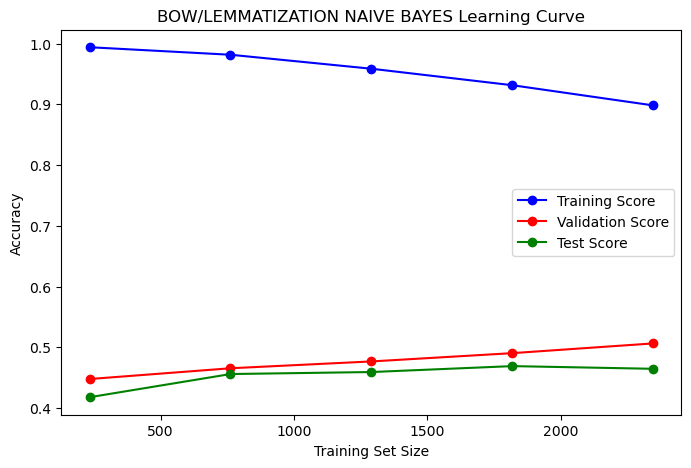

In [332]:
# Plot BOW Lemma Naive Bayes Learning Curve
bowlemmanbayes_model.plot_learning_curve(X_lemma_bowtrain, y_lemmatrain, X_lemma_bowval, y_lemmaval, X_lemma_bowtest, y_lemmatest, title="BOW/LEMMATIZATION NAIVE BAYES Learning Curve")

### NAIVE BAYES: TFIDF

In [333]:
# Initialize the Stemmed TFIDF Naive Bayes Model
tfidfstemnbayes_model = NaiveBayesClassifierModel()

In [334]:
# Train Stemmed TFIDF Naive Bayes Model
tfidfstemnbayes_model.train_model(X_stem_tfidftrain, y_stemtrain)

Best Parameters: {'alpha': 1.0}


In [335]:
# Evaluate the Stemmed TFIDF Naive Bayes Model
tfidfstemnbayes_model.evaluate_model(X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest)

Validation Accuracy: 0.5095890410958904
Validation ROC AUC: 0.6252

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.25      0.31       138
           1       0.51      0.58      0.54       288
           2       0.54      0.56      0.55       304

    accuracy                           0.51       730
   macro avg       0.48      0.46      0.47       730
weighted avg       0.50      0.51      0.50       730

Test Accuracy: 0.5059978189749182
Test ROC AUC: 0.6540

Test Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.25      0.29       163
           1       0.54      0.56      0.55       363
           2       0.52      0.57      0.54       391

    accuracy                           0.51       917
   macro avg       0.47      0.46      0.46       917
weighted avg       0.50      0.51      0.50       917



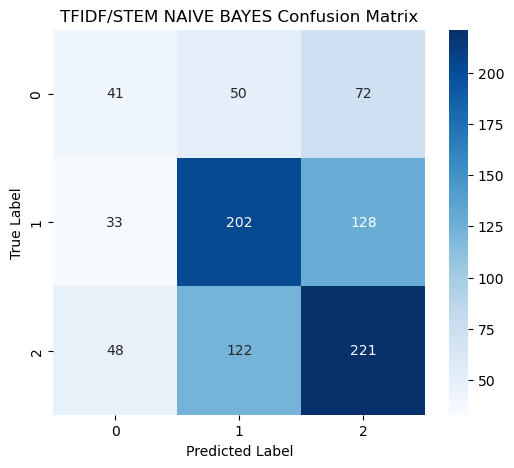

In [336]:
# Plot TFIDF Stem Naive Bayes Confusion Matrix
tfidfstemnbayes_model.plot_confusion_matrix(X_stem_tfidftest, y_stemtest, title="TFIDF/STEM NAIVE BAYES Confusion Matrix")

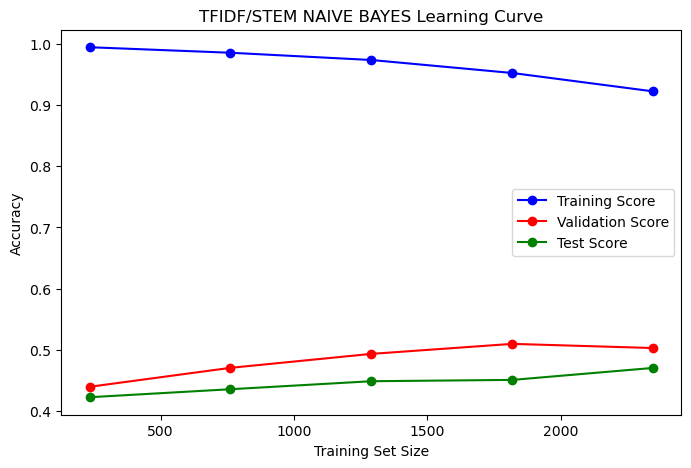

In [337]:
# Plot Learning Curve for TFIDF Stem Naive Bayes
tfidfstemnbayes_model.plot_learning_curve(X_stem_tfidftrain, y_stemtrain, X_stem_tfidfval, y_stemval, X_stem_tfidftest, y_stemtest, title="TFIDF/STEM NAIVE BAYES Learning Curve")

In [338]:
# Initialize the Lemma TFIDF Naive Bayes Model
tfidflemmanbayes_model = NaiveBayesClassifierModel()

In [339]:
# Train Lemma TFIDF Naive Bayes Model
tfidflemmanbayes_model.train_model(X_lemma_tfidftrain, y_lemmatrain)

Best Parameters: {'alpha': 1.0}


In [340]:
# Evaluate the Lemma TFIDF Naive Bayes Model
tfidflemmanbayes_model.evaluate_model(X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest)

Validation Accuracy: 0.48904109589041095
Validation ROC AUC: 0.6191

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.25      0.29       138
           1       0.50      0.55      0.52       288
           2       0.52      0.54      0.53       304

    accuracy                           0.49       730
   macro avg       0.46      0.45      0.45       730
weighted avg       0.48      0.49      0.48       730

Test Accuracy: 0.4940021810250818
Test ROC AUC: 0.6432

Test Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.26      0.30       163
           1       0.52      0.51      0.52       363
           2       0.52      0.58      0.54       391

    accuracy                           0.49       917
   macro avg       0.46      0.45      0.45       917
weighted avg       0.49      0.49      0.49       917



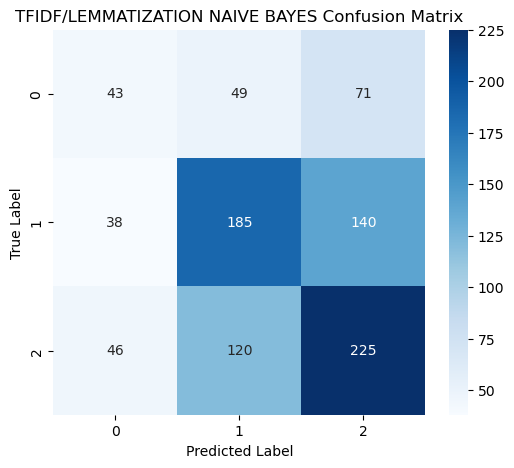

In [341]:
# Plot TFIDF Lemma Naive Bayes Confusion Matrix
tfidflemmanbayes_model.plot_confusion_matrix(X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION NAIVE BAYES Confusion Matrix")

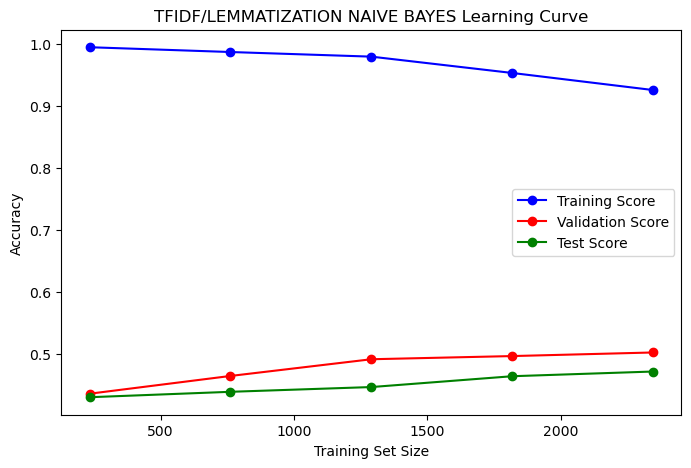

In [342]:
# Plot TFIDF Lemma Naive Bayes Learning Curve
tfidflemmanbayes_model.plot_learning_curve(X_lemma_tfidftrain, y_lemmatrain, X_lemma_tfidfval, y_lemmaval, X_lemma_tfidftest, y_lemmatest, title="TFIDF/LEMMATIZATION NAIVE BAYES Learning Curve")

### NAIVE BAYES: WORD2VEC

In [343]:
# Initialize the Stemmed W2V Naive Bayes Model
w2vstemnbayes_model = NaiveBayesClassifierModel()

In [344]:
# Train Stemmed W2V Naive Bayes Model
w2vstemnbayes_model.train_model(X_stem_w2vtrain, y_stemtrain)

Best Parameters: {'alpha': 1.0}


In [345]:
# Evaluate the Stemmed W2V Naive Bayes Model
w2vstemnbayes_model.evaluate_model(X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest)

Validation Accuracy: 0.39452054794520547
Validation ROC AUC: 0.5573

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.39      1.00      0.57       288
           2       0.00      0.00      0.00       304

    accuracy                           0.39       730
   macro avg       0.13      0.33      0.19       730
weighted avg       0.16      0.39      0.22       730

Test Accuracy: 0.39585605234460197
Test ROC AUC: 0.5428

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.40      1.00      0.57       363
           2       0.00      0.00      0.00       391

    accuracy                           0.40       917
   macro avg       0.13      0.33      0.19       917
weighted avg       0.16      0.40      0.22       917



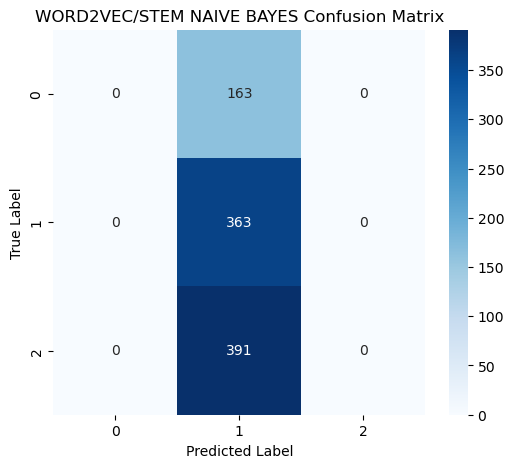

In [346]:
# Plot W2V Stem Naive Bayes Confusion Matrix
w2vstemnbayes_model.plot_confusion_matrix(X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM NAIVE BAYES Confusion Matrix")

In [362]:
# Plot Learning Curve for W2V Stem Naive Bayes
w2vstemnbayes_model.plot_learning_curve(X_stem_w2vtrain, y_stemtrain, X_stem_w2vval, y_stemval, X_stem_w2vtest, y_stemtest, title="WORD2VEC/STEM NAIVE BAYES Learning Curve")

In [363]:
# Initialize the Lemma W2V Naive Bayes Model
w2vlemmanbayes_model = NaiveBayesClassifierModel()

In [364]:
# Train Lemma W2V Naive Bayes Model
w2vlemmanbayes_model.train_model(X_lemma_w2vtrain, y_lemmatrain)

Best Parameters: {'alpha': 0.1}


In [365]:
# Evaluate the Lemma W2V Naive Bayes Model
w2vlemmanbayes_model.evaluate_model(X_lemma_w2vval, y_lemmaval, X_lemma_w2vtest, y_lemmatest)

Validation Accuracy: 0.39452054794520547
Validation ROC AUC: 0.5375

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       138
           1       0.39      1.00      0.57       288
           2       0.00      0.00      0.00       304

    accuracy                           0.39       730
   macro avg       0.13      0.33      0.19       730
weighted avg       0.16      0.39      0.22       730

Test Accuracy: 0.39585605234460197
Test ROC AUC: 0.5372

Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       163
           1       0.40      1.00      0.57       363
           2       0.00      0.00      0.00       391

    accuracy                           0.40       917
   macro avg       0.13      0.33      0.19       917
weighted avg       0.16      0.40      0.22       917



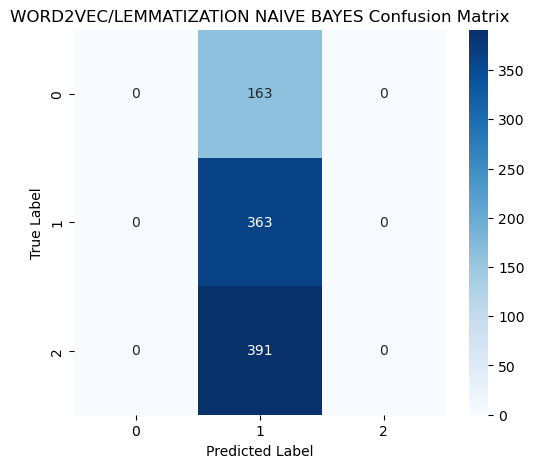

In [366]:
# Plot W2V Lemma Naive Bayes Confusion Matrix
w2vlemmanbayes_model.plot_confusion_matrix(X_lemma_w2vtest, y_lemmatest, title="WORD2VEC/LEMMATIZATION NAIVE BAYES Confusion Matrix")

## RESULT ANALYSIS

In [413]:
#Load validation and test results
result_test = pd.read_excel(r"C:\Users\eniha\webis-clickbait-22\spoiler classify result.xlsx", header=0, sheet_name=0)
result_val = pd.read_excel(r"C:\Users\eniha\webis-clickbait-22\spoiler classify result.xlsx", header=0, sheet_name=1)

In [414]:
#Test result head
result_val.head()

Model Vectorizer Root/Base   Acc  ROC AUC  Phrase Pr.  Phrase Rec  \
0    LR        BOW      Stem  0.51     0.66        0.43        0.38   
1    LR        BOW     Lemma  0.49     0.65        0.41        0.33   
2    LR     TF IDF      Stem  0.50     0.67        0.41        0.52   
3    LR     TF IDF     Lemma  0.50     0.66        0.41        0.47   
4    LR   WORD2VEC      Stem  0.19     0.44        0.19        1.00   

   Phrase F1  Passage Pr.  Passage Rec  Passage F1  Multi Pr  Multi Rec  \
0       0.40         0.51         0.51        0.51      0.53       0.56   
1       0.37         0.49         0.45        0.47      0.52       0.60   
2       0.46         0.49         0.51        0.50      0.57       0.48   
3       0.44         0.49         0.50        0.49      0.56       0.52   
4       0.32         0.00         0.00        0.00      0.00       0.00   

   Multi F1  
0      0.54  
1      0.55  
2      0.52  
3      0.54  
4      0.00

In [415]:
#Val result head
result_test.head()

Model Vectorizer Root/Base   Acc  ROC AUC  Phrase Pr.  Phrase Rec  \
0    LR        BOW      Stem  0.54     0.69        0.43        0.37   
1    LR        BOW     Lemma  0.55     0.69        0.44        0.42   
2    LR     TF IDF      Stem  0.52     0.69        0.36        0.47   
3    LR     TF IDF     Lemma  0.51     0.69        0.34        0.47   
4    LR   WORD2VEC      Stem  0.18     0.45        0.18        1.00   

   Phrase F1  Passage Pr.  Passage Rec  Passage F1  Multi Pr  Multi Rec  \
0       0.40         0.56         0.50        0.53      0.56       0.65   
1       0.43         0.58         0.50        0.54      0.56       0.64   
2       0.41         0.57         0.53        0.55      0.57       0.54   
3       0.40         0.59         0.53        0.55      0.56       0.53   
4       0.30         0.00         0.00        0.00      0.00       0.00   

   Multi F1  
0      0.60  
1      0.60  
2      0.56  
3      0.54  
4      0.00

In [416]:
#Statistics of the validation result
result_test.describe()

Acc    ROC AUC  Phrase Pr.  Phrase Rec  Phrase F1  Passage Pr.  \
count  34.000000  34.000000   34.000000   34.000000  34.000000    34.000000   
mean    0.462941   0.584706    0.312353    0.253235   0.222059     0.380294   
std     0.104607   0.133604    0.258680    0.283065   0.172711     0.238092   
min     0.180000   0.180000    0.000000    0.000000   0.000000     0.000000   
25%     0.430000   0.500000    0.000000    0.000000   0.000000     0.100000   
50%     0.510000   0.645000    0.345000    0.255000   0.300000     0.525000   
75%     0.540000   0.687500    0.527500    0.337500   0.375000     0.547500   
max     0.550000   0.700000    0.750000    1.000000   0.430000     0.600000   

       Passage Rec  Passage F1   Multi Pr  Multi Rec   Multi F1  
count    34.000000   34.000000  34.000000  34.000000  34.000000  
mean      0.452647    0.398824   0.408824   0.559118   0.460000  
std       0.314915    0.243544   0.216218   0.329815   0.240731  
min       0.000000    0.000000   0.000000   0.000000   0.000000  
25%       0.107500    0.122500   0.430000   0.532500   0.540000  
50%       0.530000    0.530000   0.520000   0.630000   0.585000  
75%       0.567500    0.550000   0.550000   0.667500   0.600000  
max       1.000000    0.570000   0.570000   1.000000   0.630000

In [417]:
#Statistics of the test result
result_test.describe()

Acc    ROC AUC  Phrase Pr.  Phrase Rec  Phrase F1  Passage Pr.  \
count  34.000000  34.000000   34.000000   34.000000  34.000000    34.000000   
mean    0.462941   0.584706    0.312353    0.253235   0.222059     0.380294   
std     0.104607   0.133604    0.258680    0.283065   0.172711     0.238092   
min     0.180000   0.180000    0.000000    0.000000   0.000000     0.000000   
25%     0.430000   0.500000    0.000000    0.000000   0.000000     0.100000   
50%     0.510000   0.645000    0.345000    0.255000   0.300000     0.525000   
75%     0.540000   0.687500    0.527500    0.337500   0.375000     0.547500   
max     0.550000   0.700000    0.750000    1.000000   0.430000     0.600000   

       Passage Rec  Passage F1   Multi Pr  Multi Rec   Multi F1  
count    34.000000   34.000000  34.000000  34.000000  34.000000  
mean      0.452647    0.398824   0.408824   0.559118   0.460000  
std       0.314915    0.243544   0.216218   0.329815   0.240731  
min       0.000000    0.000000   0.000000   0.000000   0.000000  
25%       0.107500    0.122500   0.430000   0.532500   0.540000  
50%       0.530000    0.530000   0.520000   0.630000   0.585000  
75%       0.567500    0.550000   0.550000   0.667500   0.600000  
max       1.000000    0.570000   0.570000   1.000000   0.630000

In [418]:
#Top 5 performing validation models
top_val_accuracy = result_val.nlargest(5, 'Acc')
top_val_accuracy

Model Vectorizer Root/Base   Acc  ROC AUC  Phrase Pr.  Phrase Rec  \
16    RF     TF IDF      Stem  0.53     0.70        0.52        0.33   
0     LR        BOW      Stem  0.51     0.66        0.43        0.38   
23    GB     TF IDF      Stem  0.51     0.69        0.52        0.22   
24    GB     TF IDF     Lemma  0.51     0.69        0.52        0.19   
30    NB     TF IDF      Stem  0.51     0.63        0.40        0.25   

    Phrase F1  Passage Pr.  Passage Rec  Passage F1  Multi Pr  Multi Rec  \
16       0.40         0.50         0.54        0.52      0.55       0.61   
0        0.40         0.51         0.51        0.51      0.53       0.56   
23       0.31         0.51         0.55        0.53      0.52       0.61   
24       0.28         0.50         0.53        0.52      0.52       0.64   
30       0.31         0.51         0.58        0.54      0.54       0.56   

    Multi F1  
16      0.58  
0       0.54  
23      0.56  
24      0.57  
30      0.55

In [419]:
#Top 5 performing test models
top_test_accuracy = result_test.nlargest(5, 'Acc')
top_test_accuracy

Model Vectorizer Root/Base   Acc  ROC AUC  Phrase Pr.  Phrase Rec  \
1     LR        BOW     Lemma  0.55     0.69        0.44        0.42   
10   SVM     TF IDF     Lemma  0.55     0.68        0.75        0.18   
14    RF        BOW      Stem  0.55     0.68        0.52        0.29   
15    RF        BOW     Lemma  0.55     0.69        0.46        0.37   
17    RF     TF IDF     Lemma  0.55     0.67        0.49        0.33   

    Phrase F1  Passage Pr.  Passage Rec  Passage F1  Multi Pr  Multi Rec  \
1        0.43         0.58         0.50        0.54      0.56       0.64   
10       0.30         0.60         0.46        0.52      0.52       0.80   
14       0.38         0.54         0.52        0.53      0.55       0.67   
15       0.41         0.57         0.52        0.54      0.57       0.66   
17       0.39         0.56         0.54        0.55      0.55       0.64   

    Multi F1  
1       0.60  
10      0.63  
14      0.61  
15      0.61  
17      0.59

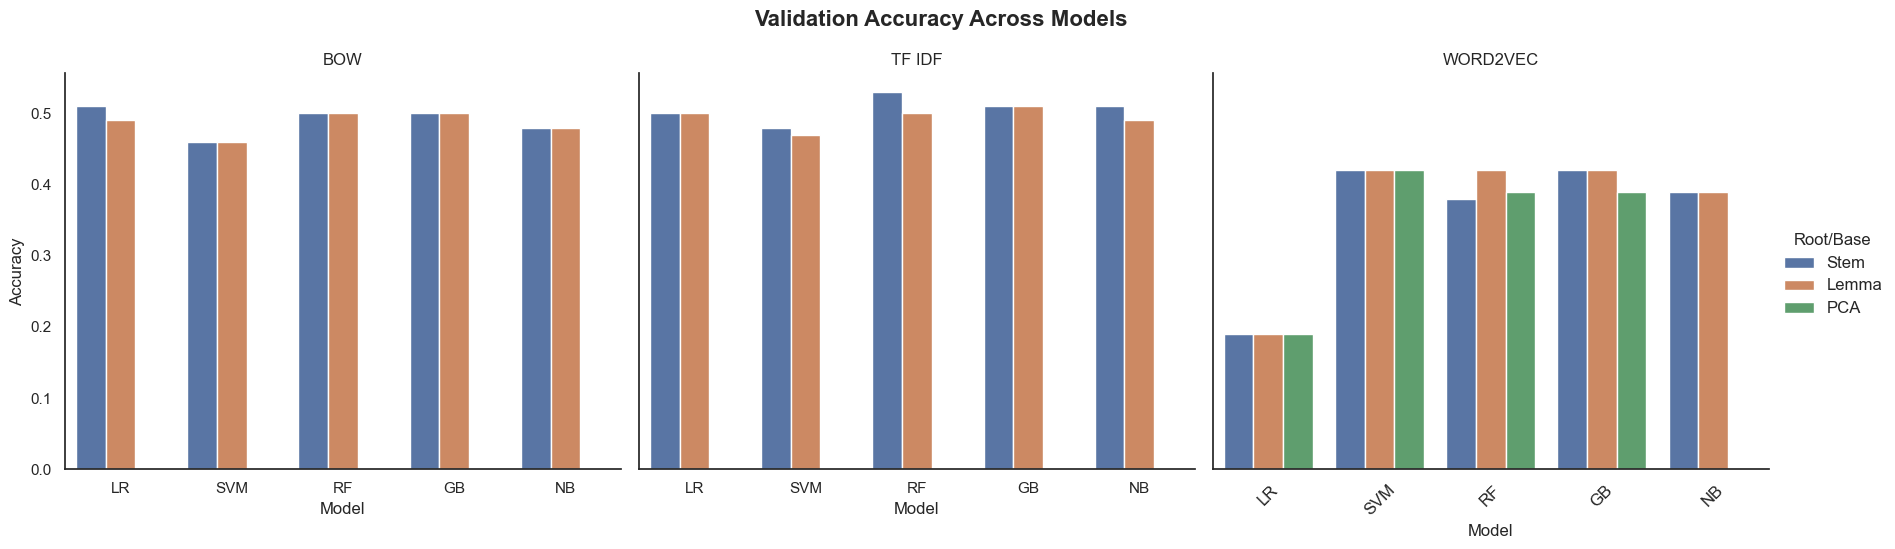

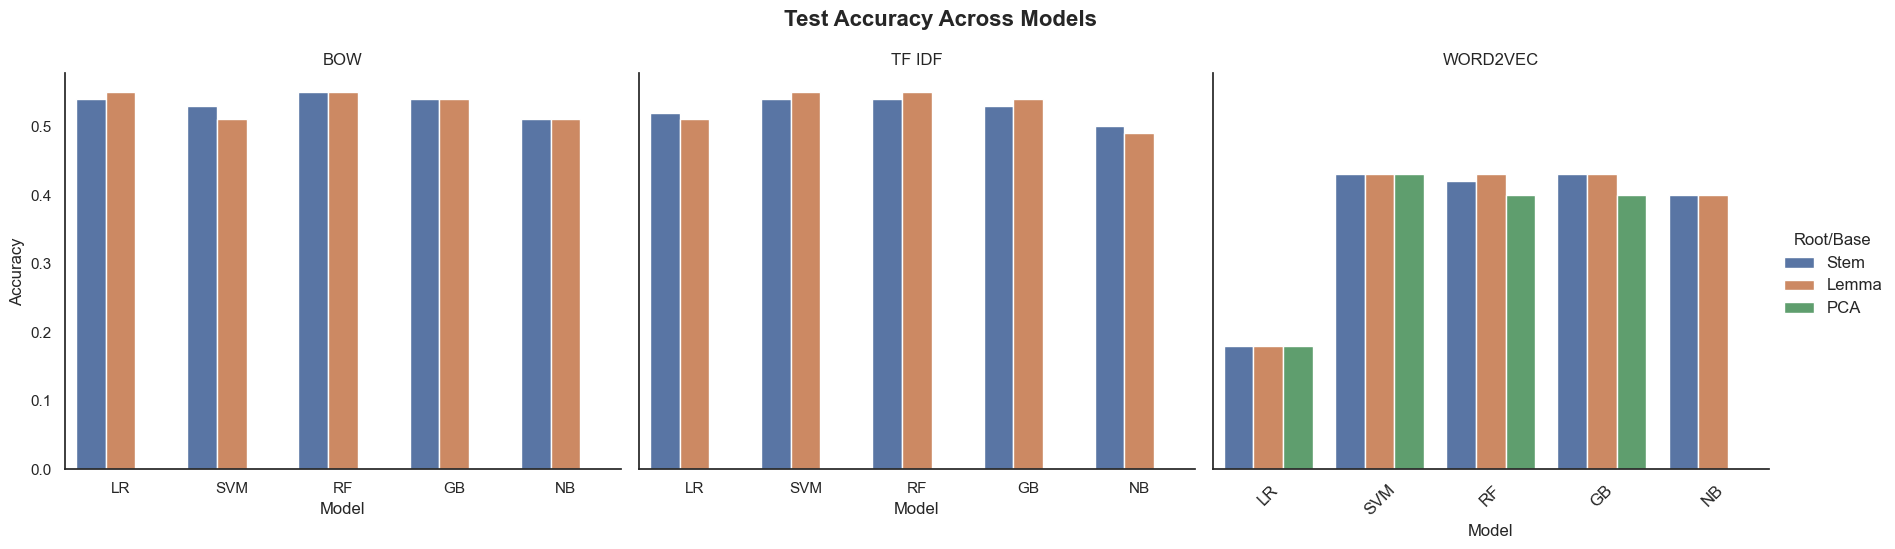

In [420]:
#Accuracy Scores Plot
sns.set_theme(style="white")

#Validation Accuracy plot
val_plot = sns.catplot(data=result_val, x="Model", y="Acc", hue="Root/Base", col="Vectorizer",
    kind="bar", height=5, aspect=1.2)

val_plot.fig.suptitle("Validation Accuracy Across Models", fontsize=16, fontweight="bold", y=1.05)
val_plot.set_axis_labels("Model", "Accuracy")
val_plot.set_titles("{col_name}")  # Set titles per vectorizer
val_plot._legend.set_title("Root/Base")
plt.setp(val_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Test Accuracy Plot
test_plot = sns.catplot(data=result_test, x="Model", y="Acc", hue="Root/Base", col="Vectorizer",
    kind="bar", height=5, aspect=1.2)

test_plot.fig.suptitle("Test Accuracy Across Models", fontsize=16, fontweight="bold", y=1.05)
test_plot.set_axis_labels("Model", "Accuracy")
test_plot.set_titles("{col_name}")  
test_plot._legend.set_title("Root/Base")
plt.setp(test_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


# Show plot
plt.show()

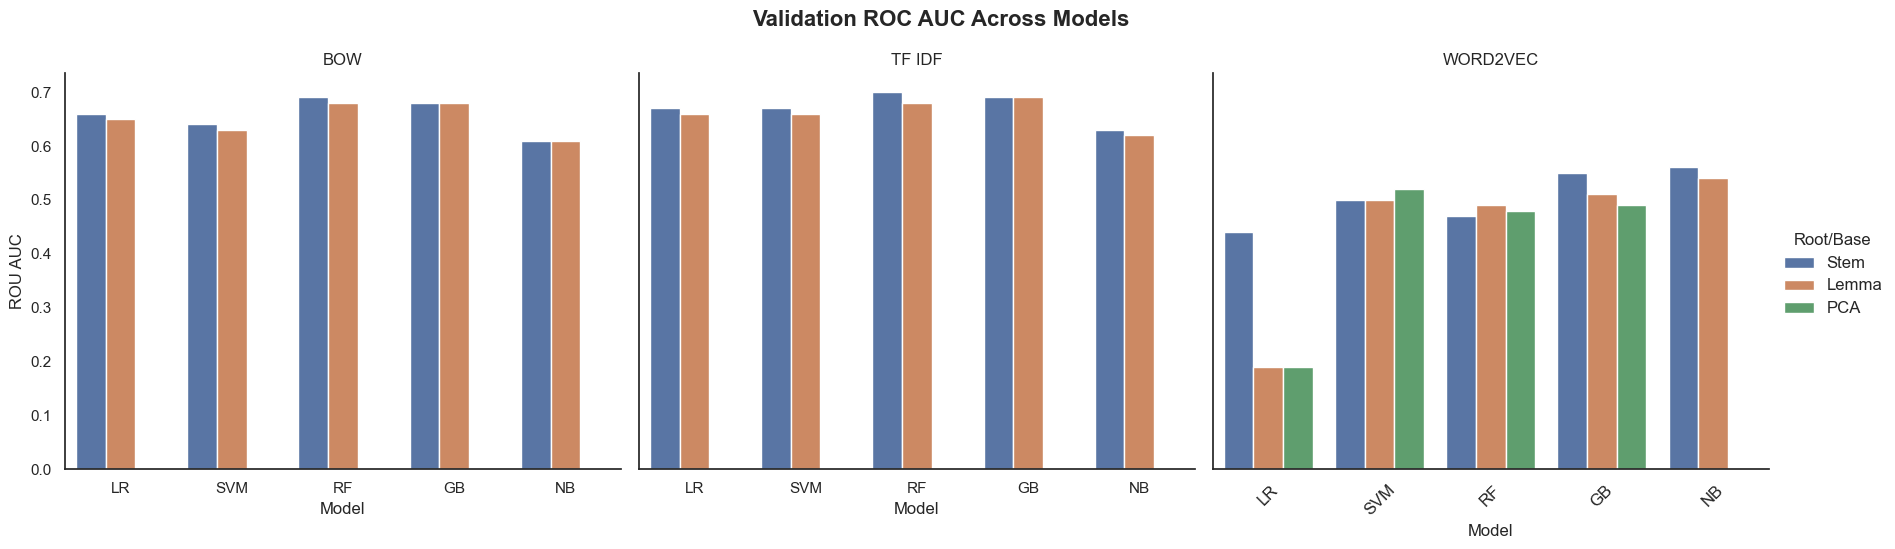

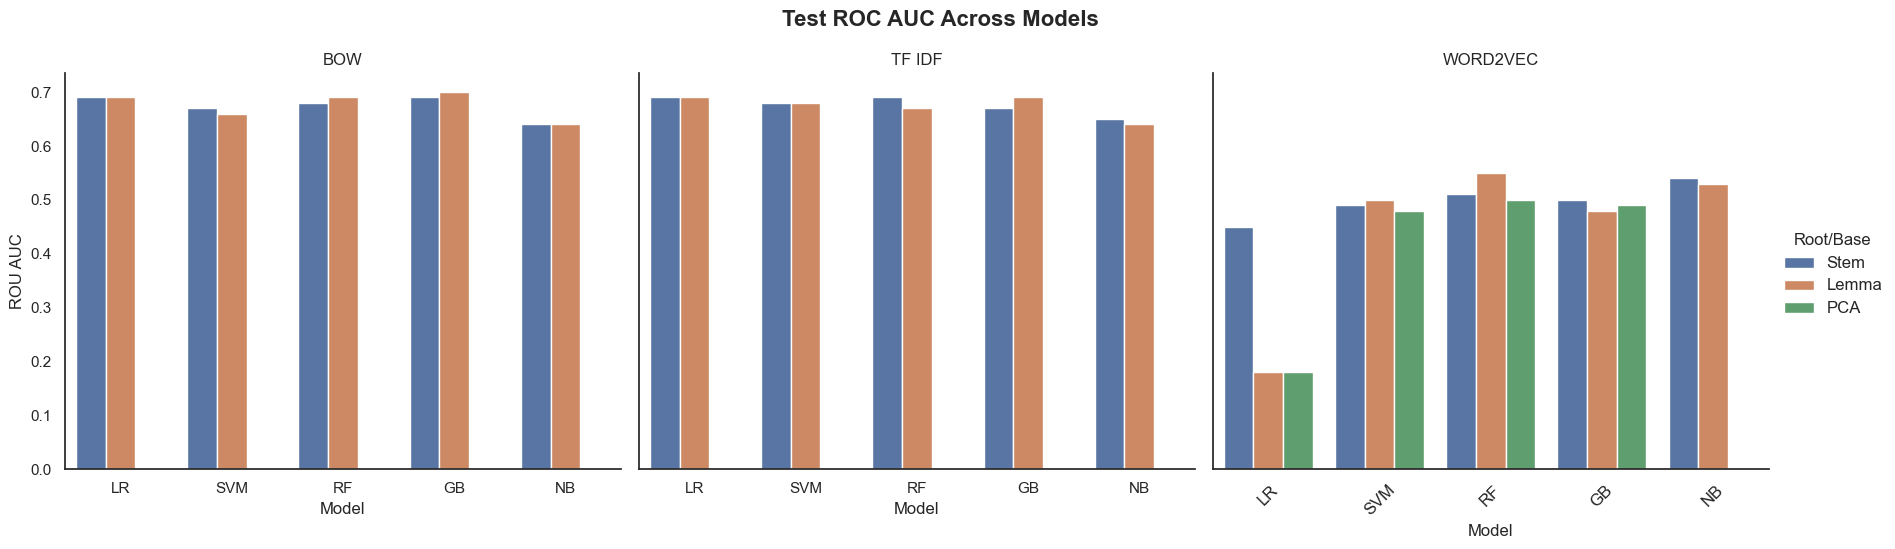

In [421]:
#ROU AUC Scores
sns.set_theme(style="white")

# Validation ROC AUC Plot
val_plot = sns.catplot(data=result_val, x="Model", y="ROC AUC", hue="Root/Base", col="Vectorizer",
    kind="bar", height=5, aspect=1.2)

val_plot.fig.suptitle("Validation ROC AUC Across Models", fontsize=16, fontweight="bold", y=1.05)
val_plot.set_axis_labels("Model", "ROU AUC")
val_plot.set_titles("{col_name}")  # Set titles per vectorizer
val_plot._legend.set_title("Root/Base")
plt.setp(val_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Test ROC AUC Plot
test_plot = sns.catplot(data=result_test, x="Model", y="ROC AUC", hue="Root/Base", col="Vectorizer",
    kind="bar", height=5, aspect=1.2)

test_plot.fig.suptitle("Test ROC AUC Across Models", fontsize=16, fontweight="bold", y=1.05)
test_plot.set_axis_labels("Model", "ROU AUC")
test_plot.set_titles("{col_name}")  
test_plot._legend.set_title("Root/Base")
plt.setp(test_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

plt.show()

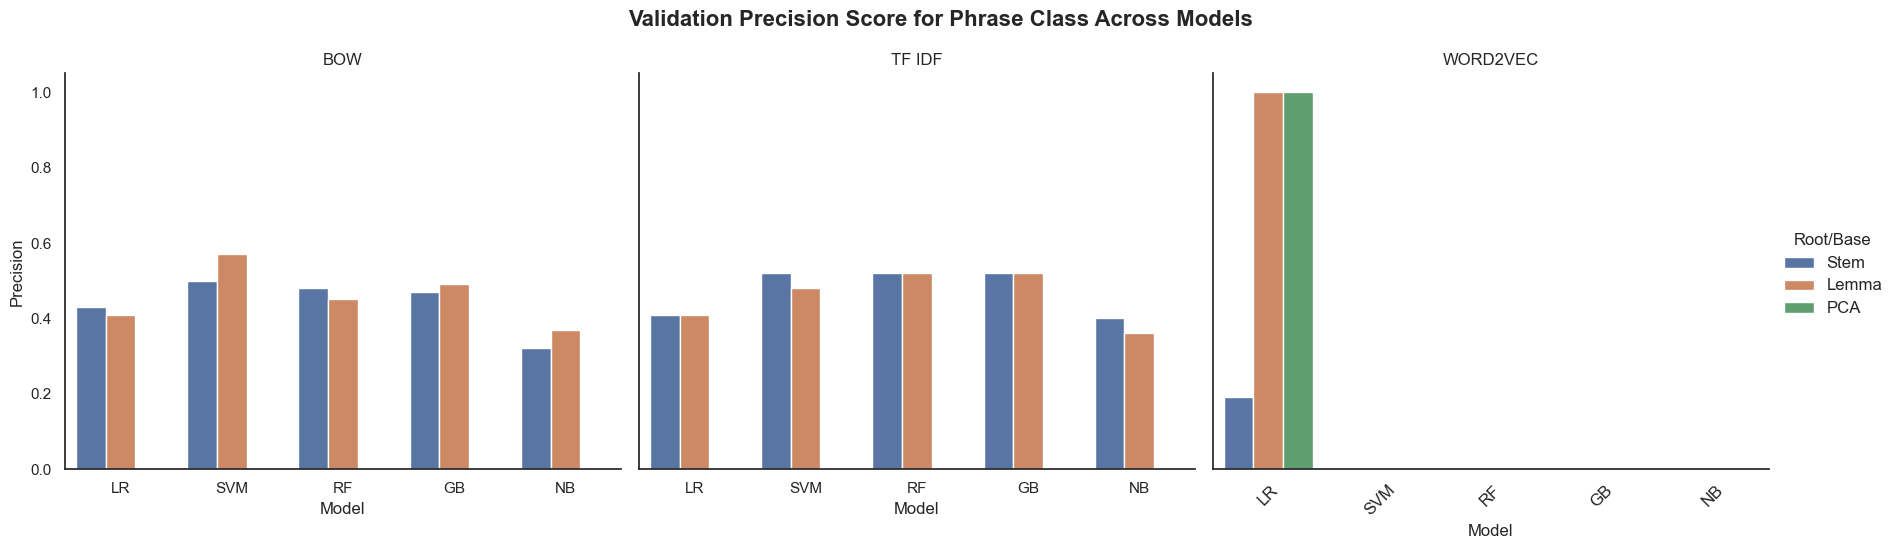

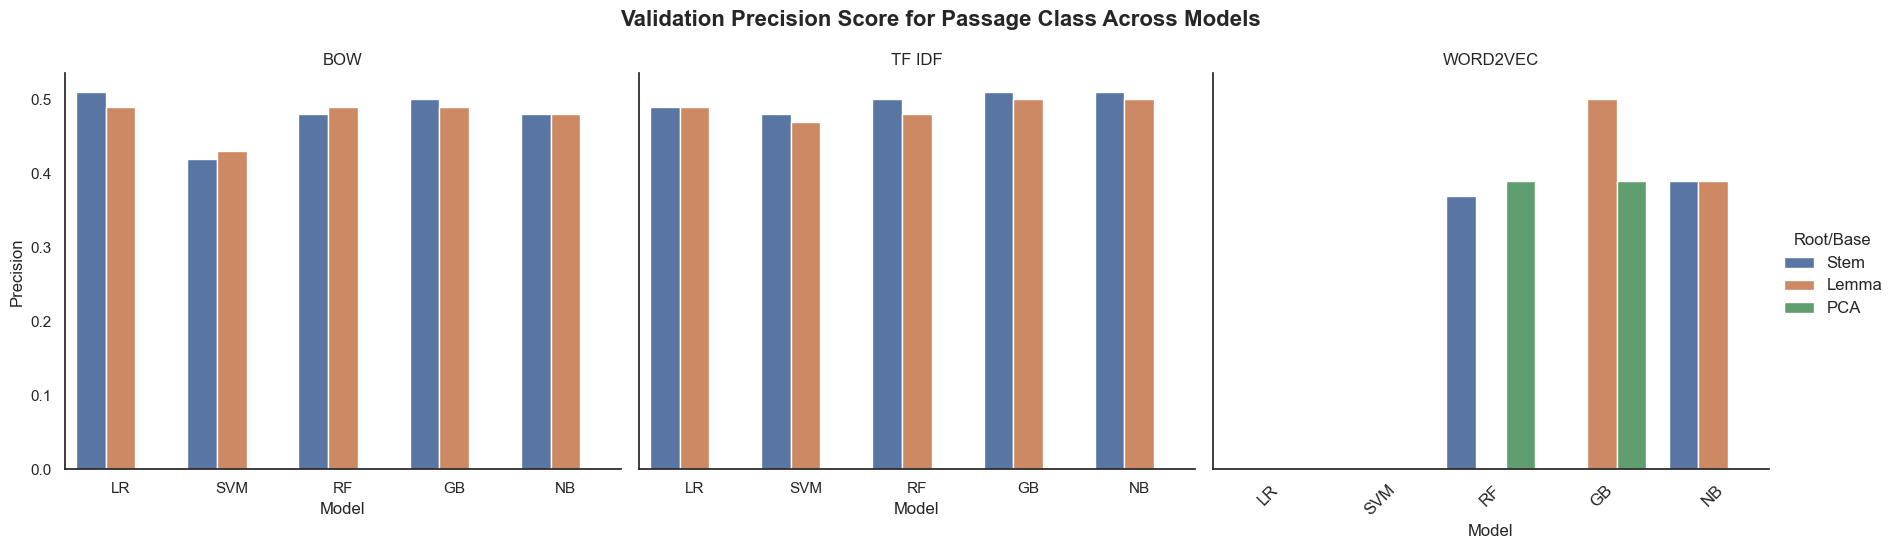

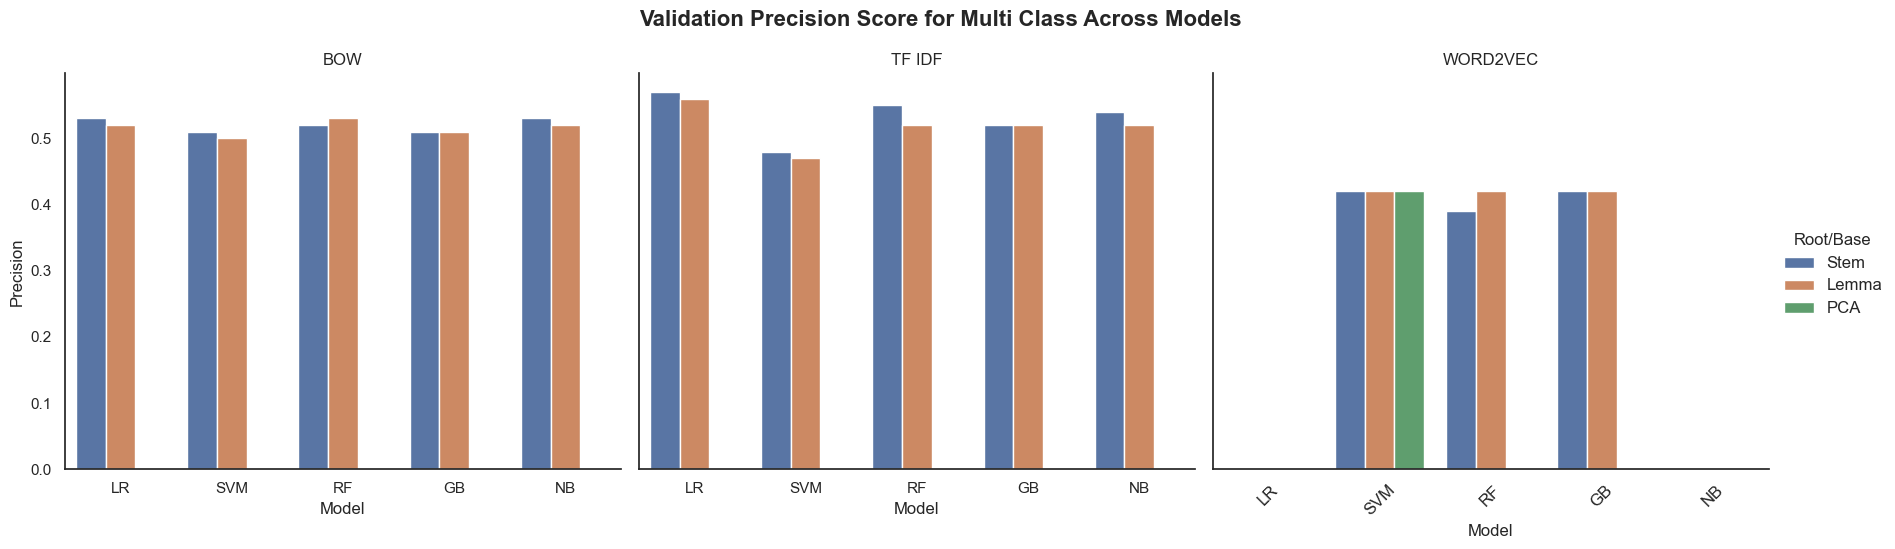

In [422]:
#Precision Scores for Validation Set
sns.set_theme(style="white")

# Phrase Class Precision Plot
phrase_plot = sns.catplot(data=result_val, x="Model", y="Phrase Pr.", hue="Root/Base", 
                       col="Vectorizer", kind="bar", height=5, aspect=1.2)

phrase_plot.fig.suptitle("Validation Precision Score for Phrase Class Across Models", fontsize=16, fontweight="bold", y=1.05)
phrase_plot.set_axis_labels("Model", "Precision")
phrase_plot.set_titles("{col_name}")  # Set titles per vectorizer
phrase_plot._legend.set_title("Root/Base")
plt.setp(phrase_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Passage Class Precision Plot
passage_plot = sns.catplot(data=result_val, x="Model", y="Passage Pr.", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

passage_plot.fig.suptitle("Validation Precision Score for Passage Class Across Models", fontsize=16, fontweight="bold", y=1.05)
passage_plot.set_axis_labels("Model", "Precision")
passage_plot.set_titles("{col_name}")  
passage_plot._legend.set_title("Root/Base")
plt.setp(passage_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Multi Class Precision Plot
multi_plot = sns.catplot(data=result_val, x="Model", y="Multi Pr", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

multi_plot.fig.suptitle("Validation Precision Score for Multi Class Across Models", fontsize=16, fontweight="bold", y=1.05)
multi_plot.set_axis_labels("Model", "Precision")
multi_plot.set_titles("{col_name}")  
multi_plot._legend.set_title("Root/Base")
plt.setp(multi_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


plt.show()

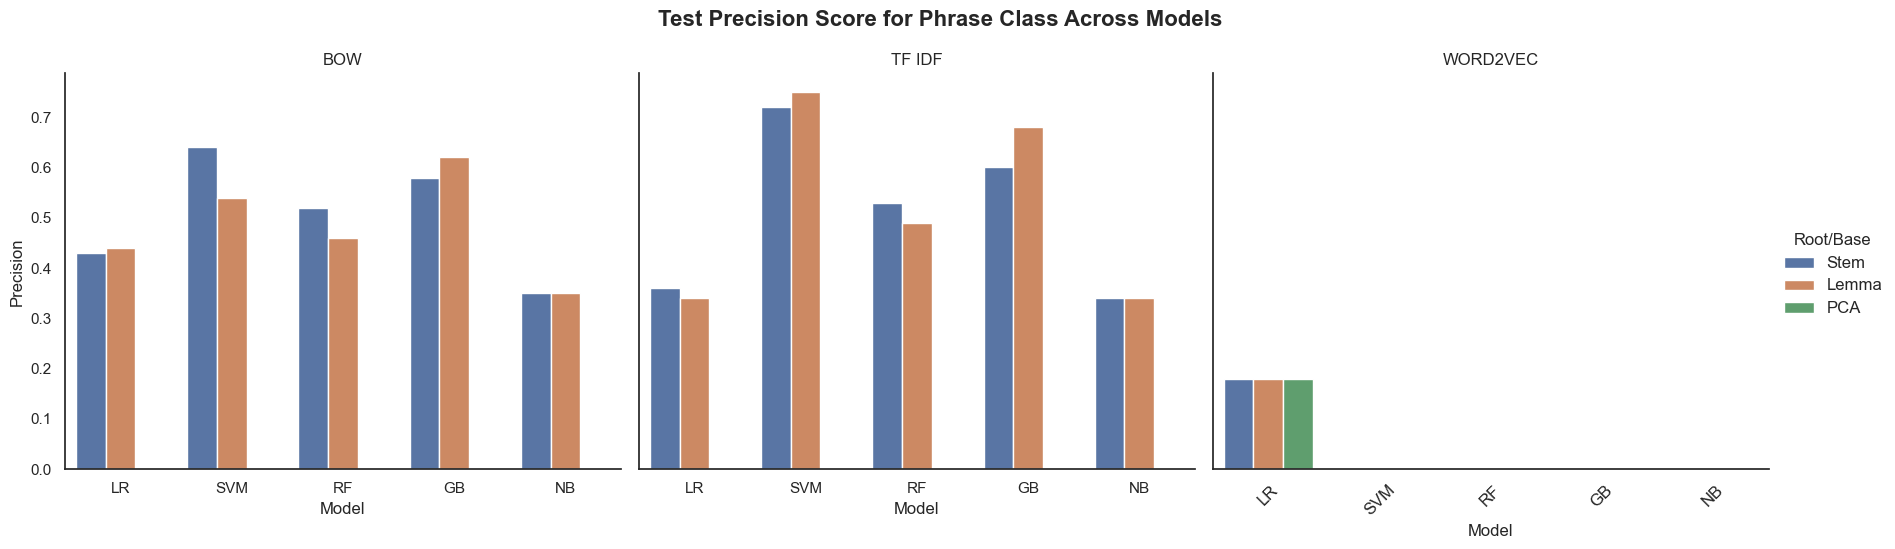

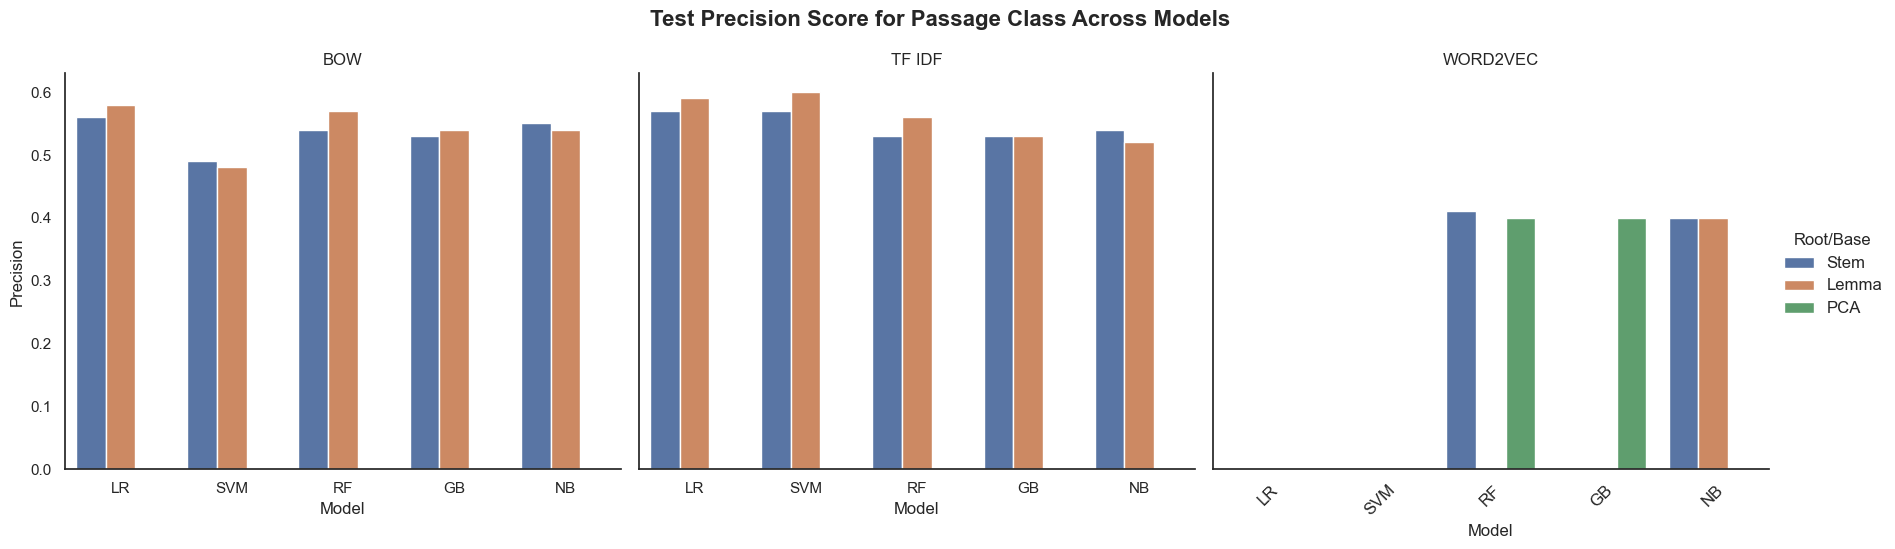

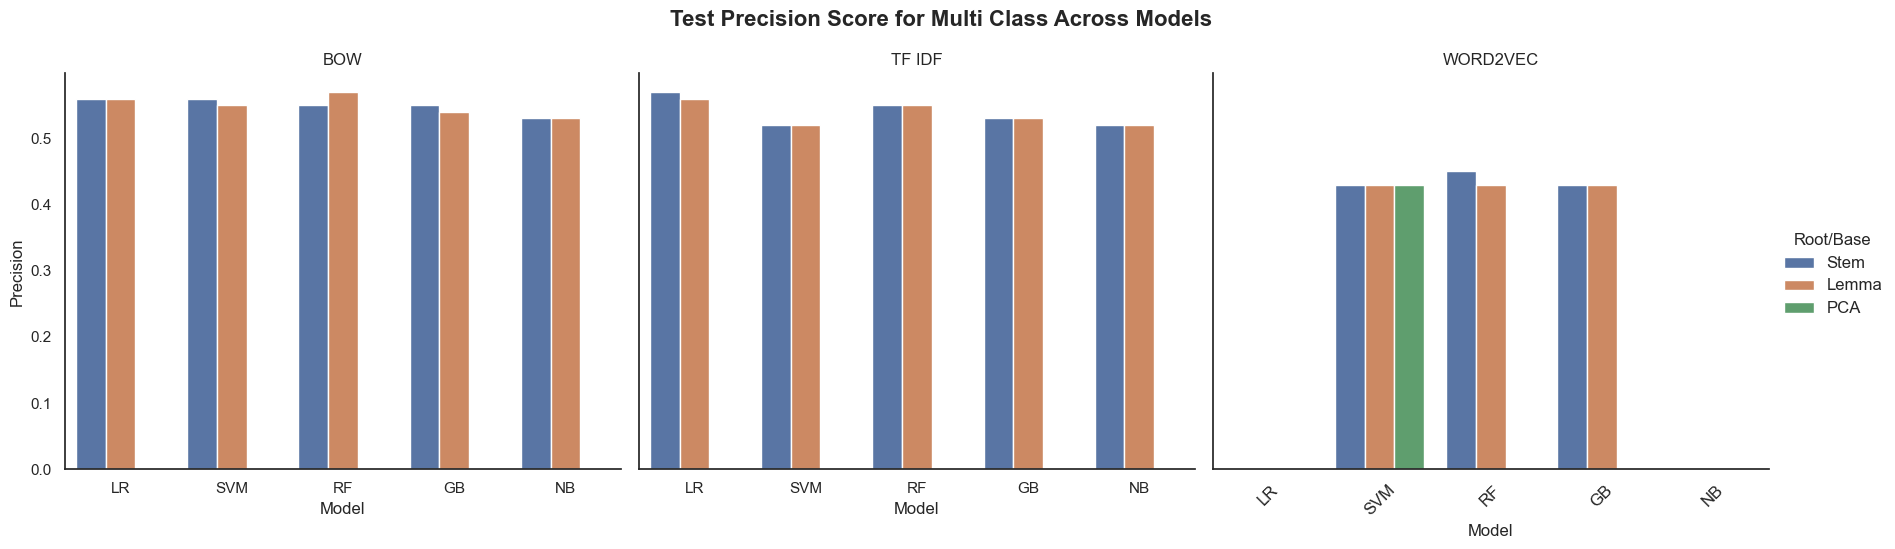

In [423]:
#Precision Scores for Test Set
sns.set_theme(style="white")

# Phrase Class Precision Plot
phrase_plot = sns.catplot(data=result_test, x="Model", y="Phrase Pr.", hue="Root/Base", 
                       col="Vectorizer", kind="bar", height=5, aspect=1.2)

phrase_plot.fig.suptitle("Test Precision Score for Phrase Class Across Models", fontsize=16, fontweight="bold", y=1.05)
phrase_plot.set_axis_labels("Model", "Precision")
phrase_plot.set_titles("{col_name}")  # Set titles per vectorizer
phrase_plot._legend.set_title("Root/Base")
plt.setp(phrase_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Passage Class Precision Plot
passage_plot = sns.catplot(data=result_test, x="Model", y="Passage Pr.", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

passage_plot.fig.suptitle("Test Precision Score for Passage Class Across Models", fontsize=16, fontweight="bold", y=1.05)
passage_plot.set_axis_labels("Model", "Precision")
passage_plot.set_titles("{col_name}")  
passage_plot._legend.set_title("Root/Base")
plt.setp(passage_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Multi Class Precision Plot
multi_plot = sns.catplot(data=result_test, x="Model", y="Multi Pr", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

multi_plot.fig.suptitle("Test Precision Score for Multi Class Across Models", fontsize=16, fontweight="bold", y=1.05)
multi_plot.set_axis_labels("Model", "Precision")
multi_plot.set_titles("{col_name}")  
multi_plot._legend.set_title("Root/Base")
plt.setp(multi_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


plt.show()

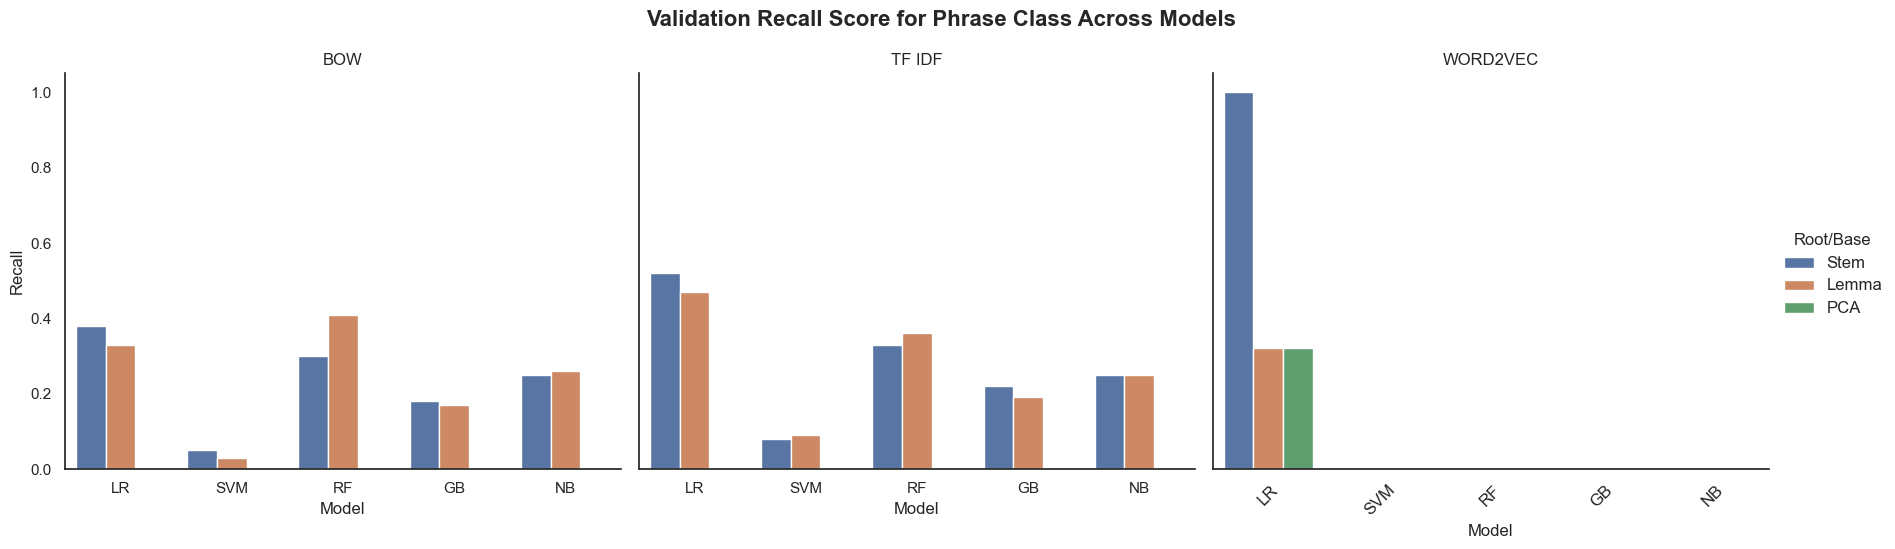

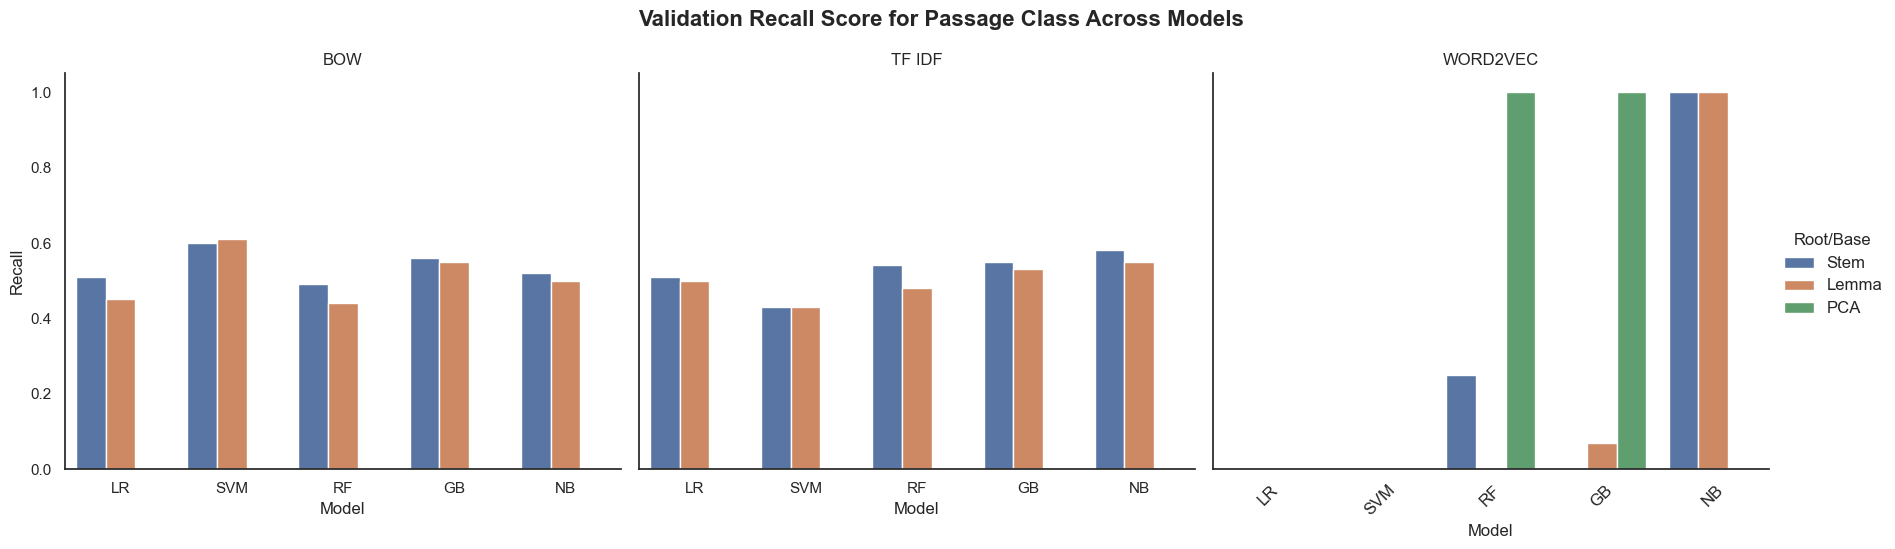

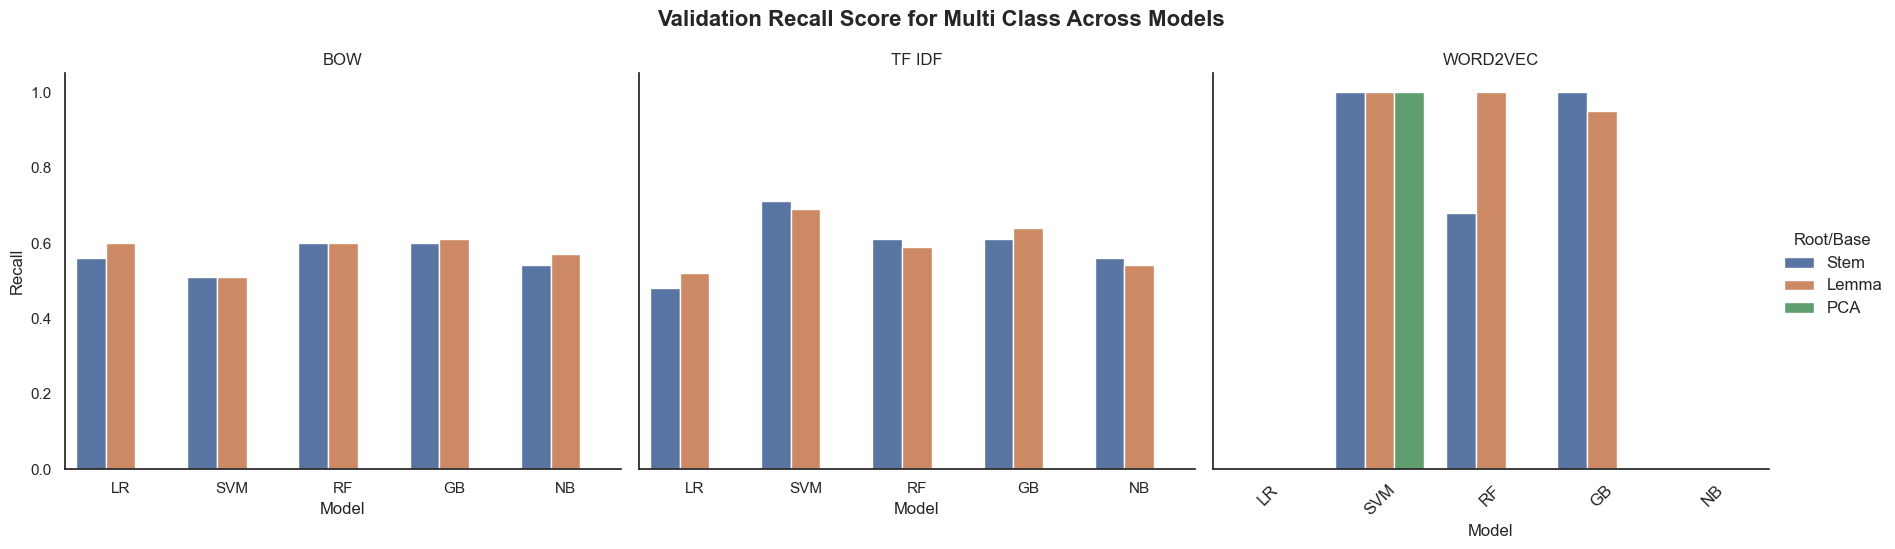

In [424]:
#Recall Scores for Validation Set
sns.set_theme(style="white")

# Phrase Class Recall Plot
phrase_plot = sns.catplot(data=result_val, x="Model", y="Phrase Rec", hue="Root/Base", 
                       col="Vectorizer", kind="bar", height=5, aspect=1.2)

phrase_plot.fig.suptitle("Validation Recall Score for Phrase Class Across Models", fontsize=16, fontweight="bold", y=1.05)
phrase_plot.set_axis_labels("Model", "Recall")
phrase_plot.set_titles("{col_name}")  # Set titles per vectorizer
phrase_plot._legend.set_title("Root/Base")
plt.setp(phrase_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Passage Class Recall Plot
passage_plot = sns.catplot(data=result_val, x="Model", y="Passage Rec", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

passage_plot.fig.suptitle("Validation Recall Score for Passage Class Across Models", fontsize=16, fontweight="bold", y=1.05)
passage_plot.set_axis_labels("Model", "Recall")
passage_plot.set_titles("{col_name}")  
passage_plot._legend.set_title("Root/Base")
plt.setp(passage_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Multi Class Recall Plot
multi_plot = sns.catplot(data=result_val, x="Model", y="Multi Rec", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

multi_plot.fig.suptitle("Validation Recall Score for Multi Class Across Models", fontsize=16, fontweight="bold", y=1.05)
multi_plot.set_axis_labels("Model", "Recall")
multi_plot.set_titles("{col_name}")  
multi_plot._legend.set_title("Root/Base")
plt.setp(multi_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


plt.show()

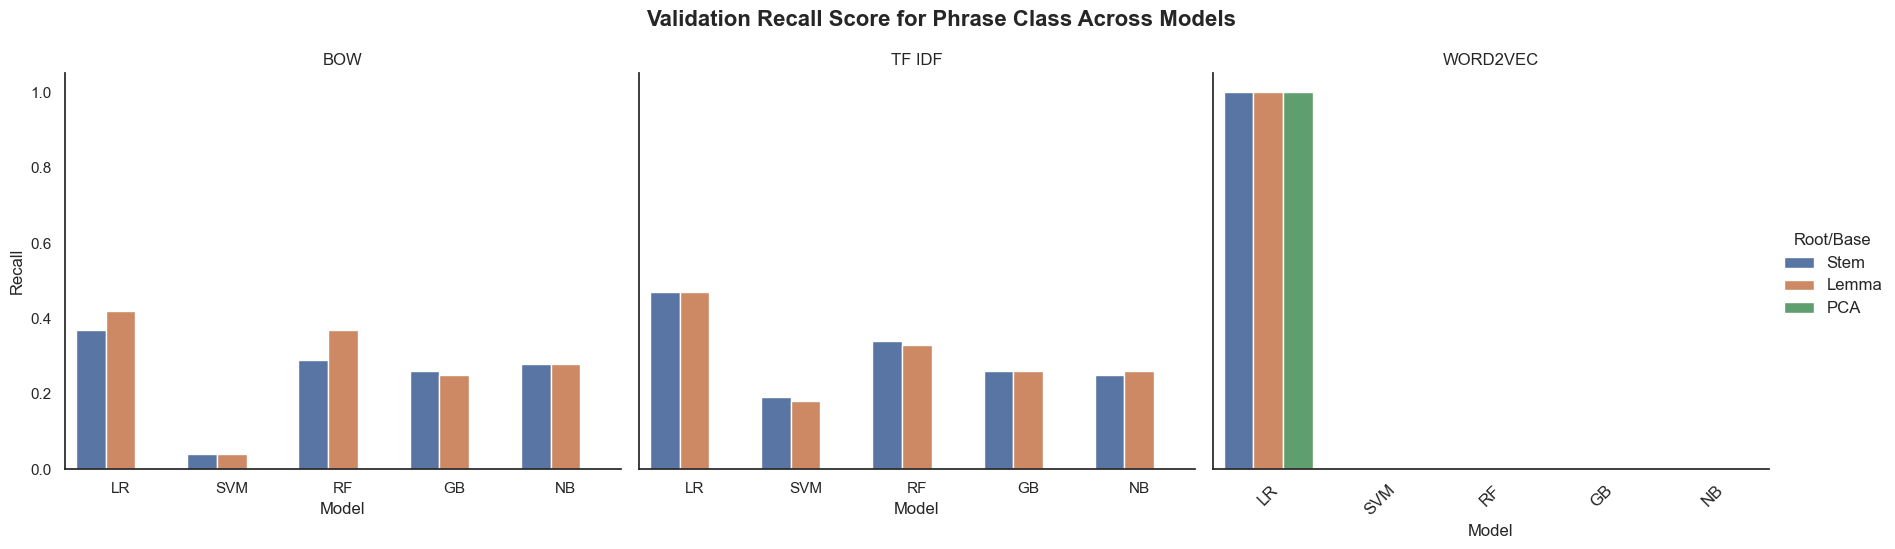

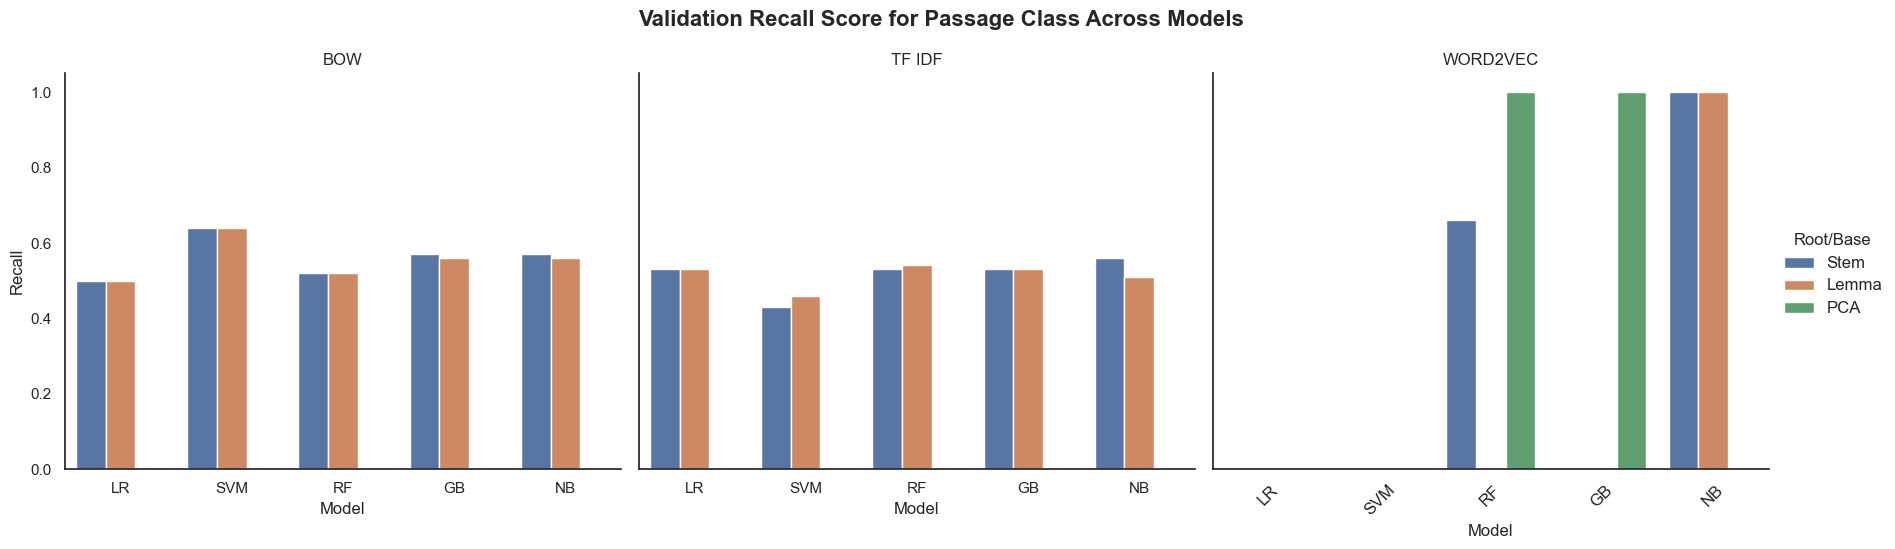

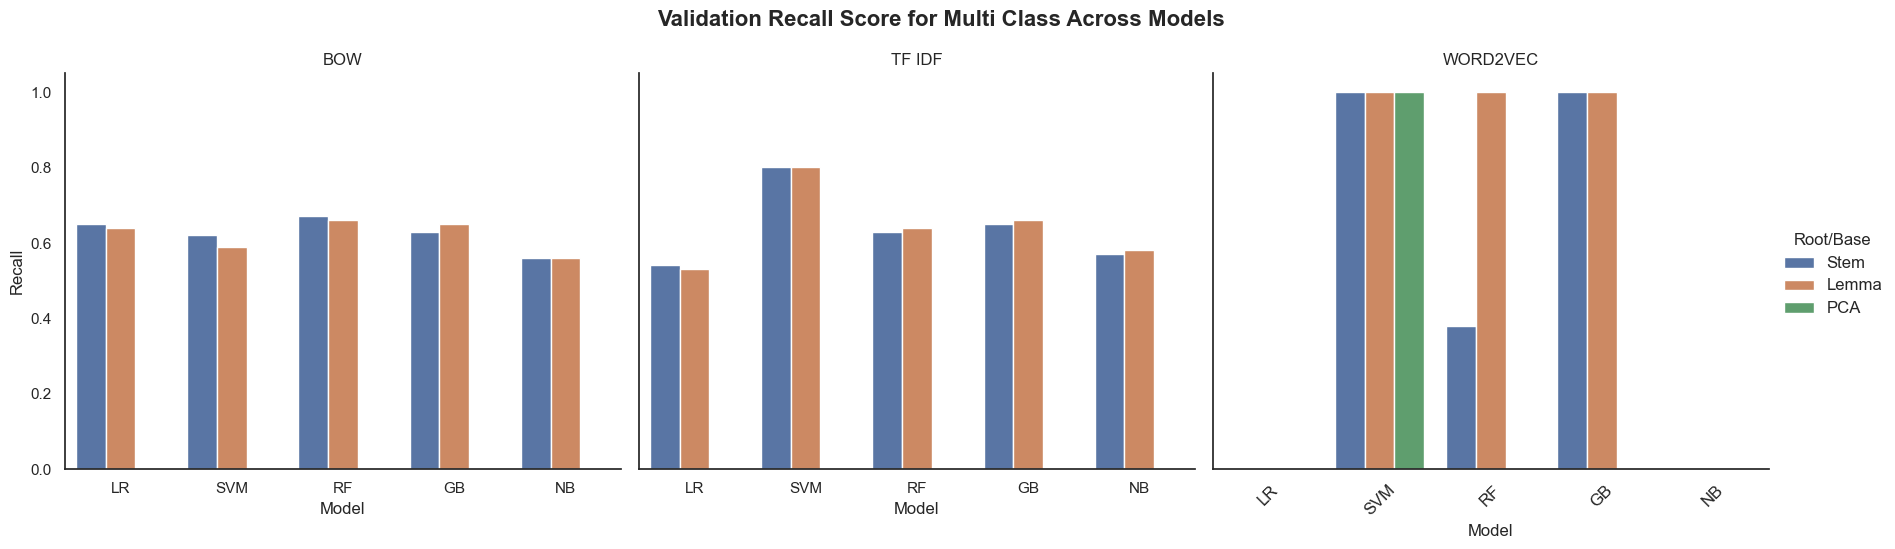

In [425]:
#Recall Scores for Test Set
sns.set_theme(style="white")

# Phrase Class Recall Plot
phrase_plot = sns.catplot(data=result_test, x="Model", y="Phrase Rec", hue="Root/Base", 
                       col="Vectorizer", kind="bar", height=5, aspect=1.2)

phrase_plot.fig.suptitle("Validation Recall Score for Phrase Class Across Models", fontsize=16, fontweight="bold", y=1.05)
phrase_plot.set_axis_labels("Model", "Recall")
phrase_plot.set_titles("{col_name}")  # Set titles per vectorizer
phrase_plot._legend.set_title("Root/Base")
plt.setp(phrase_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Passage Class Recall Plot
passage_plot = sns.catplot(data=result_test, x="Model", y="Passage Rec", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

passage_plot.fig.suptitle("Validation Recall Score for Passage Class Across Models", fontsize=16, fontweight="bold", y=1.05)
passage_plot.set_axis_labels("Model", "Recall")
passage_plot.set_titles("{col_name}")  
passage_plot._legend.set_title("Root/Base")
plt.setp(passage_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Multi Class Recall Plot
multi_plot = sns.catplot(data=result_test, x="Model", y="Multi Rec", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

multi_plot.fig.suptitle("Validation Recall Score for Multi Class Across Models", fontsize=16, fontweight="bold", y=1.05)
multi_plot.set_axis_labels("Model", "Recall")
multi_plot.set_titles("{col_name}")  
multi_plot._legend.set_title("Root/Base")
plt.setp(multi_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


plt.show()

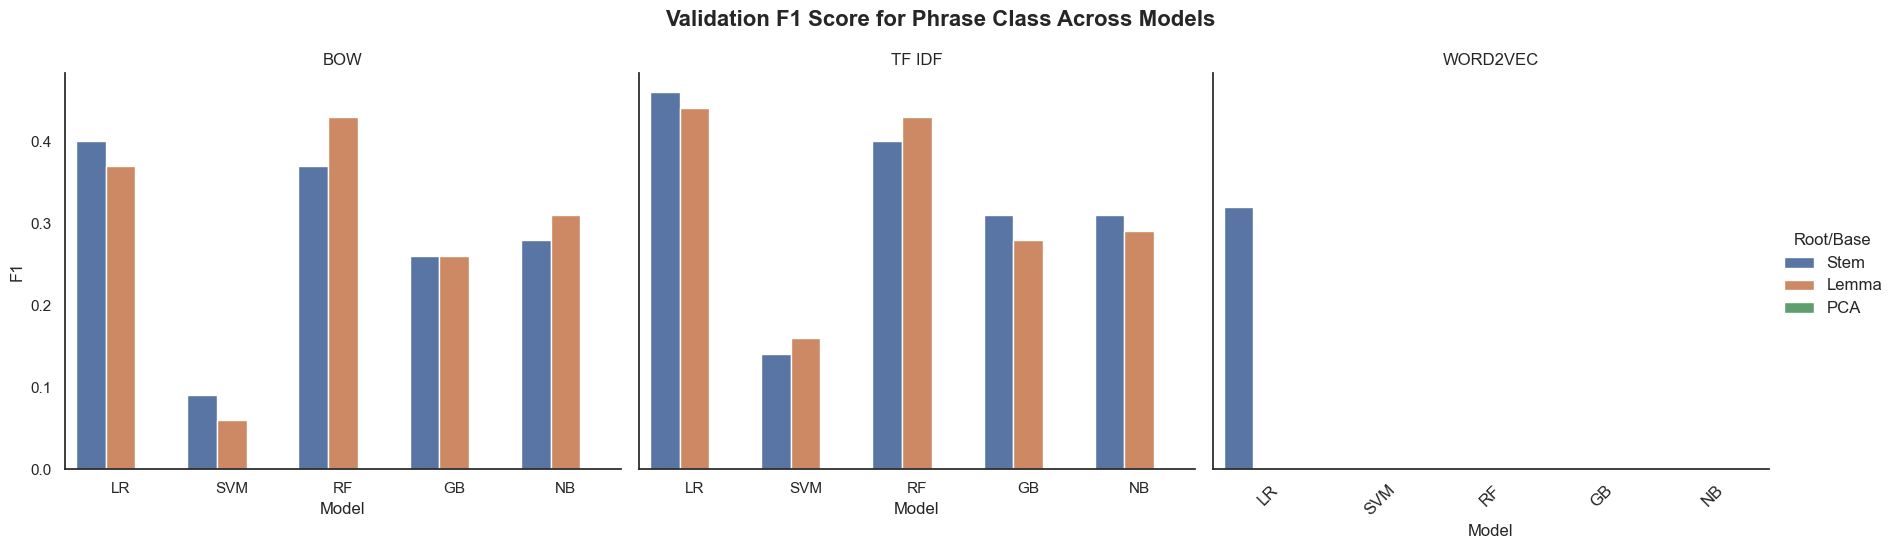

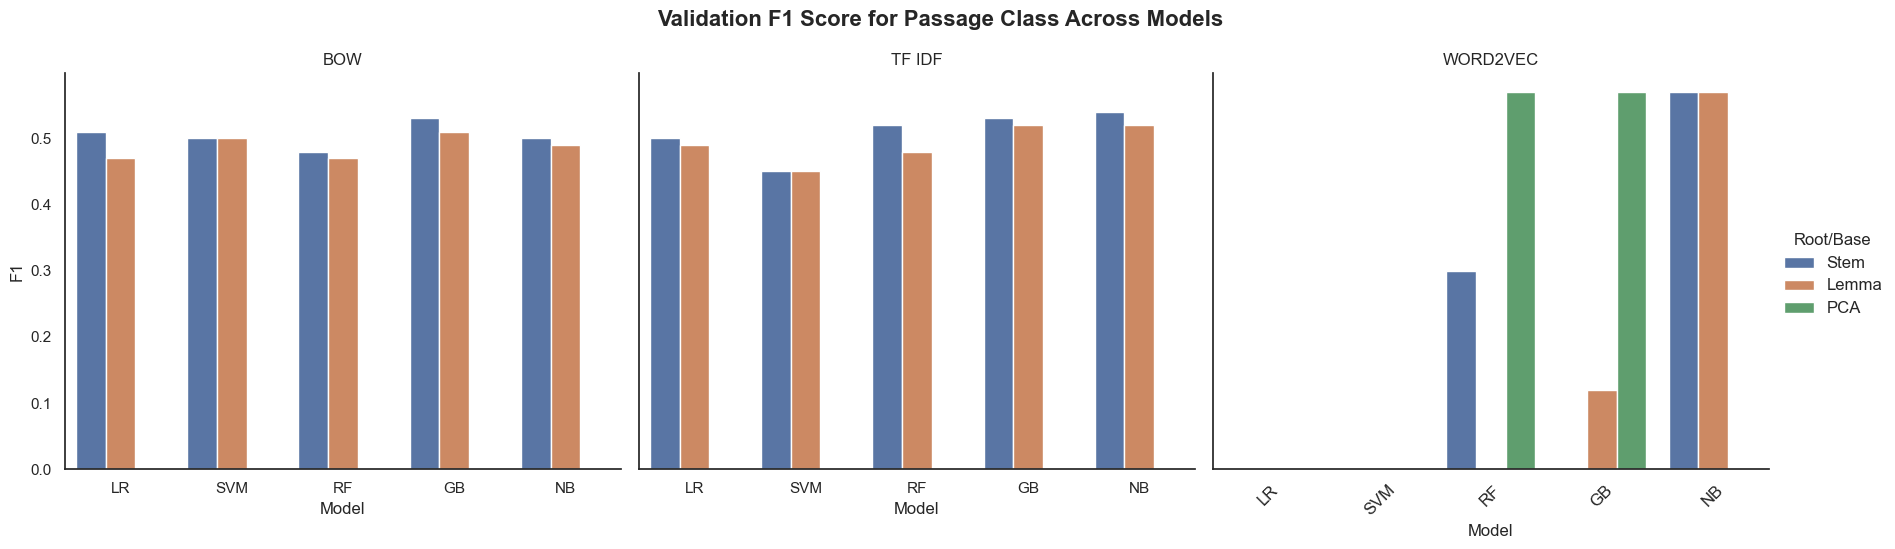

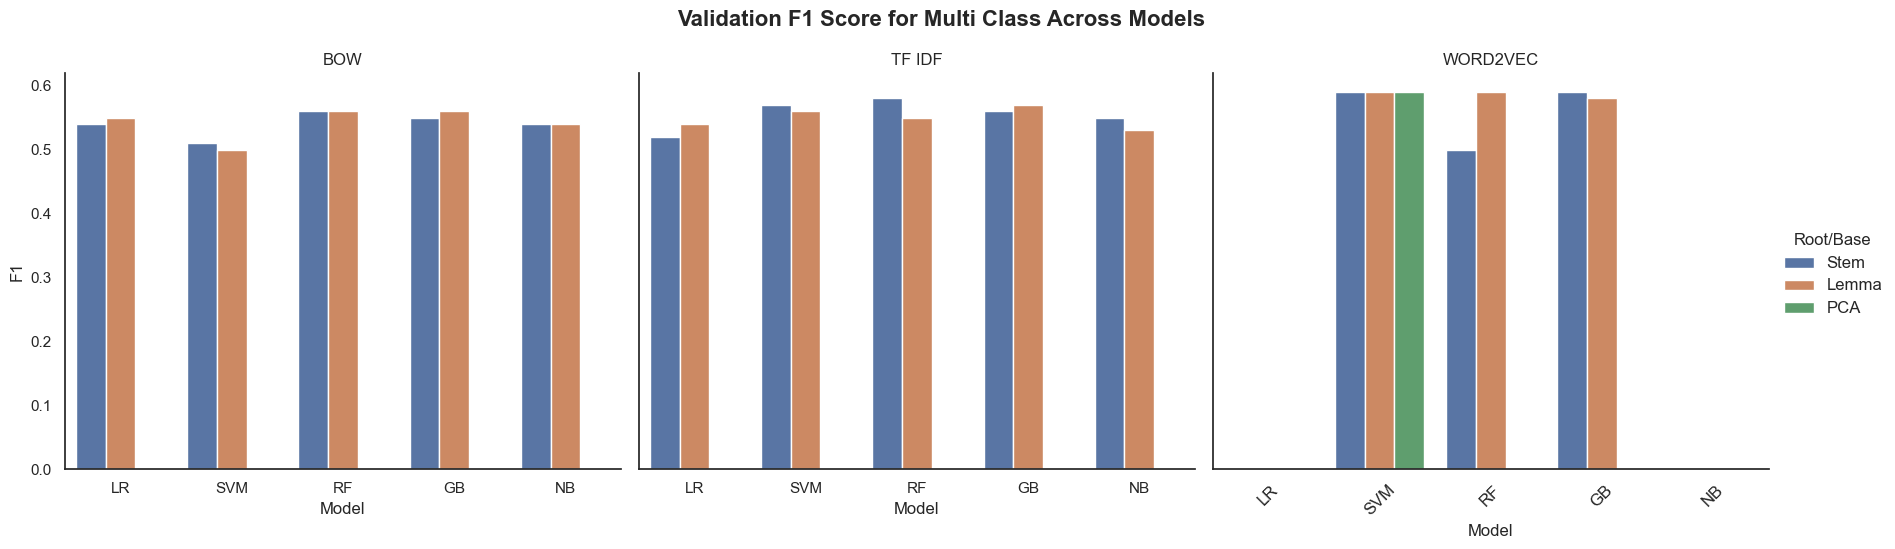

In [426]:
#F1 Scores for Validation Set
sns.set_theme(style="white")

# Phrase Class F1 Plot
phrase_plot = sns.catplot(data=result_val, x="Model", y="Phrase F1", hue="Root/Base", 
                       col="Vectorizer", kind="bar", height=5, aspect=1.2)

phrase_plot.fig.suptitle("Validation F1 Score for Phrase Class Across Models", fontsize=16, fontweight="bold", y=1.05)
phrase_plot.set_axis_labels("Model", "F1")
phrase_plot.set_titles("{col_name}")  # Set titles per vectorizer
phrase_plot._legend.set_title("Root/Base")
plt.setp(phrase_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Passage Class F1 Plot
passage_plot = sns.catplot(data=result_val, x="Model", y="Passage F1", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

passage_plot.fig.suptitle("Validation F1 Score for Passage Class Across Models", fontsize=16, fontweight="bold", y=1.05)
passage_plot.set_axis_labels("Model", "F1")
passage_plot.set_titles("{col_name}")  
passage_plot._legend.set_title("Root/Base")
plt.setp(passage_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Multi Class F1 Plot
multi_plot = sns.catplot(data=result_val, x="Model", y="Multi F1", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

multi_plot.fig.suptitle("Validation F1 Score for Multi Class Across Models", fontsize=16, fontweight="bold", y=1.05)
multi_plot.set_axis_labels("Model", "F1")
multi_plot.set_titles("{col_name}")  
multi_plot._legend.set_title("Root/Base")
plt.setp(multi_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


plt.show()

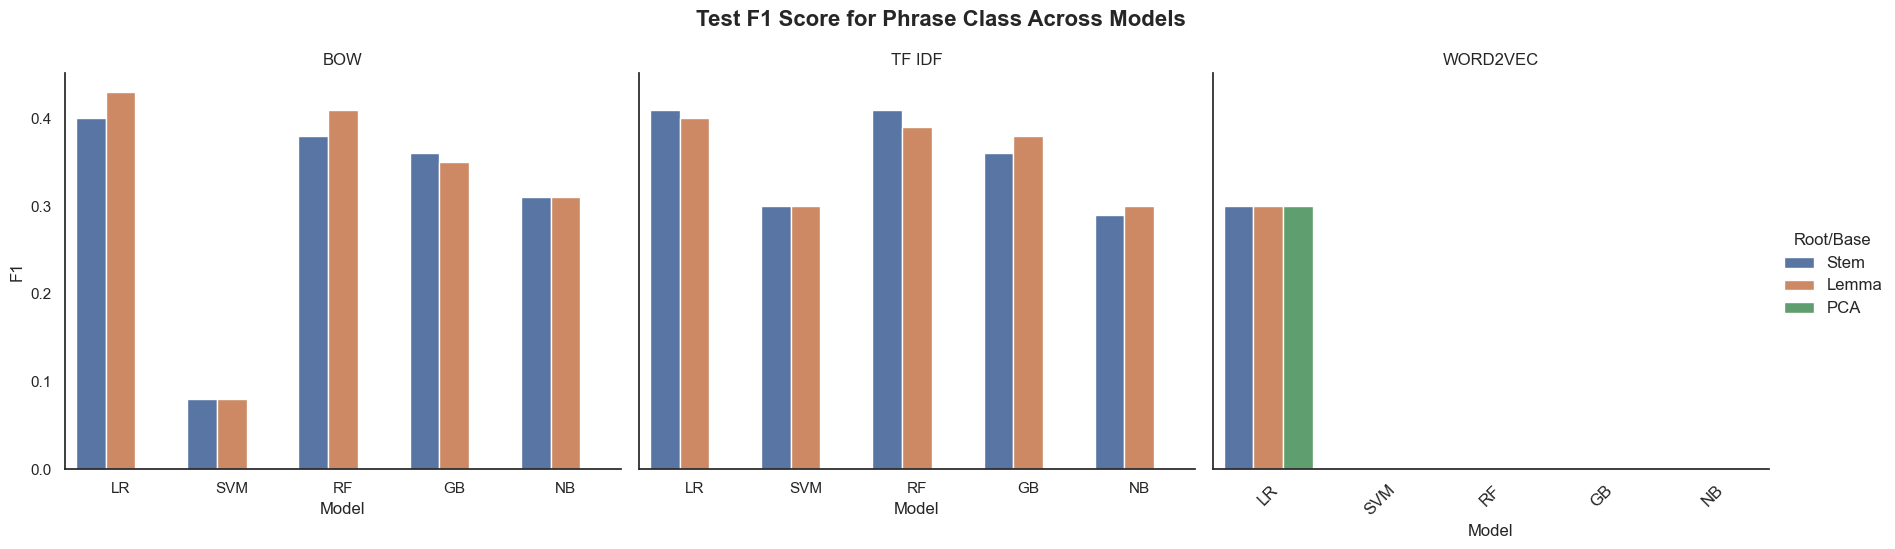

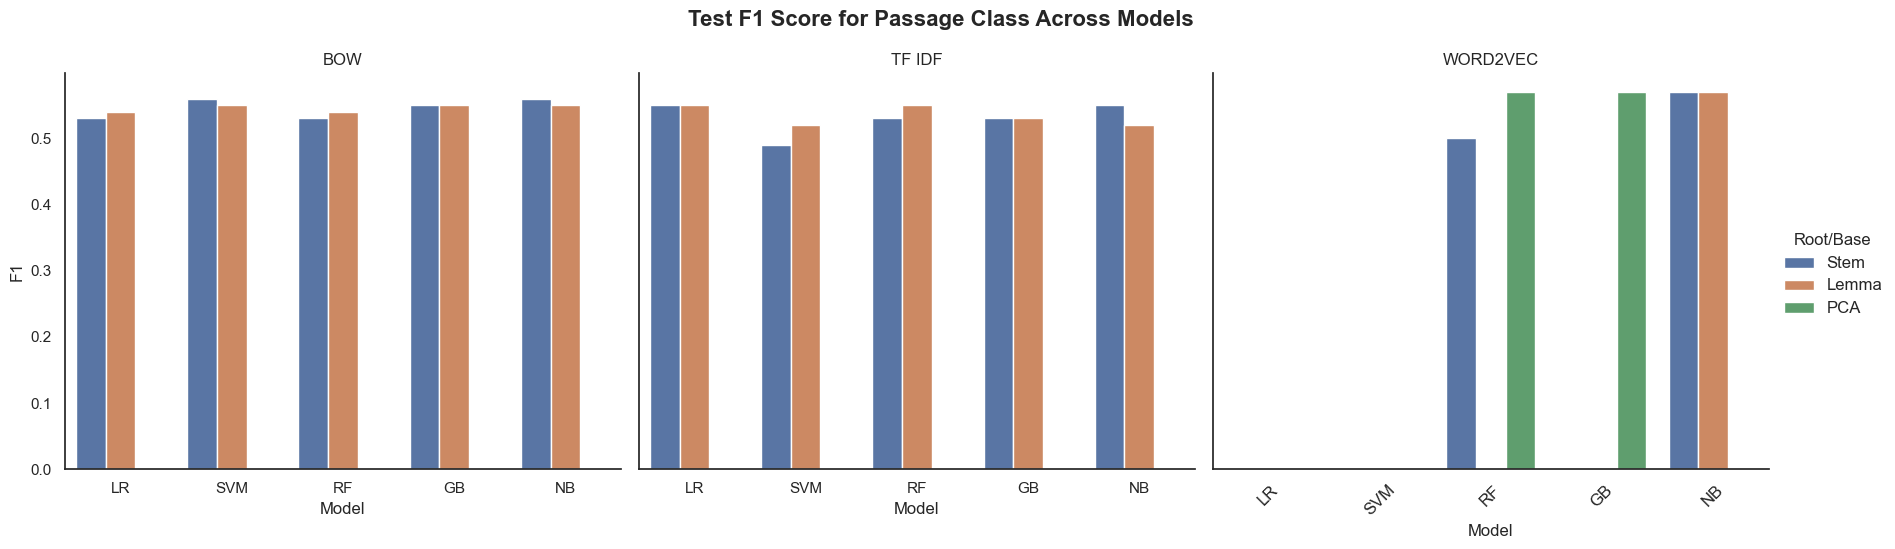

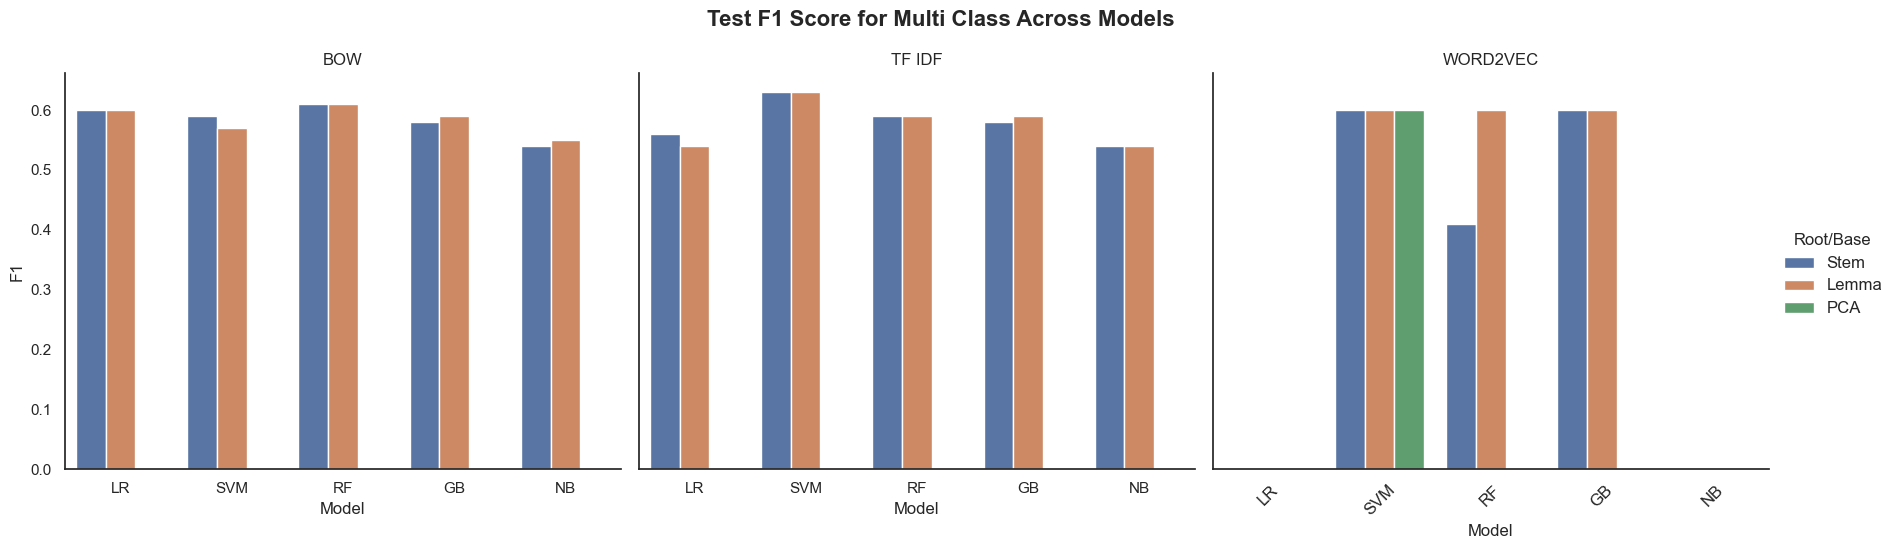

In [427]:
#F1 Scores for Test Set
sns.set_theme(style="white")

# Phrase Class F1 Plot
phrase_plot = sns.catplot(data=result_test, x="Model", y="Phrase F1", hue="Root/Base", 
                       col="Vectorizer", kind="bar", height=5, aspect=1.2)

phrase_plot.fig.suptitle("Test F1 Score for Phrase Class Across Models", fontsize=16, fontweight="bold", y=1.05)
phrase_plot.set_axis_labels("Model", "F1")
phrase_plot.set_titles("{col_name}")  # Set titles per vectorizer
phrase_plot._legend.set_title("Root/Base")
plt.setp(phrase_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Passage Class F1 Plot
passage_plot = sns.catplot(data=result_test, x="Model", y="Passage F1", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

passage_plot.fig.suptitle("Test F1 Score for Passage Class Across Models", fontsize=16, fontweight="bold", y=1.05)
passage_plot.set_axis_labels("Model", "F1")
passage_plot.set_titles("{col_name}")  
passage_plot._legend.set_title("Root/Base")
plt.setp(passage_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)

# Multi Class F1 Plot
multi_plot = sns.catplot(data=result_test, x="Model", y="Multi F1", hue="Root/Base", 
                           col="Vectorizer", kind="bar", height=5, aspect=1.2)

multi_plot.fig.suptitle("Test F1 Score for Multi Class Across Models", fontsize=16, fontweight="bold", y=1.05)
multi_plot.set_axis_labels("Model", "F1")
multi_plot.set_titles("{col_name}")  
multi_plot._legend.set_title("Root/Base")
plt.setp(multi_plot._legend.get_texts(), fontsize=12)
plt.xticks(rotation=45, fontsize=12)  
plt.yticks(fontsize=12)


plt.show()